# House Prices Project
> 
* 1) Libraries and Data Loading
* 2) Splitting data types
* 3) Removing outliers
* 3) Replacing NaN values
* 4) Exploratory Data Analysis and Data Cleaning
* 5) Machine Learning Models
* 6) Model Evaluation and Selection
* 7) Submission

# 1) Libraries and Data Loading

> Importing all the library and loading the train and test data

In [450]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from scipy import stats
from scipy.stats import boxcox_normmax
from scipy.special import boxcox1p
import math


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import  mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score
from sklearn.model_selection import KFold

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

warnings.filterwarnings("ignore")


In [2]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
test["SalePrice"] = np.nan # we don't have target values for the test

## 2) Splitting Data Type

> After analyzing the features, the features is split into categorical and numerical data and then further split into sub sections

![Variable Types](http://survivestatistics.com/wp-content/uploads/2016/07/variables3.jpg)

In [3]:
num_discrete = ['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd',
                'Fireplaces','GarageCars','GarageYrBlt','YearBuilt','YearRemodAdd','YrSold','MoSold']

num_continuous = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF',
                  '2ndFlrSF','LowQualFinSF','GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch',
                  '3SsnPorch','ScreenPorch','PoolArea','MiscVal']

cat_ordinal = ['LotShape','Utilities','LandSlope','OverallQual','OverallCond','ExterQual','ExterCond',
               'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','CentralAir',
               'Electrical','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual','GarageCond',
               'PavedDrive','PoolQC','Fence']

cat_nominal = ['MSSubClass','MSZoning','Street','Alley','LandContour','LotConfig','Neighborhood',
               'Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st',
               'Exterior2nd','MasVnrType','Foundation','Heating','GarageType','MiscFeature',
               'SaleType','SaleCondition']

# 3) Removing outliers 

> To determine the outliers of the data, we would be using a z-score of -3 and +3 as the benchmark for lower outliers and upper outliers. We would also take into account the number of zeros in each column to know how much of the outlier has the value of 0.

In [4]:
def z_score(df): 
    return (df-df.mean())/df.std()

In [5]:
# Let's take a look at the number of outliers of the variables with correlation > 0.3 and % of zeros < 30%

id_name = []
id_outlier = []
id_corr = []
id_zeros = []

for i in num_continuous:
    id_name.append(i)
    id_outlier.append(list(abs(z_score(train[i])) > 3).count(True))
    id_corr.append(train.SalePrice.corr(train[i]))
    id_zeros.append(len(train[i][train[i] == 0])/len(train[i]))
        
outs = pd.DataFrame({'Feature': id_name, 
                     '# of Outliers': id_outlier, 
                     'Correlation': id_corr, 
                     '% of Zeros': id_zeros}).sort_values(ascending = False, 
                                                 by = '# of Outliers')

outs = outs[abs(outs["Correlation"]) > 0.2].reset_index(drop=True)
outs = outs[outs["% of Zeros"] < 0.3].reset_index(drop=True)
outs

Feature  # of Outliers  Correlation  % of Zeros
0    GrLivArea             16     0.708624    0.000000
1      LotArea             13     0.263843    0.000000
2  LotFrontage             12     0.351799    0.000000
3     1stFlrSF             12     0.605852    0.000000
4    BsmtUnfSF             11     0.214479    0.080822
5  TotalBsmtSF             10     0.613581    0.025342
6   GarageArea              7     0.623431    0.055479

In [6]:
# defining a function to plot the correlation of the variables shown above with SalePrice, so we can delete Low Price's outliers

def plot_outliers():
    
    fig = plt.figure(figsize=(15,15), constrained_layout=True)

    gs = GridSpec(4,2,figure=fig)

    rows = [0,0,1,1,2,2,3,3]
    columns = [0,1,0,1,0,1,0,1]

    colors = ['green', 'red', 'blue', '#5de6e6', 'orange', 'grey', 'purple','pink']

    counter = 0

    for i in outs.Feature:
        sns.scatterplot(y=train.SalePrice, x=train[i], 
                      ax=fig.add_subplot(gs[rows[counter],columns[counter]]),
                      color=colors[counter])
        counter += 1

    fig.show()

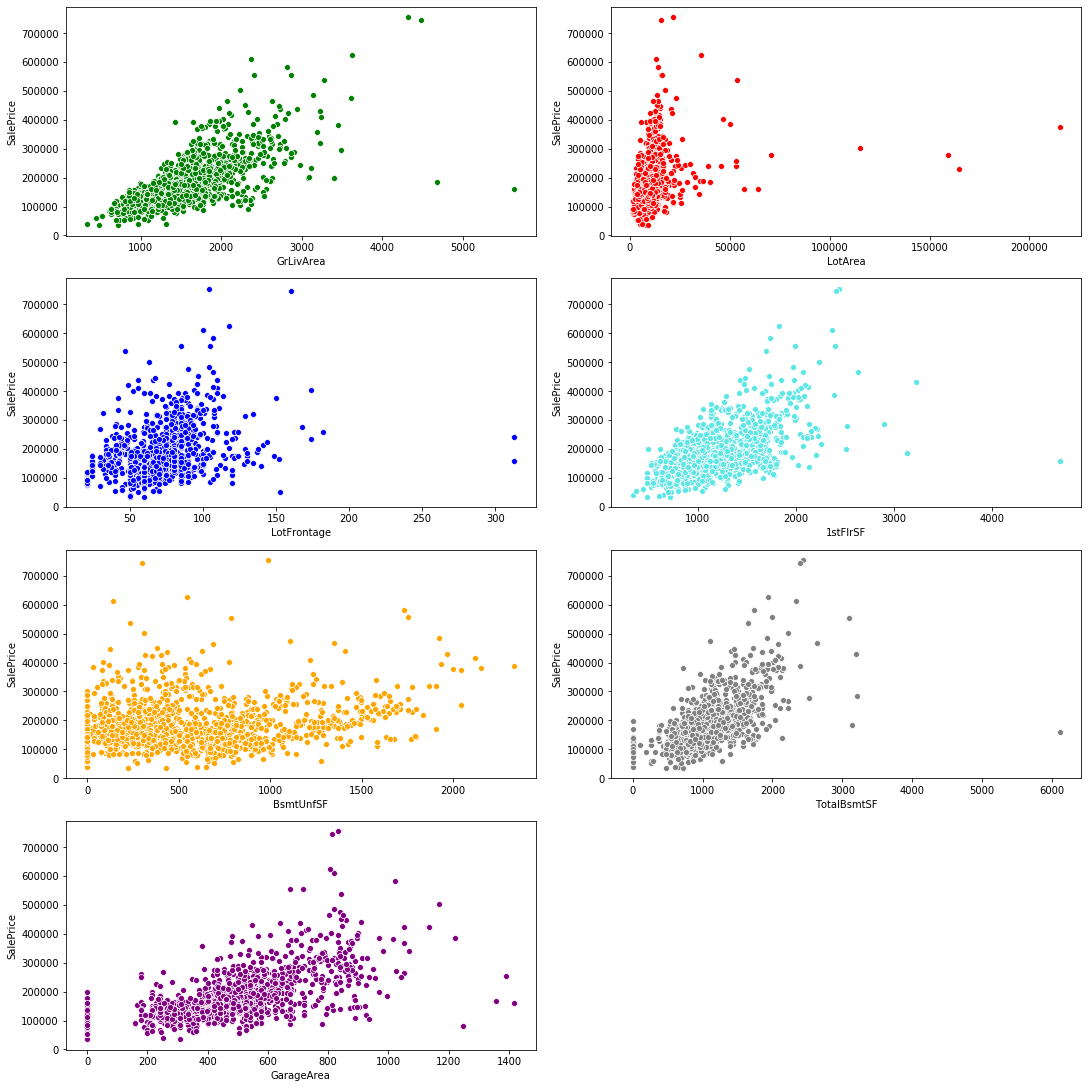

In [7]:
plot_outliers()

> From this we selected several of the following feature's outlier to be removed as it may disrupt the correlation of the specified feature
- GrLivArea
- 1stFlrSf
- LotFrontage
- TotalBsmntSF

> We do not want to remove all of the data that exceeds the 3.0 z-score threshold as it might affect the results 

In [8]:
# Removing all extreme outliers in each of the mentioned feature 
train = train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 400000)].index)
train = train.drop(train[(train['1stFlrSF'] > 4000) & (train['SalePrice'] < 300000)].index)
train = train.drop(train[(train['LotFrontage'] > 300) & (train['SalePrice'] < 400000)].index)
train = train.drop(train[train['TotalBsmtSF'] > 5000].index)

# 4) Replacing NaN values

> In this process we would be replacing NaN values with their corresponding values. To prevent replacing NaN values in train and test values individually, we concatenate both train and test data

In [9]:
df = pd.concat([train,test],axis=0).reset_index(drop=True)
df = df.fillna(np.nan)


In [10]:
df.loc[:, df.isna().any()].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2916 entries, 0 to 2915
Data columns (total 35 columns):
MSZoning        2912 non-null object
LotFrontage     2430 non-null float64
Alley           198 non-null object
Utilities       2914 non-null object
Exterior1st     2915 non-null object
Exterior2nd     2915 non-null object
MasVnrType      2892 non-null object
MasVnrArea      2893 non-null float64
BsmtQual        2835 non-null object
BsmtCond        2834 non-null object
BsmtExposure    2834 non-null object
BsmtFinType1    2837 non-null object
BsmtFinSF1      2915 non-null float64
BsmtFinType2    2836 non-null object
BsmtFinSF2      2915 non-null float64
BsmtUnfSF       2915 non-null float64
TotalBsmtSF     2915 non-null float64
Electrical      2915 non-null object
BsmtFullBath    2914 non-null float64
BsmtHalfBath    2914 non-null float64
KitchenQual     2915 non-null object
Functional      2914 non-null object
FireplaceQu     1496 non-null object
GarageType      2759 non-null objec

## Filling categorical, ordinal NaN values

In [11]:
# For these 4 specific features we would be using the mode function, we do not use the "NA" value to 
# replace the NaN values because every house requires these 4 characteristics  
df['Functional'] = df['Functional'].fillna(df['Functional'].mode()[0])
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])
df['KitchenQual'] = df['KitchenQual'].fillna(df['KitchenQual'].mode()[0])
df['Utilities'] = df['Utilities'].fillna(df['Utilities'].mode()[0])

# For the rest of the features we would replace the NaN values with "NA" as these are features of which a house can exist without
for col in cat_ordinal:
    df[col] = df[col].fillna('NA')

## Filling categorical, nominal NaN values

In [12]:
# For these 4 specific df we would be using the mode function, we do not use the "NA" value to 
# replace the NaN values because every house requires these 4 characteristics  
df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])
df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])

# For the rest of the features we would replace the NaN values with "NA" as these are features of which a house can exist without
for col in cat_nominal:
    df[col] = df[col].fillna('NA')

## Filling numerical, continuous NaN values

In [13]:
# Filling the NA values for 'LotFrontage' based on the street
# LotFrontage is the Linear feet of street connected to property which should be similar for properties that are located in the
# same neighbourhood
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# For the rest of the features we would replace the NaN values with the median value of respective features

for col in num_continuous:
    df[col] = df[col].fillna(df[col].median())

## Filling numerical, discrete NaN values

In [14]:
# NaN values for these columns means that they dont have a single quantity of the feature
for col in ['GarageArea', 'GarageCars']:
    df[col] = df[col].fillna(0)

for col in ['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath']:
    df[col] = df[col].fillna(0)

# NaN values means that they have no garage, these empty data are filled with NA
for col in ['GarageYrBlt','GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    df[col] = df[col].fillna('NA')
    
# Just like the above, NA value represents no basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df[col] = df[col].fillna('NA')

# For the rest we would replace the NaN values with 0
for col in num_discrete:
    df[col] = df[col].fillna(0)

In [15]:
df.columns[df.isnull().any()].tolist()

['SalePrice']

# 4-Exploratory Analysis and Data Cleaning

> Here we will analyze every feature for Discrete, Continuous, Ordinal and Nominal variables.

## Discrete Variables

In [442]:
print(num_discrete)

['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd', 'YrSold', 'MoSold']


> We will analyze each discrete variable individually and make decisions based on correlation with SalePrice, lack of information in each category and so on.

In [17]:
# defining a function to plot boxplot and stripplot for non continuous variables
def make_discrete_plot(feature, rotation1, rotation2):
    fig = plt.figure(figsize=(20,8))
    gs = GridSpec(1,2)
    sns.boxplot(y=df['SalePrice'], x=df[feature], ax=fig.add_subplot(gs[0,0]))
    plt.xticks(rotation = rotation1)
    sns.stripplot(y=df['SalePrice'], x=df[feature], ax=fig.add_subplot(gs[0,1]))
    plt.xticks(rotation = rotation2)
    fig.show()

### BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, Total_Bathrooms

> These 4 features tells us about the same feature, so we generate a new feature "Total Number of bathrooms".

### Total_Bathrooms

In [18]:
df["Total_Bathrooms"] = df['BsmtFullBath'] + 0.5*df['BsmtHalfBath'] + df['FullBath'] + 0.5*df['HalfBath']

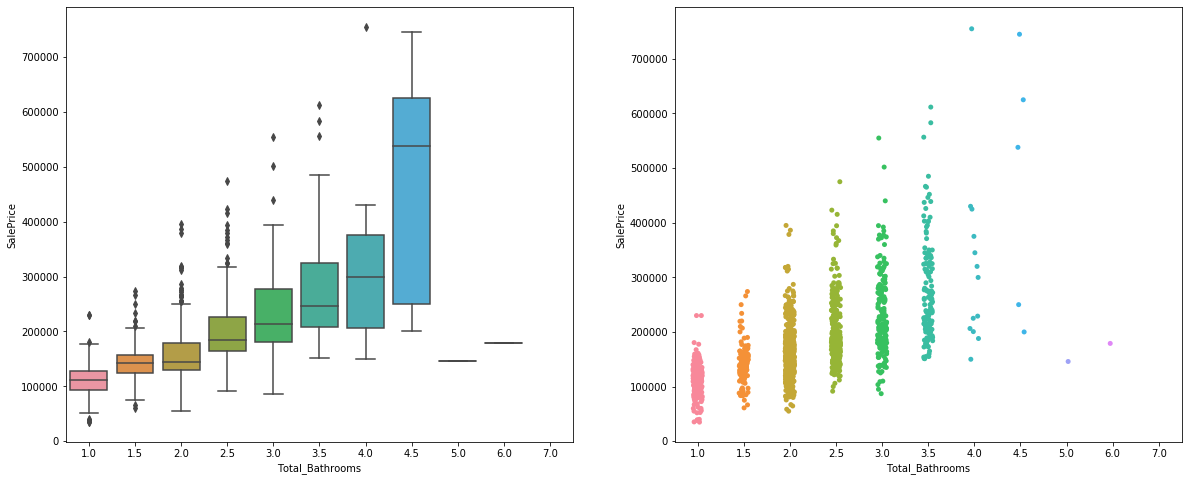

In [19]:
make_discrete_plot("Total_Bathrooms",0,0)

In [20]:
''' as we see from the figure, the total_bathrooms which exceeds from 4 is very few and gives out anomaly box plots,
    so lets replace these values with 4 '''
df['Total_Bathrooms'] = df['Total_Bathrooms'].apply(lambda x: 4 if x > 4 else x)

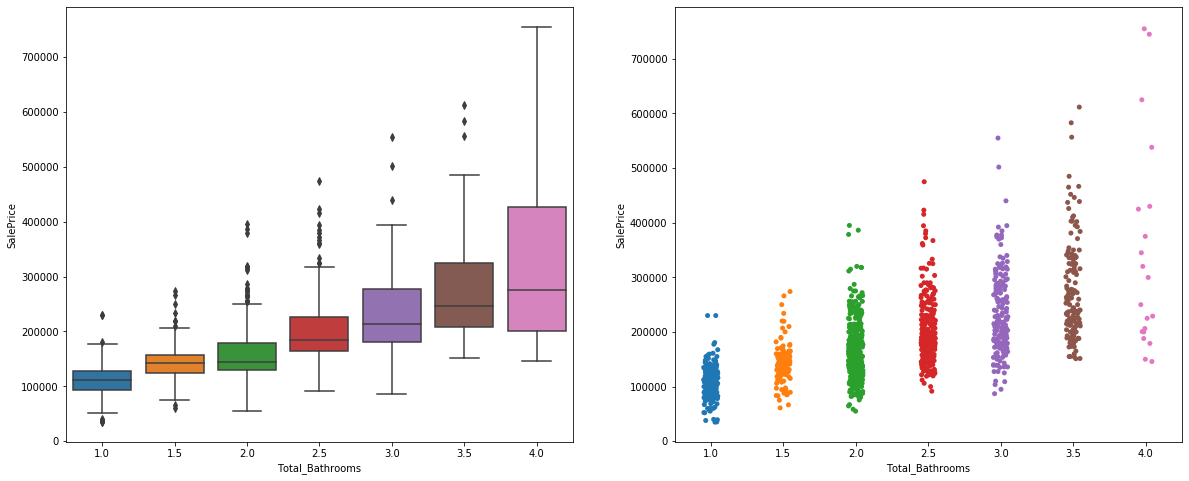

In [21]:
make_discrete_plot("Total_Bathrooms",0,0)

## Explore each of the bathroom features

### BsmtFullBath

> Full bathrooms in basement

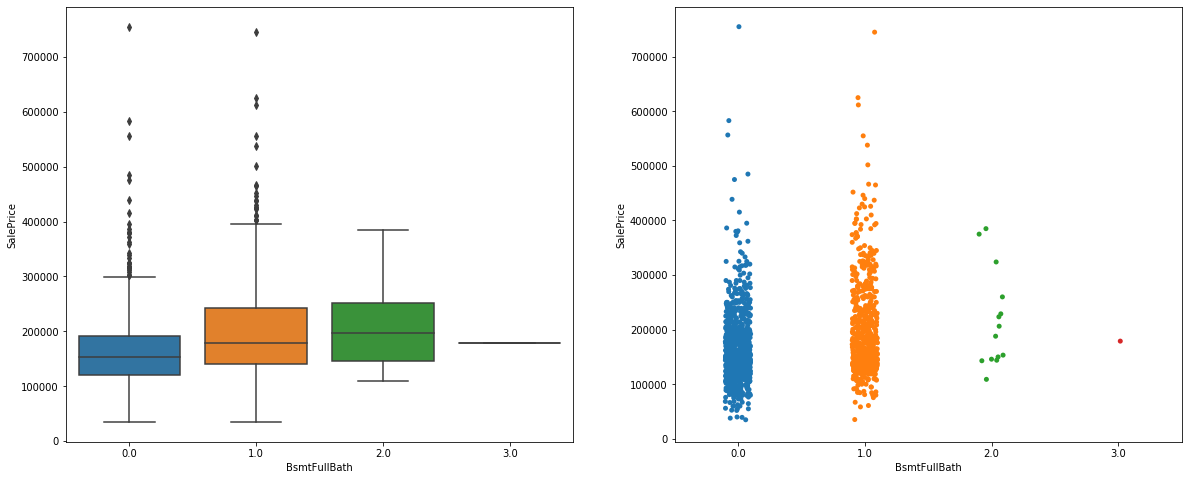

In [22]:
make_discrete_plot("BsmtFullBath",0,0)

In [23]:
# there is only 1 value of BsmtFullBath = 3, replace it with 2 
df['BsmtFullBath'] = df['BsmtFullBath'].apply(lambda x: 2 if x > 2 else x)

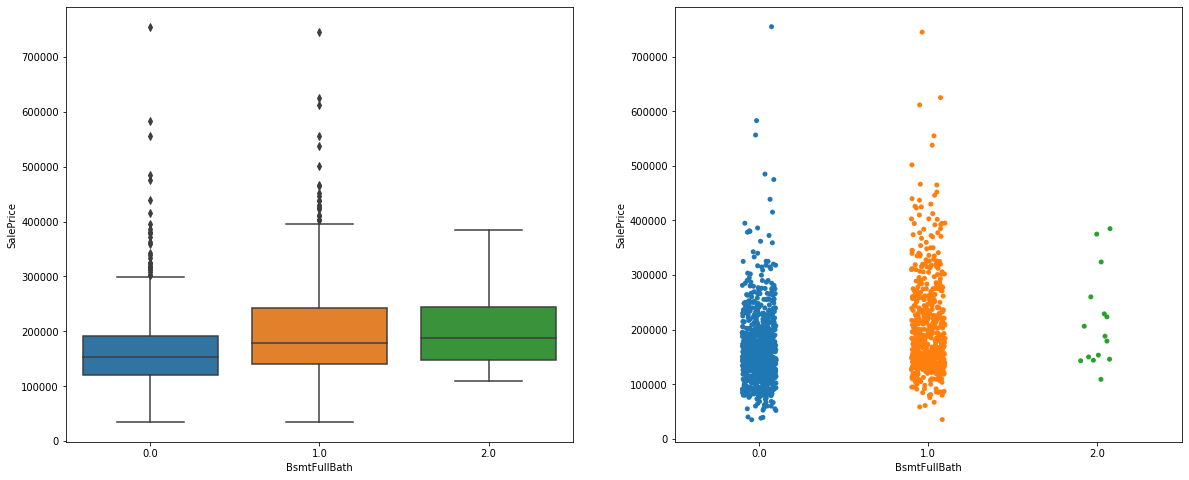

In [24]:
make_discrete_plot("BsmtFullBath",0,0)

### BsmtHalfBath

> Half bathrooms in basement

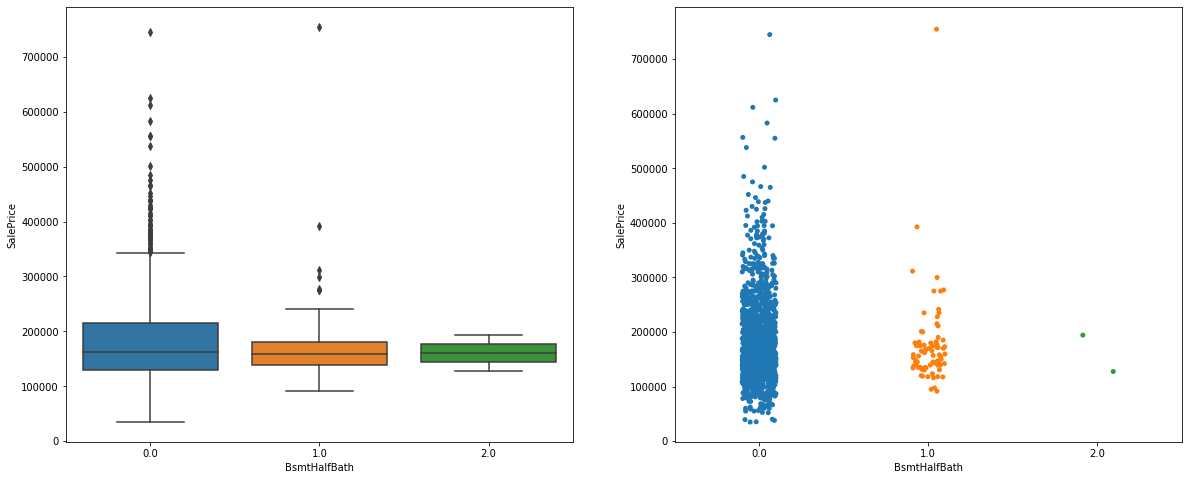

In [25]:
make_discrete_plot("BsmtHalfBath",0,0)

In [26]:
# there few value of BsmtHalfBath > 1, replace it with 1 
df['BsmtHalfBath'] = df['BsmtHalfBath'].apply(lambda x: 1 if x > 1 else x)

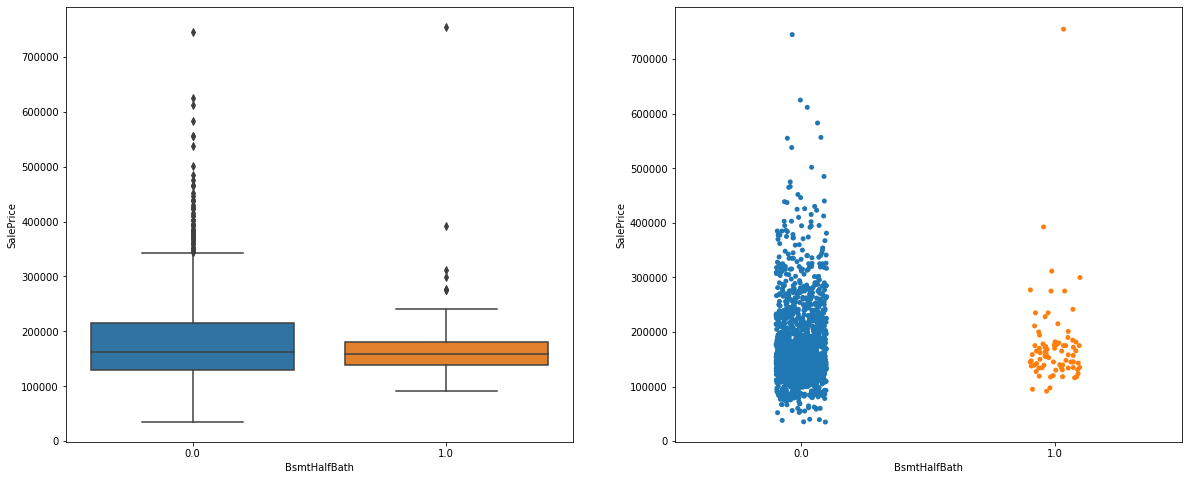

In [27]:
make_discrete_plot("BsmtHalfBath",0,0)

### FullBath

> Full Bathrooms above grade

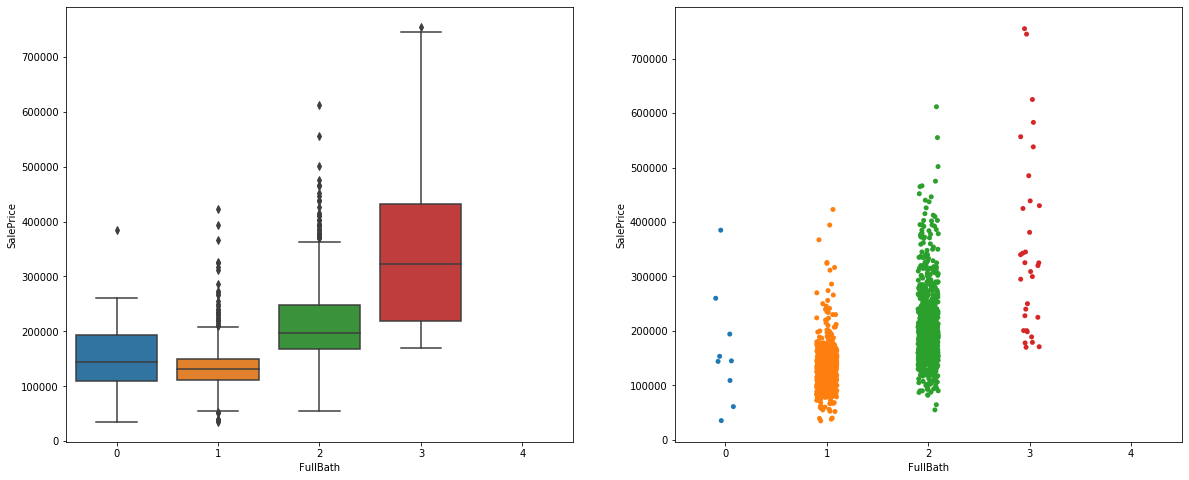

In [28]:
make_discrete_plot("FullBath",0,0)

In [29]:
# Seems like there is a house with 4 fullbathroom house with no saleprice, so lets investigate this data
df[df['FullBath']==4][['FullBath','SalePrice']]

FullBath  SalePrice
1616         4        NaN
1858         4        NaN
1859         4        NaN
1860         4        NaN

In [30]:
# Seems like this is part of the test set, since there are only 4 values of FullBath, we shall replace the value with 3
df['FullBath'] = df['FullBath'].apply(lambda x: 3 if x > 3 else x)

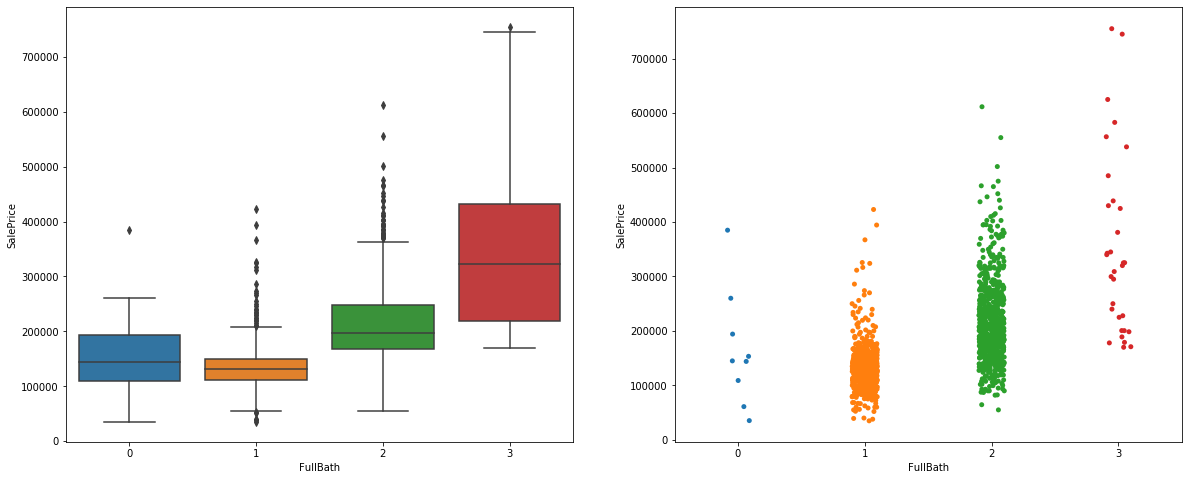

In [31]:
make_discrete_plot("FullBath",0,0)

### HalfBath

> Half bathrooms above grade

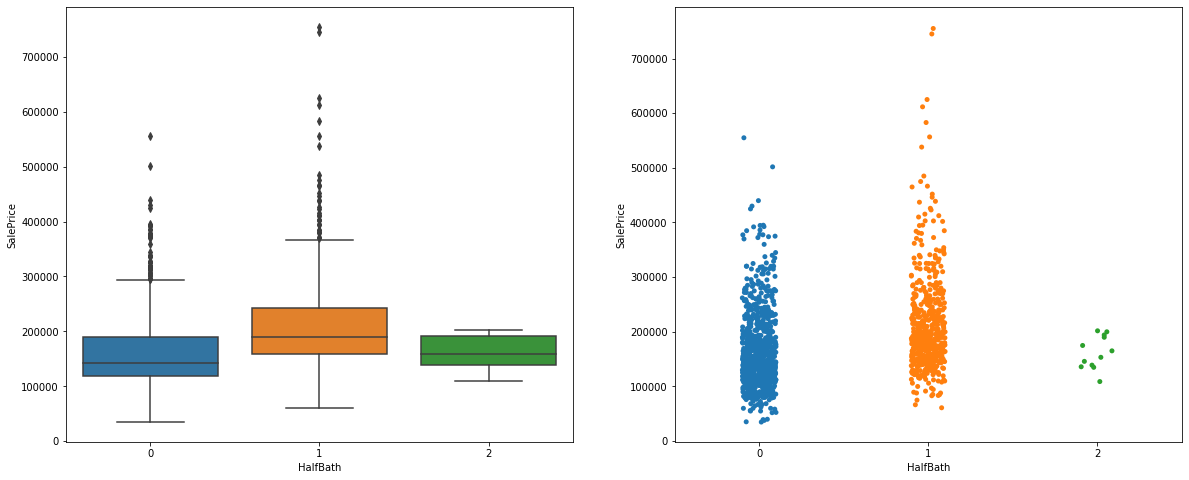

In [32]:
make_discrete_plot("HalfBath",0,0)

> For this we can let it stay the way it is

### BedroomAbvGr

> Bedrooms above grade.

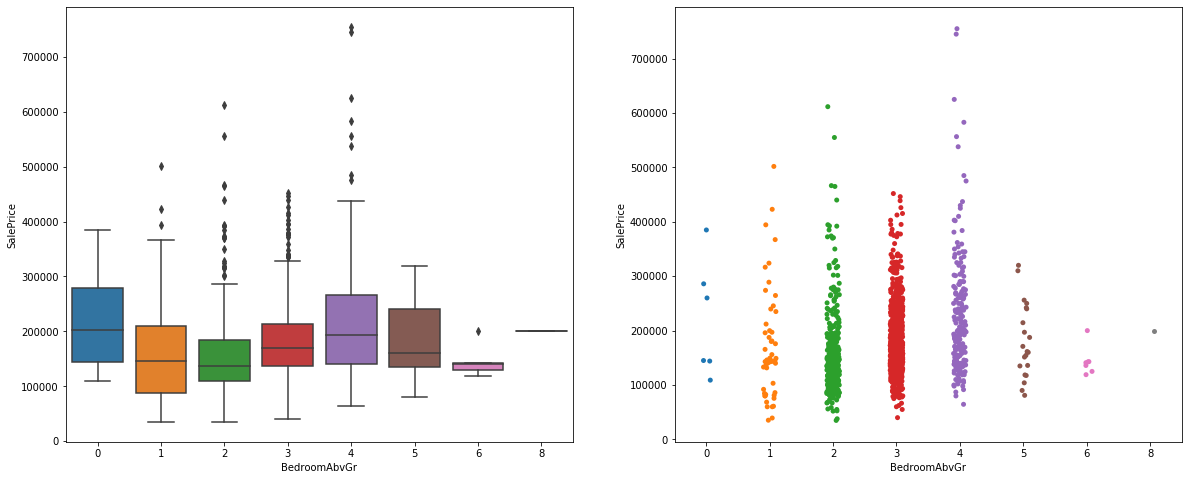

In [33]:
make_discrete_plot("BedroomAbvGr",0,0)

In [34]:
# there are few values greater than 5, lets replace them with 5
df['BedroomAbvGr'] = df['BedroomAbvGr'].apply(lambda x: 5 if x > 5 else x)

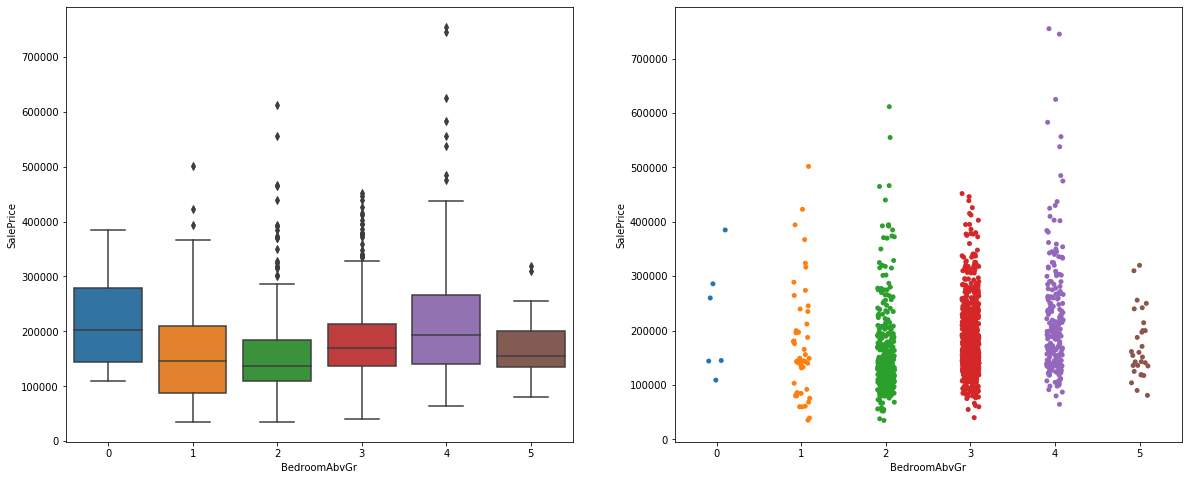

In [35]:
make_discrete_plot("BedroomAbvGr",0,0)

In [36]:
# change type to category
df['BedroomAbvGr'] = df['BedroomAbvGr'].astype(str)

### KitchenAbvGr

> Kitchens above grade.

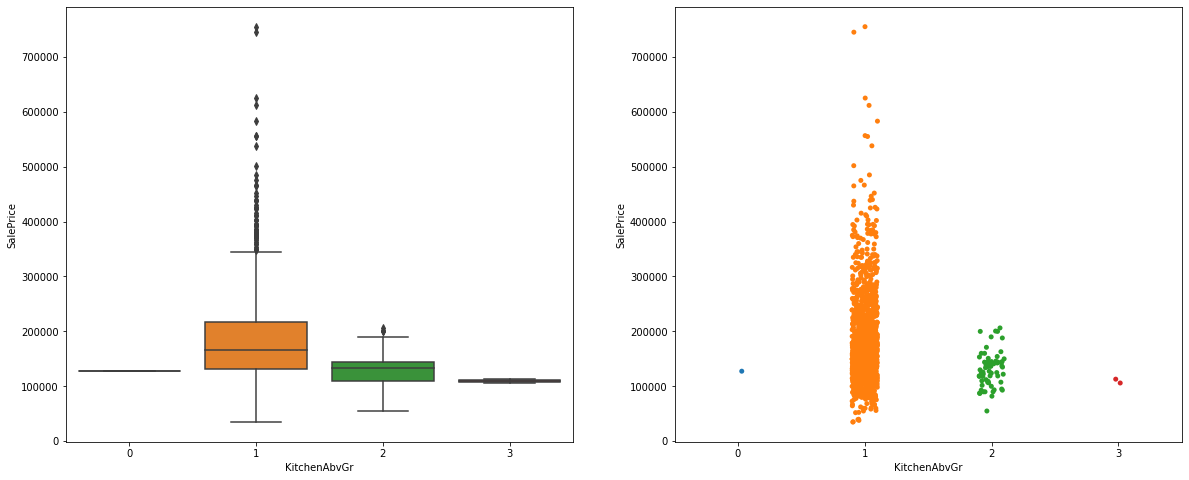

In [37]:
make_discrete_plot("KitchenAbvGr",0,0)

In [38]:
# theres only a fery few values that belongs to 1 and so we will replace them with 1 and 2 respectively
df['KitchenAbvGr'] = df['KitchenAbvGr'].apply(lambda x: 1 if x==0 else(2 if x==3 else x))

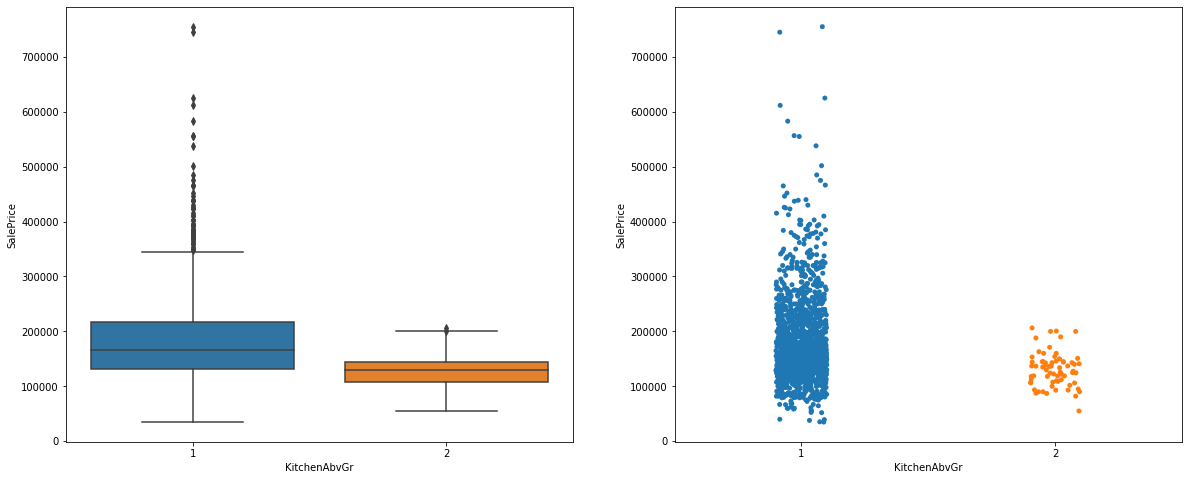

In [39]:
make_discrete_plot("KitchenAbvGr",0,0)

In [40]:
# looks like there isnt any strong correlation, therefore changing the feature into categorical
df['KitchenAbvGr'] = df['KitchenAbvGr'].astype(str)

### TotRmsAbvGrd

> Total rooms above grade (does not include bathrooms).

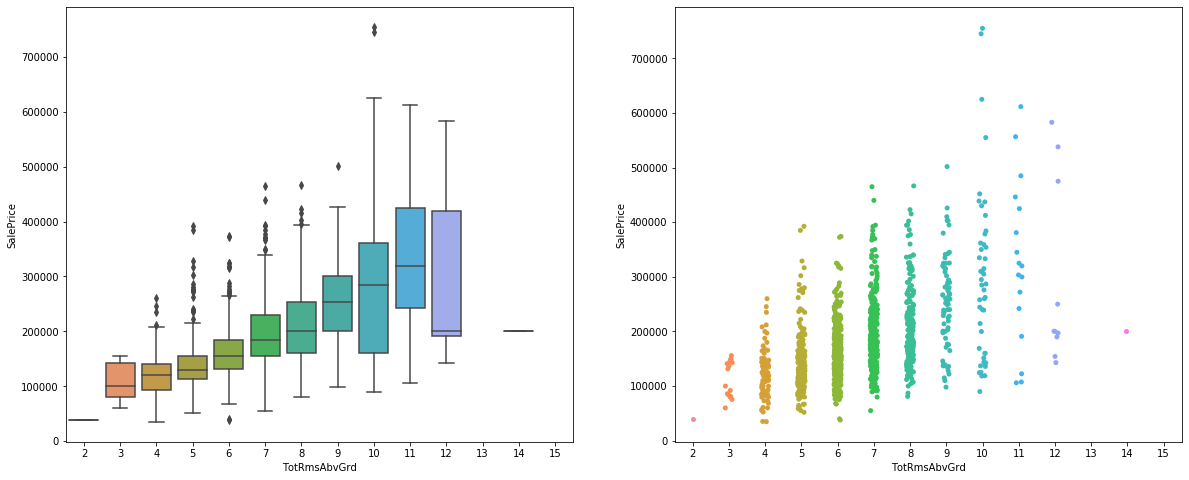

In [41]:
make_discrete_plot("TotRmsAbvGrd",0,0)

In [42]:
# only a few values that is above 11 and equal to 2, so they will be replaced with 2 and 11 respectively
df['TotRmsAbvGrd'] = df['TotRmsAbvGrd'].apply(lambda x: 3 if x==2 else(11 if x>11 else x))

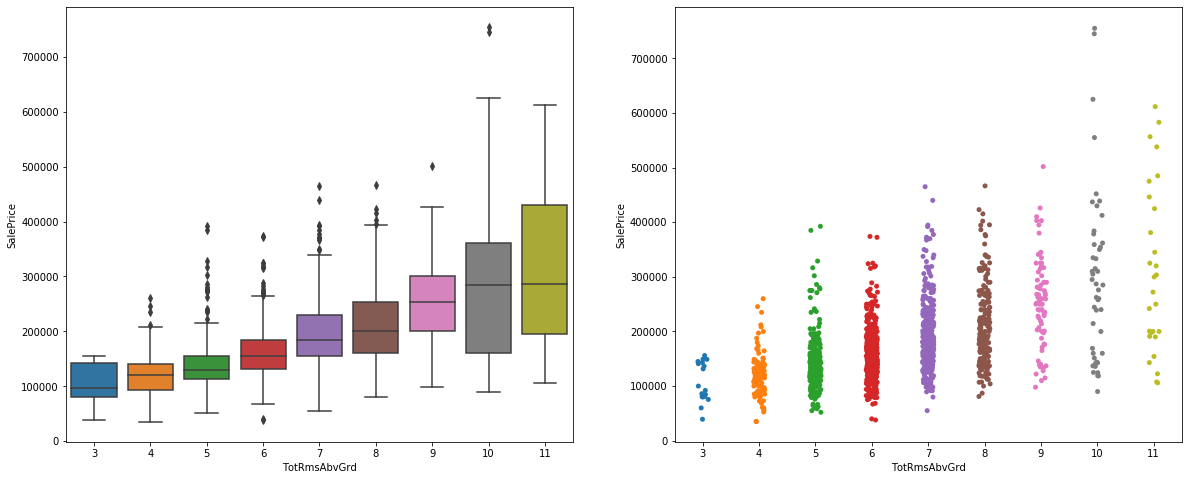

In [43]:
make_discrete_plot("TotRmsAbvGrd",0,0)

In [44]:
#Seems like there is strong linear pattern, so numerical type will be maintained

### Fireplaces

> Number of fireplaces.

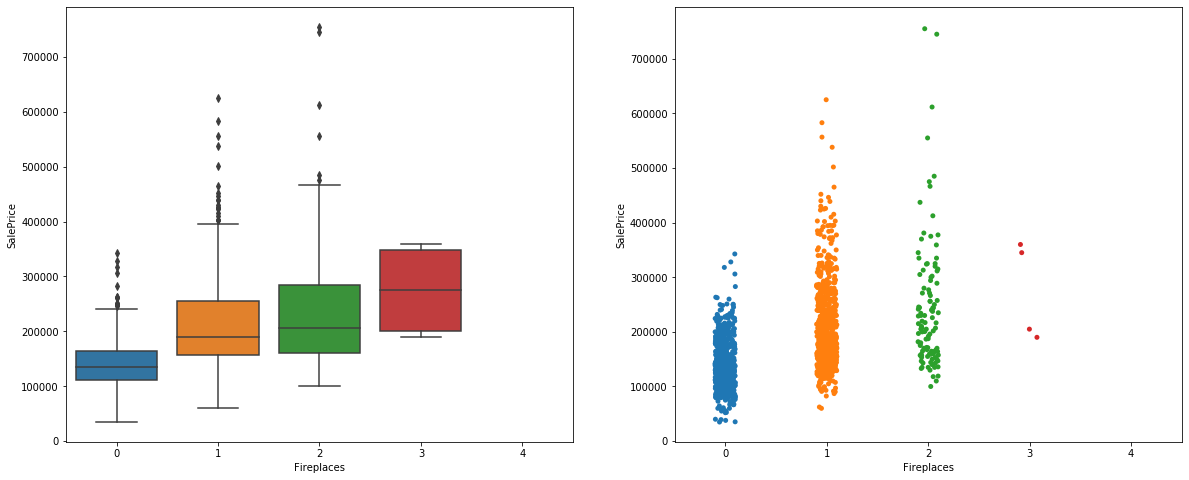

In [45]:
make_discrete_plot("Fireplaces",0,0)

In [46]:
# Only a few values above 2, replacing them with value 2
df['Fireplaces'] = df['Fireplaces'].apply(lambda x: 2 if x>2 else x)

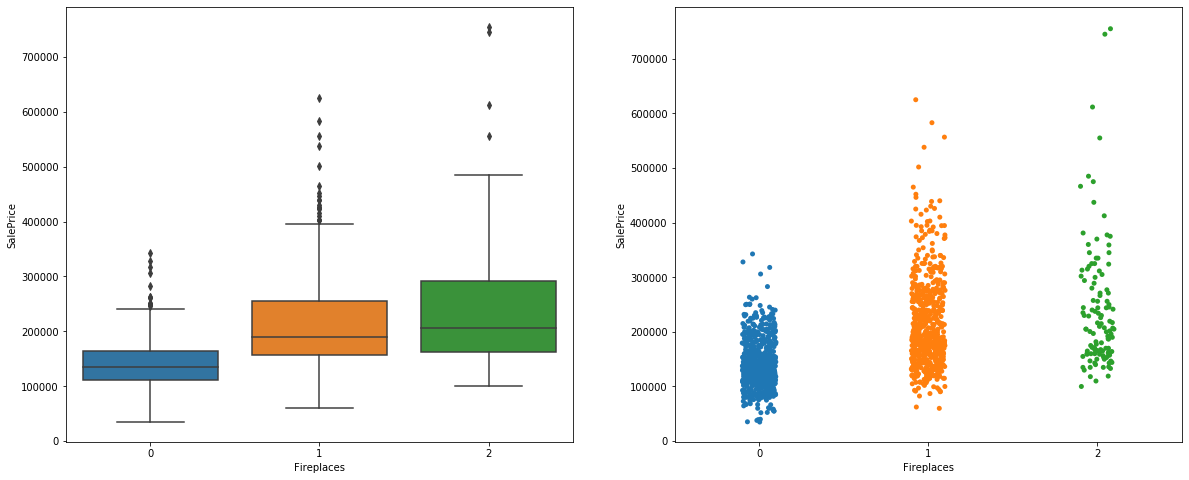

In [47]:
make_discrete_plot("Fireplaces",0,0)

In [48]:
# Seems like there is strong linear pattern, so numerical type will be maintained

### GarageCars

> Size of garage in car capacity.

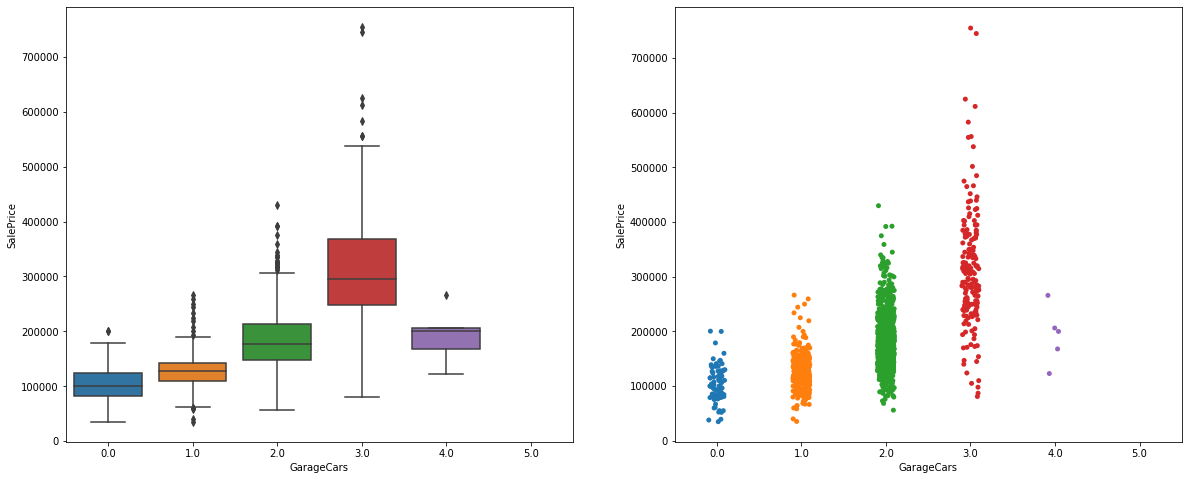

In [49]:
make_discrete_plot("GarageCars",0,0)

In [50]:
# Only a few values above 3, replacing them with value 3
df['GarageCars'] = df['GarageCars'].apply(lambda x: 3 if x>3 else x)

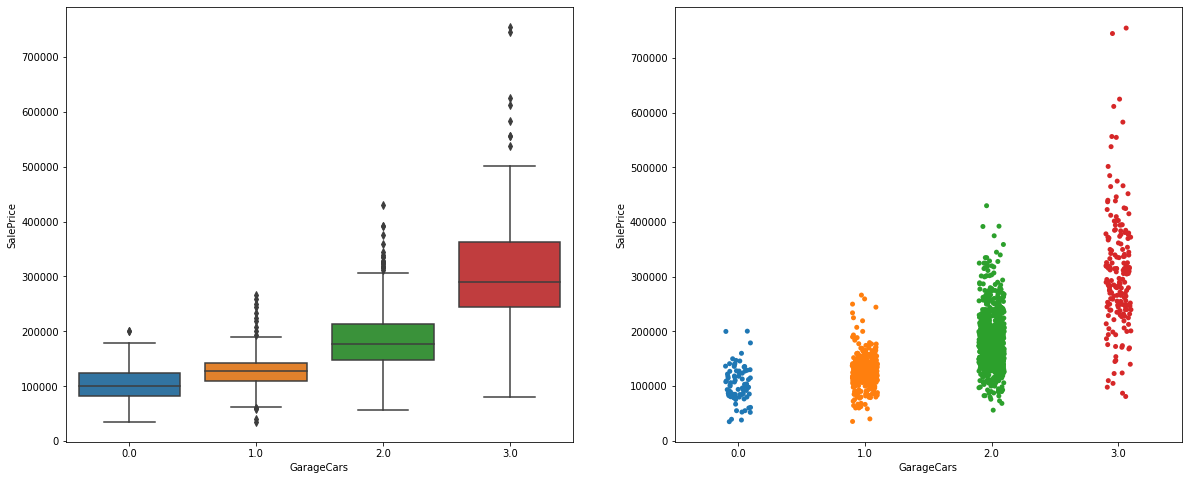

In [51]:
make_discrete_plot("GarageCars",0,0)

In [52]:
# Seems like there is strong correlation, so numerical type will be maintained

### GarageYrBlt

> Year garage was built.

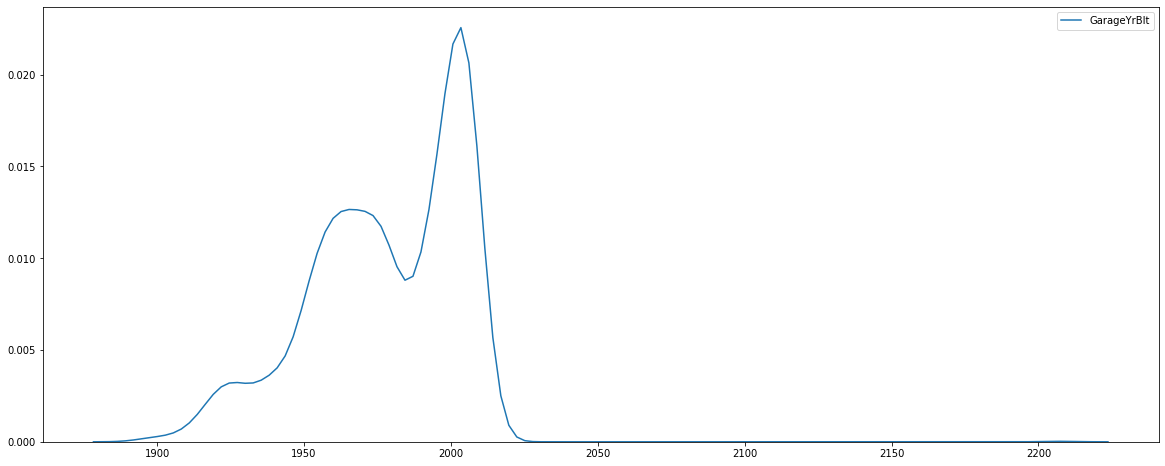

In [53]:
plt.figure(figsize=(20,8))
sns.kdeplot(df['GarageYrBlt'][df['GarageYrBlt']!='NA'])

In [54]:
# It is observed that there are values that are in the future which shouldnt be possible.
df[df['GarageYrBlt']!='NA'][['GarageYrBlt']].sort_values(by='GarageYrBlt',ascending=False).head()

GarageYrBlt
2589        2207
818         2010
378         2010
1605        2010
1499        2010

In [55]:
# Seems like there is a value of 2207, this might be a typo from the user and was trying to type in 2007 instead of 2207.
# So we will be replacing this value with 2007
df['GarageYrBlt'][df['GarageYrBlt'] == 2207] = 2007

In [56]:
df[df['GarageYrBlt']!='NA'][['GarageYrBlt']].sort_values(by='GarageYrBlt',ascending=False).head()

GarageYrBlt
818         2010
378         2010
1499        2010
1605        2010
985         2010

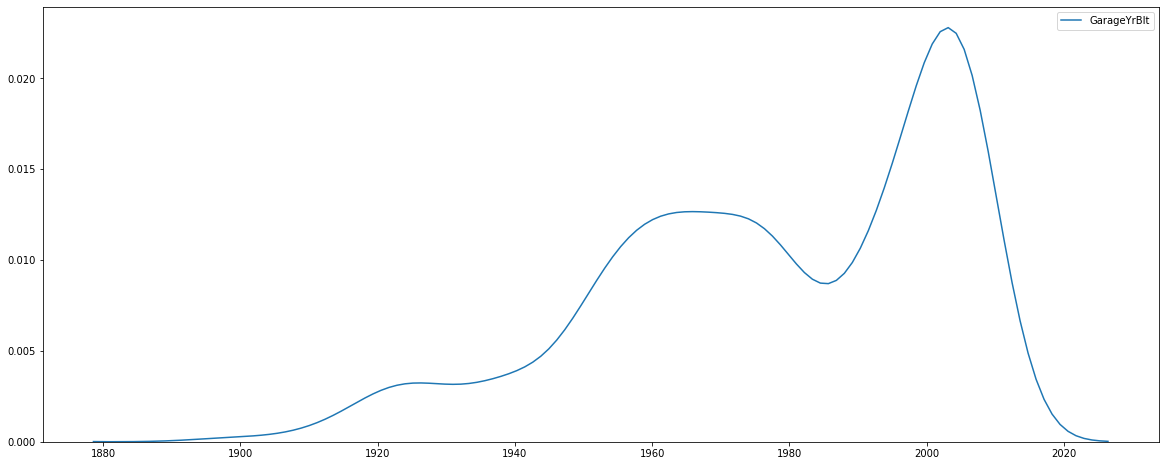

In [57]:
plt.figure(figsize=(20,8))
sns.kdeplot(df['GarageYrBlt'][df['GarageYrBlt']!='NA'])

In [58]:
df[df['GarageYrBlt']!='NA'][['GarageYrBlt']].sort_values(by='GarageYrBlt',ascending=False).tail()

GarageYrBlt
1527        1900
1853        1900
2247        1900
1599        1896
2214        1895

In [59]:
df[df['GarageYrBlt']!='NA'][['GarageYrBlt']].sort_values(by='GarageYrBlt',ascending=False).head()

GarageYrBlt
818         2010
378         2010
1499        2010
1605        2010
985         2010

In [60]:
# Transforming into a categorical feature by using bins to categorize the values
bins = [1890, 1920, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2011]
labels = ['-1920', '1920-1940', '1940-1950', '1950-1960', '1960-1970',
         '1970-1980', '1980-1990', '1990-2000', '2000+']

df['GarageYrBlt'][df["GarageYrBlt"] != 'NA'] = pd.cut(df['GarageYrBlt'][df["GarageYrBlt"] != 'NA'], 
                                                             bins, 
                                                             labels=labels)

In [61]:
df['GarageYrBlt'] = df['GarageYrBlt'].astype(str)

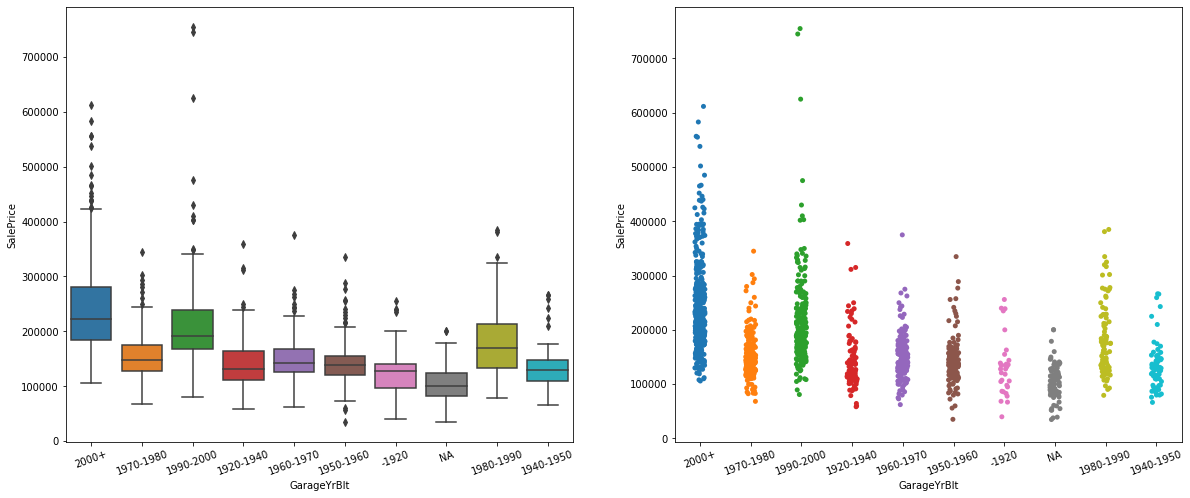

In [62]:
make_discrete_plot("GarageYrBlt",20,20)

### YearRemodAdd

> Remodel date (same as construction date if no remodeling or additions).

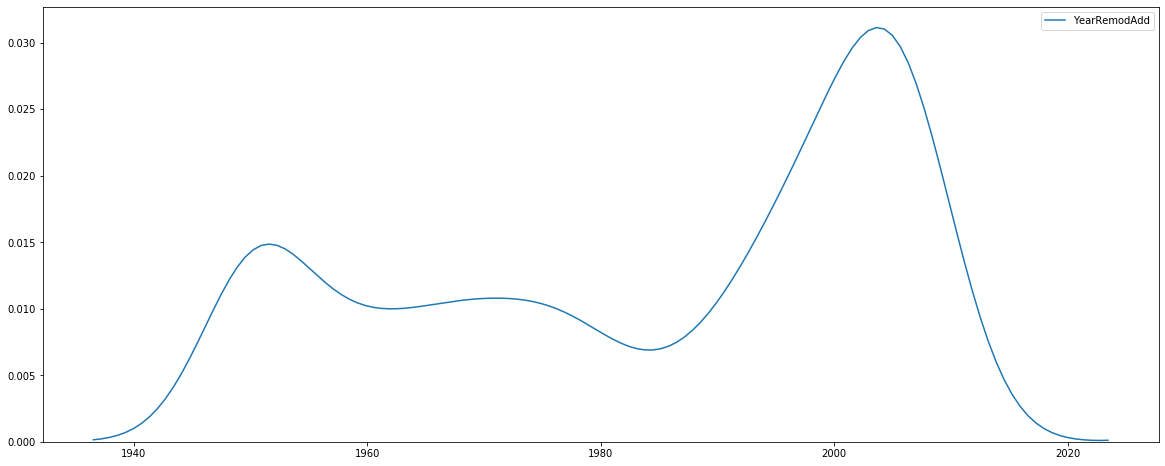

In [63]:
plt.figure(figsize=(20,8))
sns.kdeplot(df["YearRemodAdd"])
plt.show()

In [64]:
df[['YearRemodAdd']].sort_values(by='YearRemodAdd',ascending=False).head()

YearRemodAdd
1473          2010
985           2010
378           2010
1472          2010
1605          2010

In [65]:
df[['YearRemodAdd']].sort_values(by='YearRemodAdd',ascending=False).tail()

YearRemodAdd
873           1950
872           1950
867           1950
851           1950
1409          1950

In [66]:
# There is no impossible or impropable values in this feature,
# Simillar to the GarageYrBuild we will be seperating the data into categorical data by using bins
bins = [1949, 1960, 1970, 1980, 1990, 2000, 2011]
labels = ['-1960', '1960-1970',
         '1970-1980', '1980-1990', '1990-2000', '2000+']

df['YearRemodAdd'] = pd.cut(df['YearRemodAdd'], bins, labels=labels)

In [67]:
df['YearRemodAdd'] = df['YearRemodAdd'].astype(str)

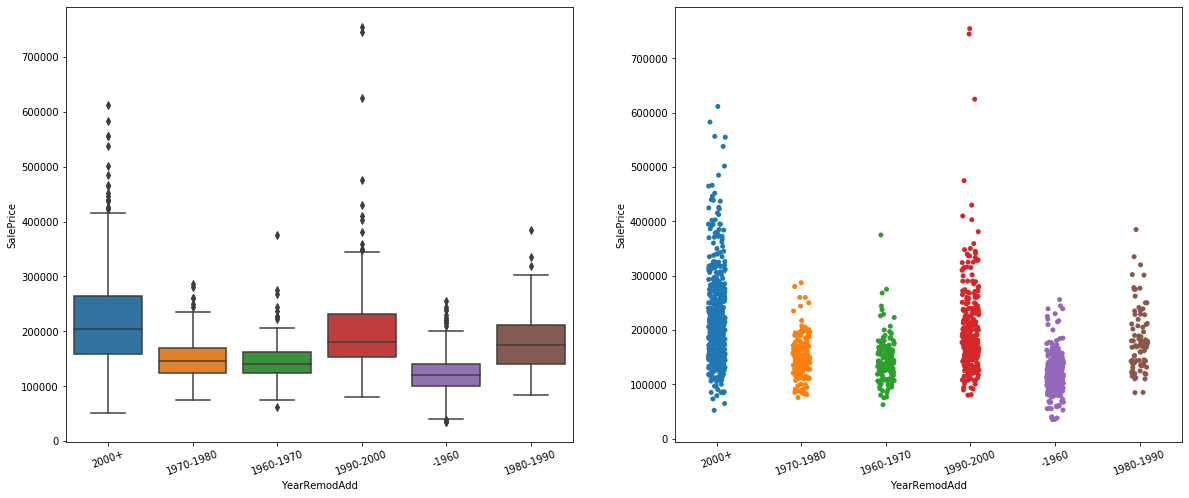

In [68]:
make_discrete_plot("YearRemodAdd",20,20)

### YearBuilt

> Original construction date.

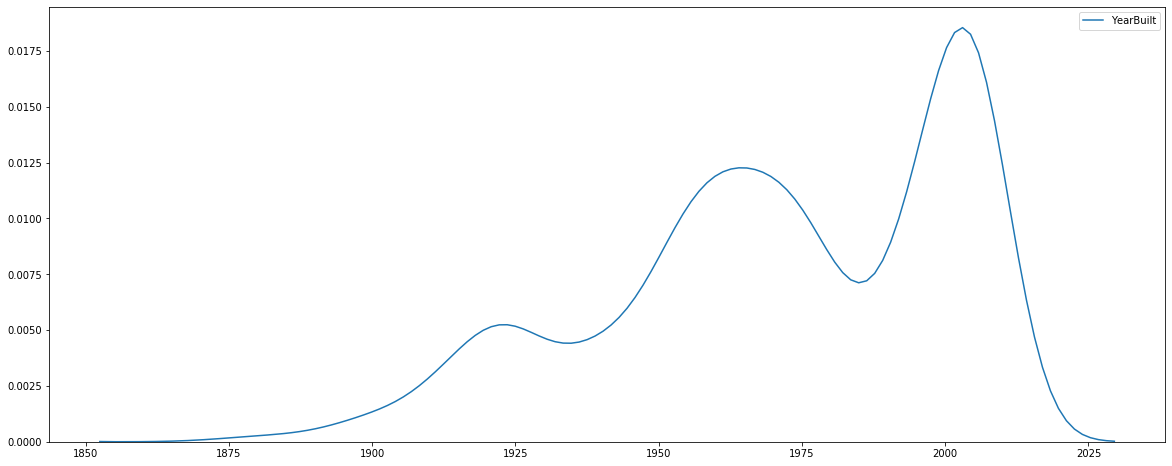

In [69]:
plt.figure(figsize=(20,8))
sns.kdeplot(df["YearBuilt"][df["YearBuilt"] != 'NA'])
plt.show()

In [70]:
df[['YearBuilt']][df["YearBuilt"] != 'NA'].sort_values(by='YearBuilt',ascending=False).head()

YearBuilt
1573       2010
1499       2010
378        2010
103        2009
818        2009

In [71]:
df[['YearBuilt']][df["YearBuilt"] != 'NA'].sort_values(by='YearBuilt',ascending=False).tail()

YearBuilt
304        1880
746        1880
2448       1879
1135       1875
1346       1872

In [72]:
# Same as before, we will be spliting this feature into categorical data
bins = [1870, 1920, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2011]
labels = ['-1920', '1920-1940', '1940-1950', '1950-1960', '1960-1970',
         '1970-1980', '1980-1990', '1990-2000', '2000+']

df['YearBuilt'] = pd.cut(df['YearBuilt'], bins, labels=labels)

In [73]:
df['YearBuilt'] = df['YearBuilt'].astype(str)

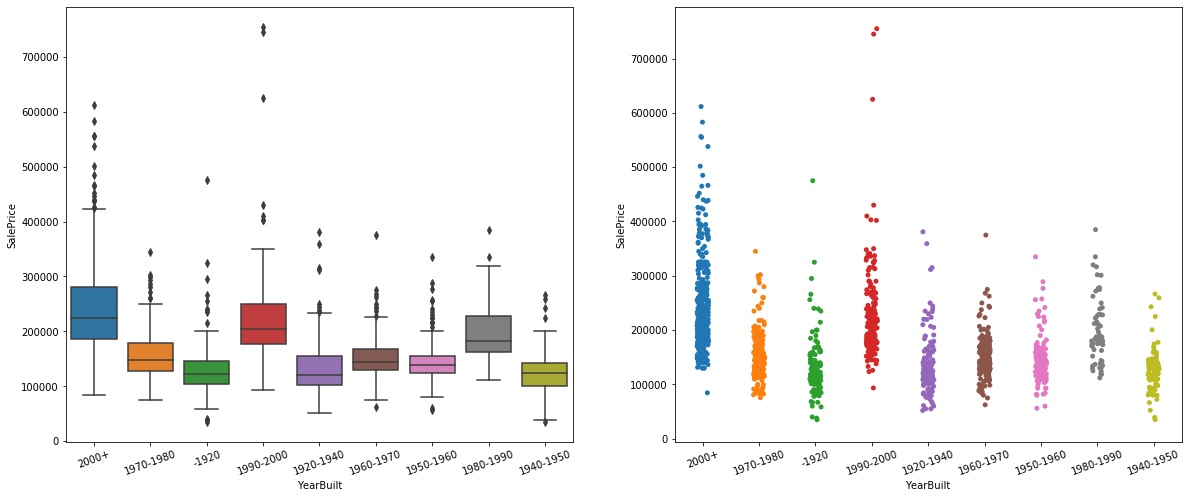

In [74]:
make_discrete_plot("YearBuilt",20,20)

### YrSold

> Year Sold (YYYY).

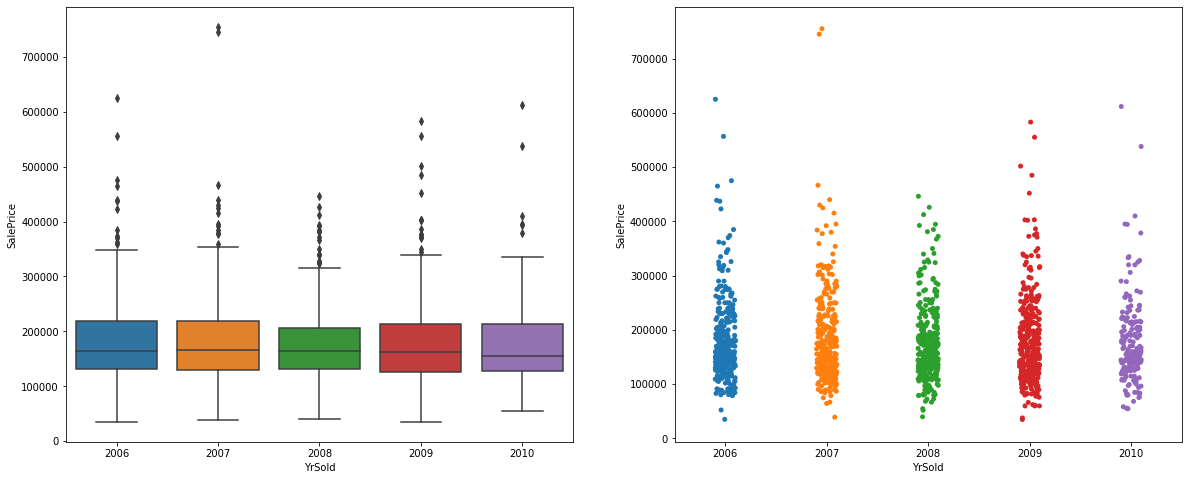

In [75]:
make_discrete_plot("YrSold",0,0)

In [76]:
# Seems that there is no strong pattern, therefore changing this data into categorical
df['YrSold'] = df['YrSold'].astype(str)

### MoSold

> Month Sold (MM).

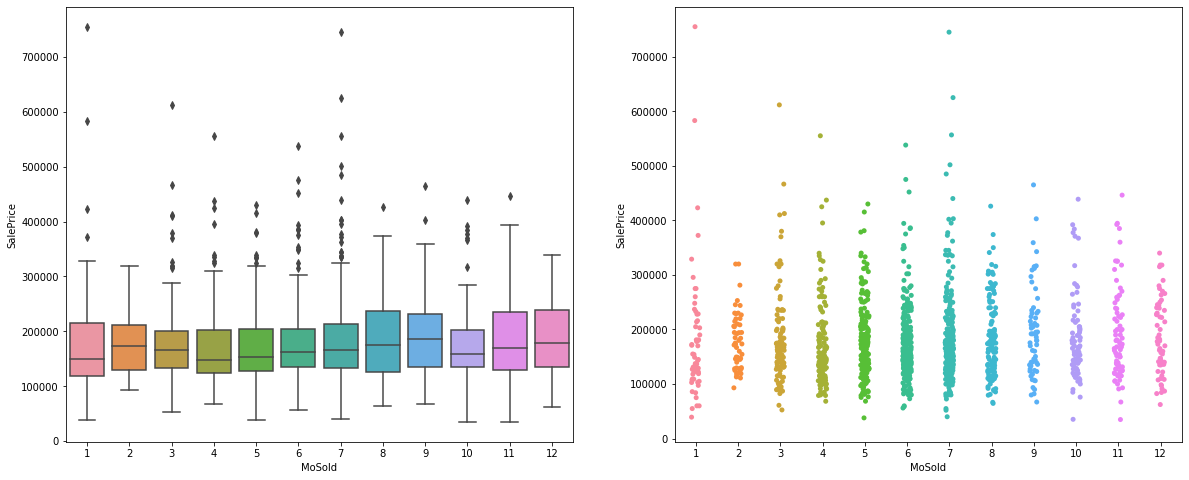

In [77]:
make_discrete_plot("MoSold",0,0)

In [78]:
# Seems that there is no strong pattern, therefore changing this data into categorical
df.MoSold = df.MoSold.astype(str)

## Continuous Variables

> For continuous variable we will observe the correlation and skewness of every feature with coresspondance to the SalePrice, we would be using to compare linear and boxcox transofrmations (with the optimal lambda using boxcox_normax to reduce repetitiveness finding the optimal lambda). If it is observed that there is a very small correlation, the continous data will be split into categorical data using the binning method

<center><h1>Box Cox Formula</h1></center>
<br>
<br>
    
<img src="https://www.statisticshowto.datasciencecentral.com/wp-content/uploads/2015/07/boxcox-formula-1.png" />

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcS__9RTUOiehsmYBxEi-p20_1JogwDvcp3PzsoiLIX9ceMXy4mr"/>

In [79]:
print(num_continuous)

['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


In [80]:
def get_optimal_lambda(feature):
    optimal_lambda = boxcox_normmax(df[feature]+0.1)
    return optimal_lambda

In [81]:
# defining function to plot scatterplot for continuous variables with SalePrice.
def make_continuous_plot(feature):
    
    fig = plt.figure(figsize=(18,8))
    gs = GridSpec(1,2)
    
    optimal_lambda = get_optimal_lambda(feature)
    
    j = sns.scatterplot(y=np.log1p(df['SalePrice']), 
                        x=boxcox1p(df[feature], optimal_lambda), ax=fig.add_subplot(gs[0,1]), palette = 'blue')

    plt.title('BoxCox {}\n'.format(round(optimal_lambda,3)) + 'Corr: ' + str(np.round(np.log1p(df['SalePrice']).corr(boxcox1p(df[feature], optimal_lambda)),2)) + ', Skew: ' +
               str(np.round(stats.skew(boxcox1p(df[feature], optimal_lambda)),2)))
    
    
    j = sns.scatterplot(y=np.log1p(df['SalePrice']), 
                        x=df[feature], ax=fig.add_subplot(gs[0,0]), color = 'red')

    plt.title('Linear\n' + 'Corr: ' + str(np.round(np.log1p(df['SalePrice']).corr(df[feature]),2)) + ', Skew: ' + 
               str(np.round(stats.skew(df[feature]),2)))
    
    fig.show()

### LotFrontage

> Linear feet of street connected to property.

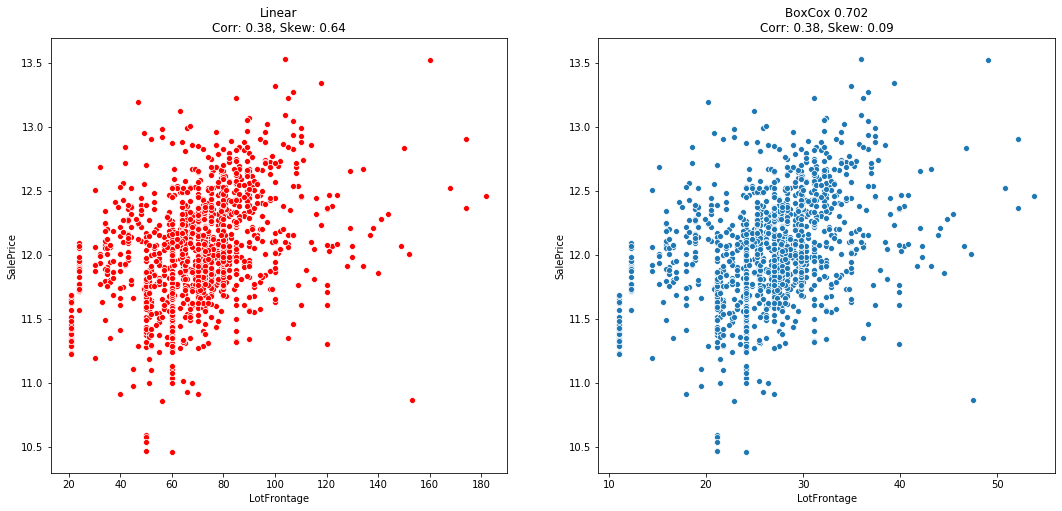

In [82]:
make_continuous_plot('LotFrontage')

In [83]:
df['LotFrontage'] = boxcox1p(df['LotFrontage'],get_optimal_lambda('LotFrontage'))

### LotArea

> Area of the Lot.

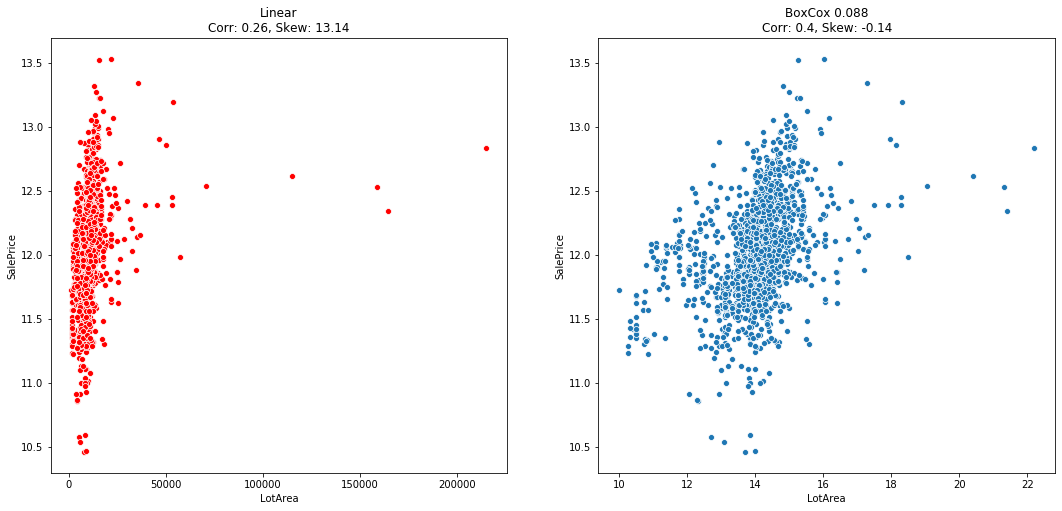

In [84]:
make_continuous_plot('LotArea')

In [85]:
df['LotArea'] = boxcox1p(df['LotArea'],get_optimal_lambda('LotArea'))

### MasVnrArea

> Masonry veneer area in square feet.

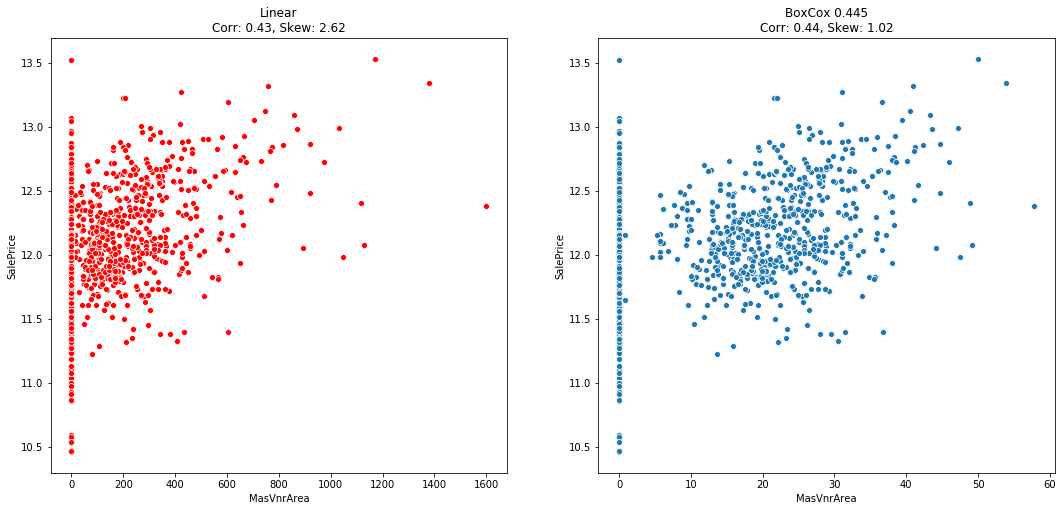

In [86]:
make_continuous_plot('MasVnrArea')

In [87]:
df['MasVnrArea'] = boxcox1p(df['MasVnrArea'],get_optimal_lambda('MasVnrArea'))

## TotalSF

> Create a new feature "TotalSF", which is the total square footage of the house 

>('TotalBsmtSF' + '1stFlrSF' + '2ndFlrSF')

In [88]:
df['TotalSF']=df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']


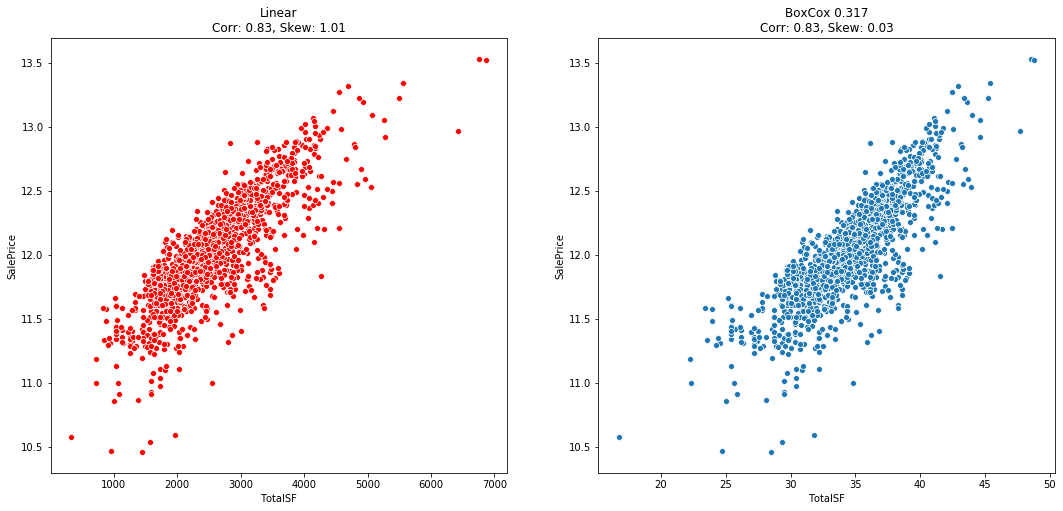

In [89]:
make_continuous_plot('TotalSF')

In [90]:
df['TotalSF'] = boxcox1p(df['TotalSF'],get_optimal_lambda('TotalSF'))

## TotalFinSF

> Create a new feature "TotalFinSF", which is the total finished square footage of the house 

>('BsmtFinSF1' + 'BsmtFinSF2' + '1stFlrSF' + '2ndFlrSF')

In [91]:
df['TotalFinSF'] = (df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['1stFlrSF'] + df['2ndFlrSF'])

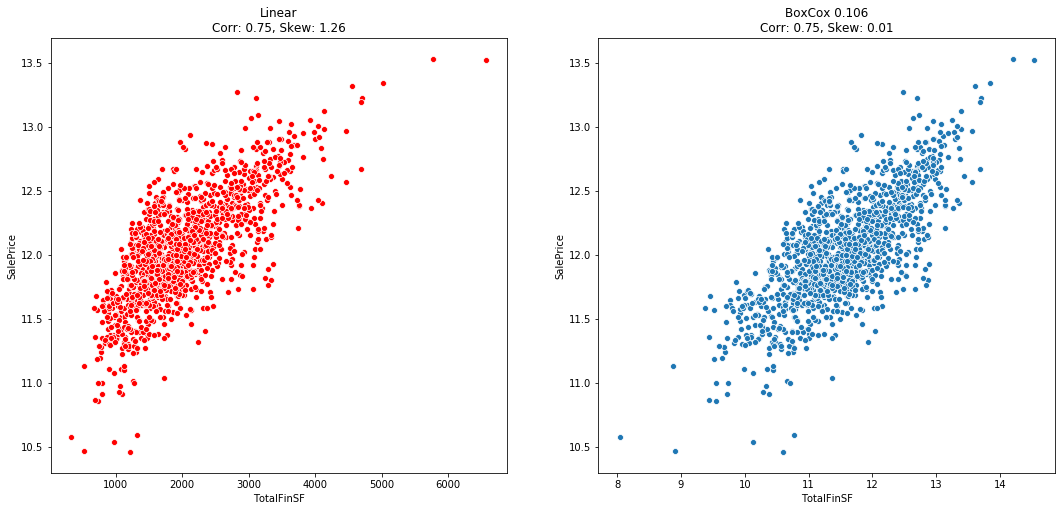

In [92]:
make_continuous_plot('TotalFinSF')

In [93]:
df['TotalFinSF'] = boxcox1p(df['TotalFinSF'],get_optimal_lambda('TotalFinSF'))

### BsmtFinSF1 and BsmtFinSF2

> Types 1 and 2 finished square feet.

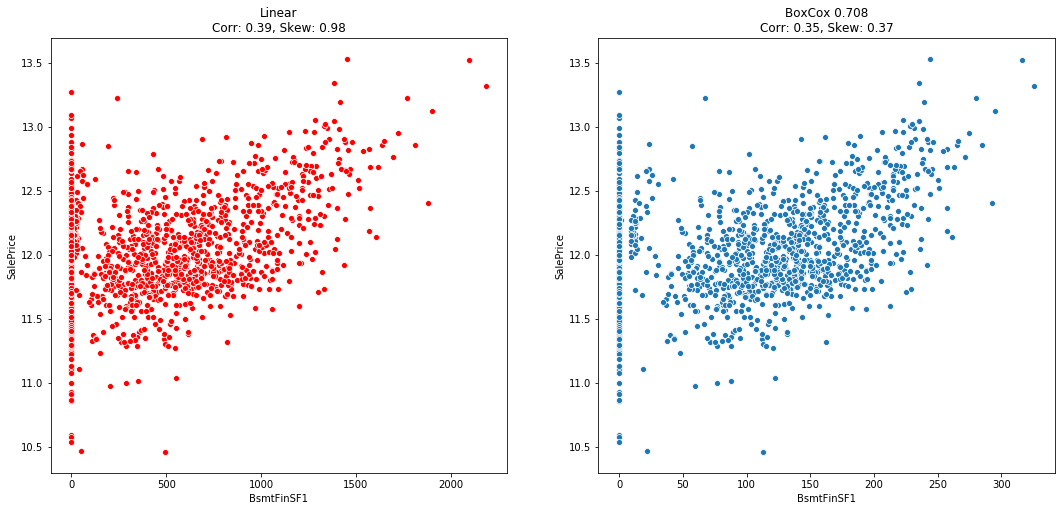

In [94]:
make_continuous_plot('BsmtFinSF1')

In [95]:
df['BsmtFinSF1'] = boxcox1p(df['BsmtFinSF1'],get_optimal_lambda('BsmtFinSF1'))

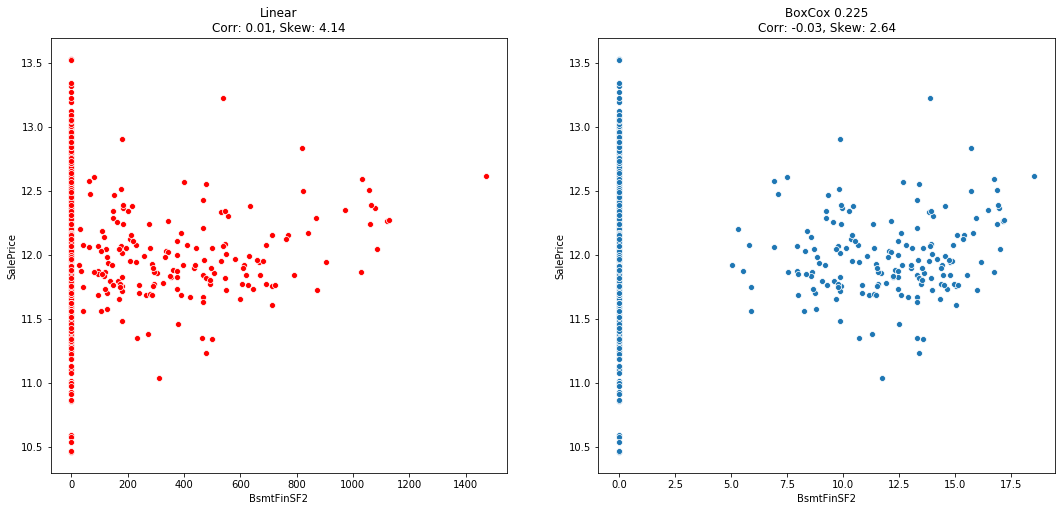

In [96]:
make_continuous_plot('BsmtFinSF2')

In [97]:
df['BsmtFinSF2'] = df['BsmtFinSF2'].apply(lambda x: 1 if x > 0 else 0)

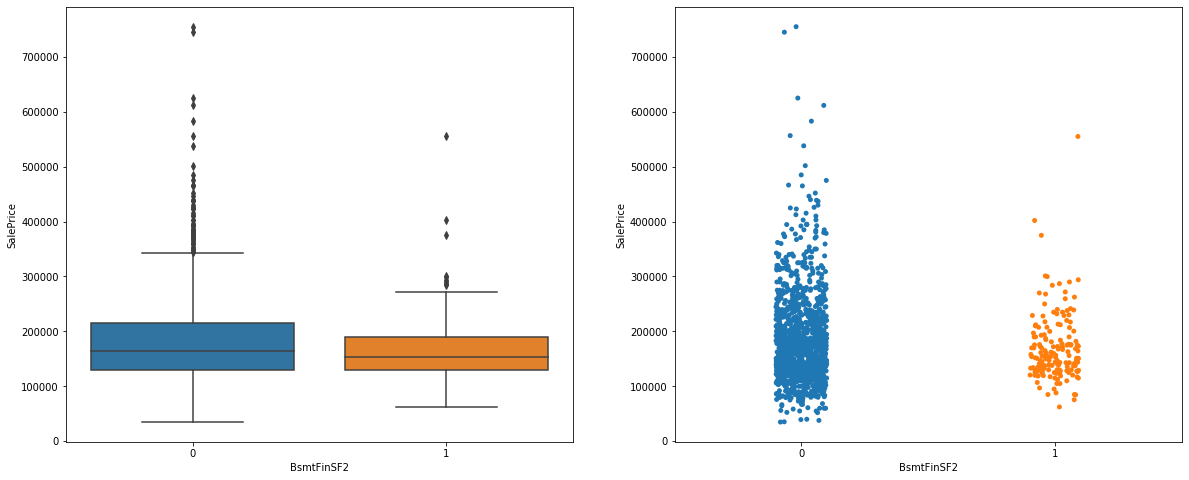

In [98]:
make_discrete_plot('BsmtFinSF2',0,0)

### BsmtUnfSF

> Unfinished square feet of basement area.

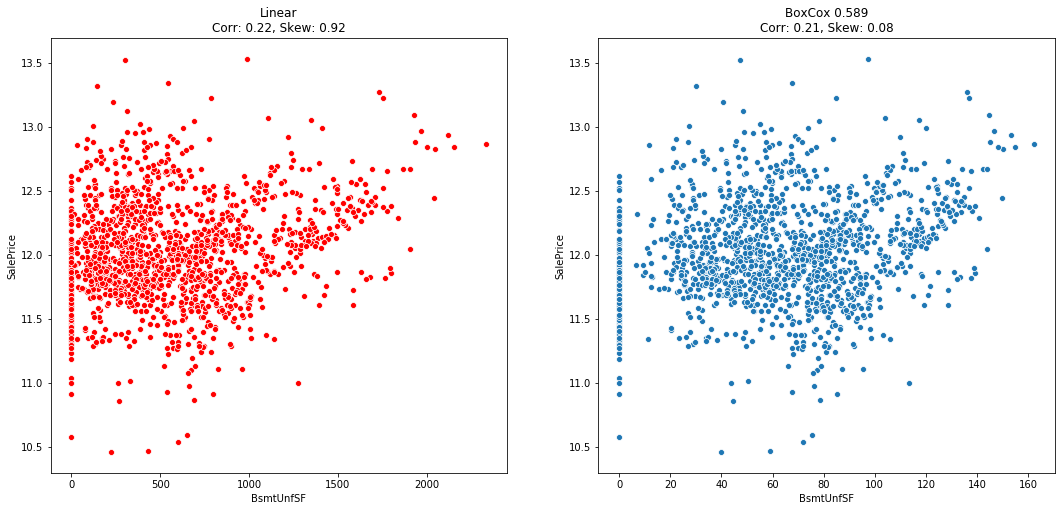

In [99]:
make_continuous_plot('BsmtUnfSF')

In [100]:
df['BsmtUnfSF'] = boxcox1p(df['BsmtUnfSF'],get_optimal_lambda('BsmtUnfSF'))

### TotalBsmtSF

> Total square feet of basement area.

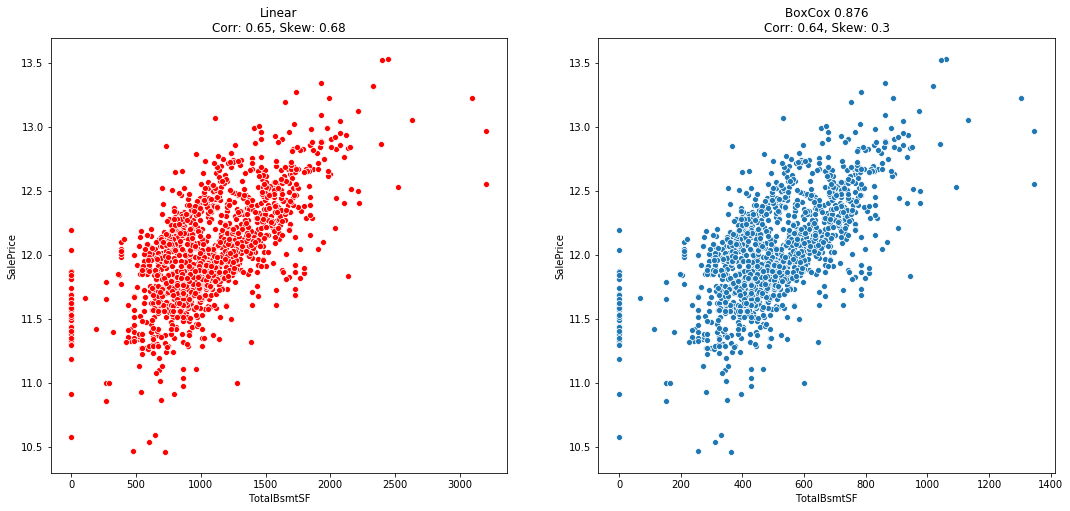

In [101]:
make_continuous_plot('TotalBsmtSF')

In [102]:
df['TotalBsmtSF'] = boxcox1p(df['TotalBsmtSF'],get_optimal_lambda('TotalBsmtSF'))

### 1stFlrSF and 2ndFlrSF

> First and Second Floors square feet.

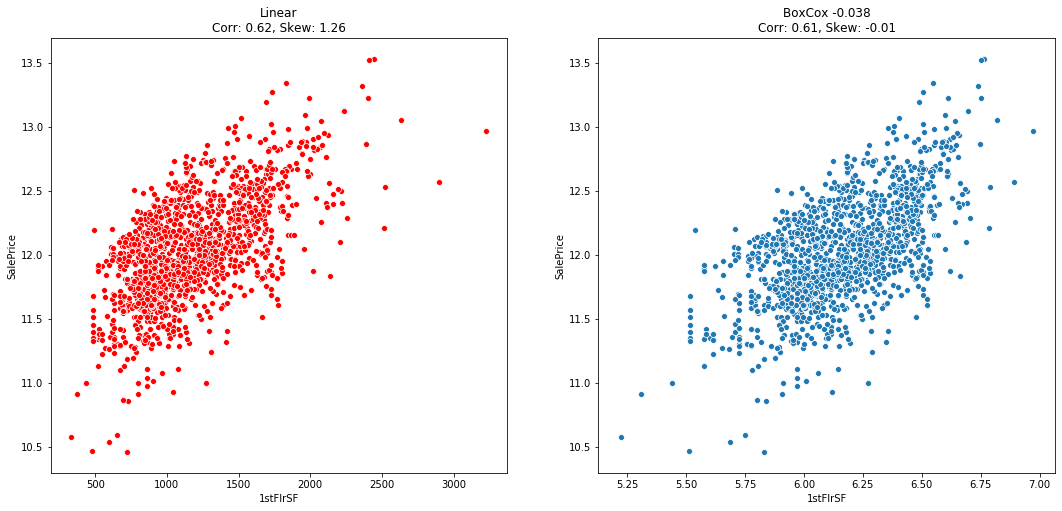

In [103]:
make_continuous_plot('1stFlrSF')

In [104]:
df['1stFlrSF'] = boxcox1p(df['1stFlrSF'],get_optimal_lambda('1stFlrSF'))

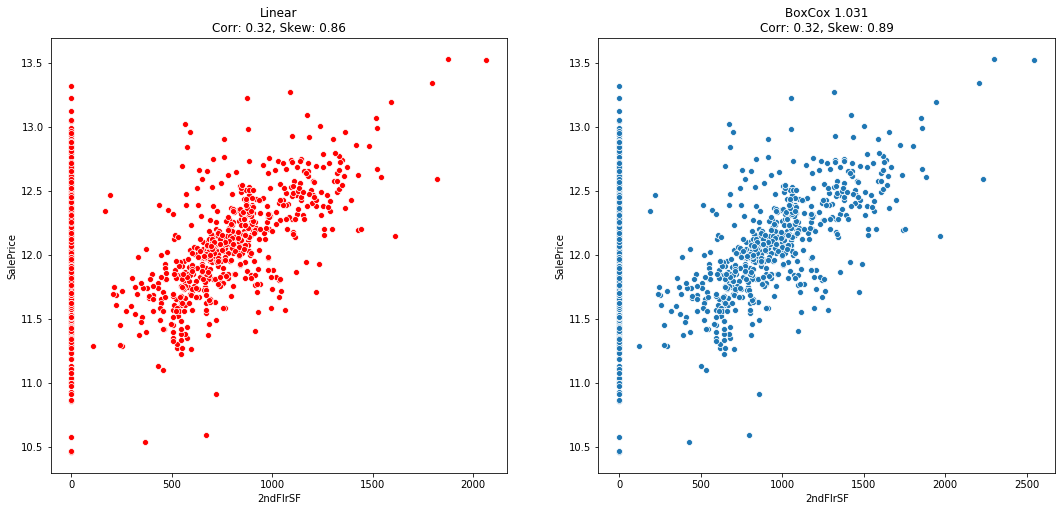

In [105]:
make_continuous_plot('2ndFlrSF')

In [111]:
# As using the box-cox transformation will further skew he data, we will leave the data as is

### LowQualFinSF

> Low quality finished square feet (all floors).

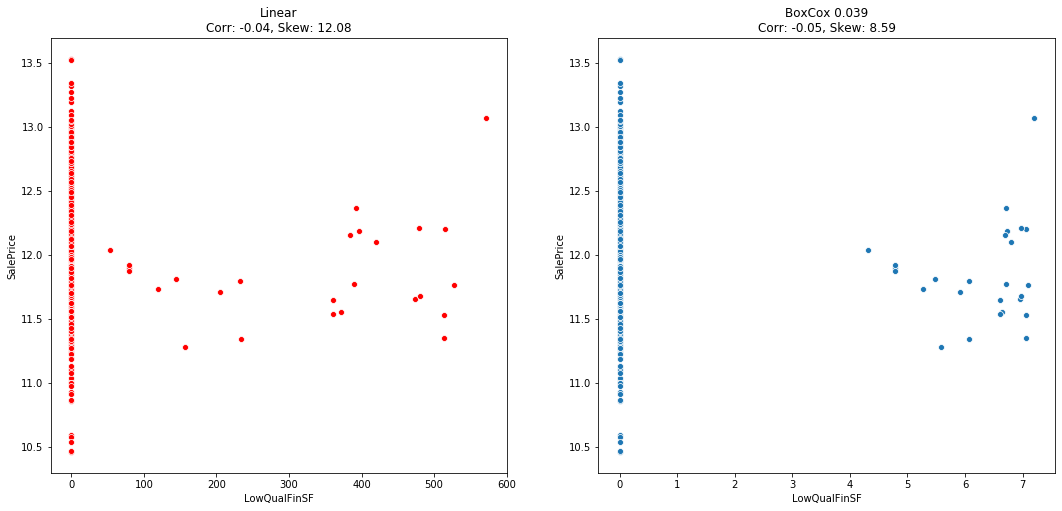

In [112]:
make_continuous_plot('LowQualFinSF')

In [113]:
# Since this feature has little to no correlation, we shall categorize this data 
df['LowQualFinSF'] = df['LowQualFinSF'].apply(lambda x: 1 if x > 0 else 0)

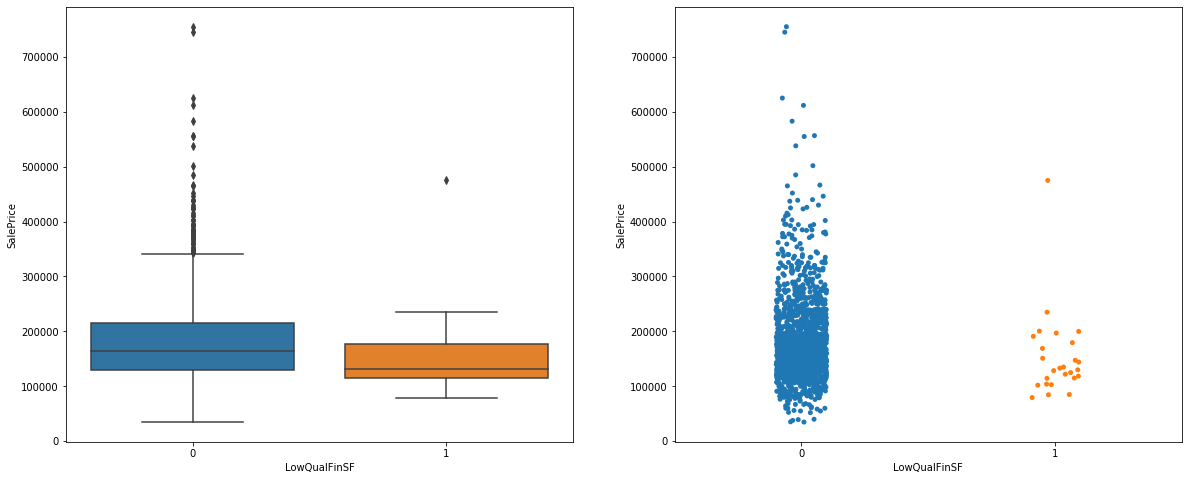

In [114]:
make_discrete_plot('LowQualFinSF',0,0)

### GrLivArea

> Above grade (ground) living area square feet.

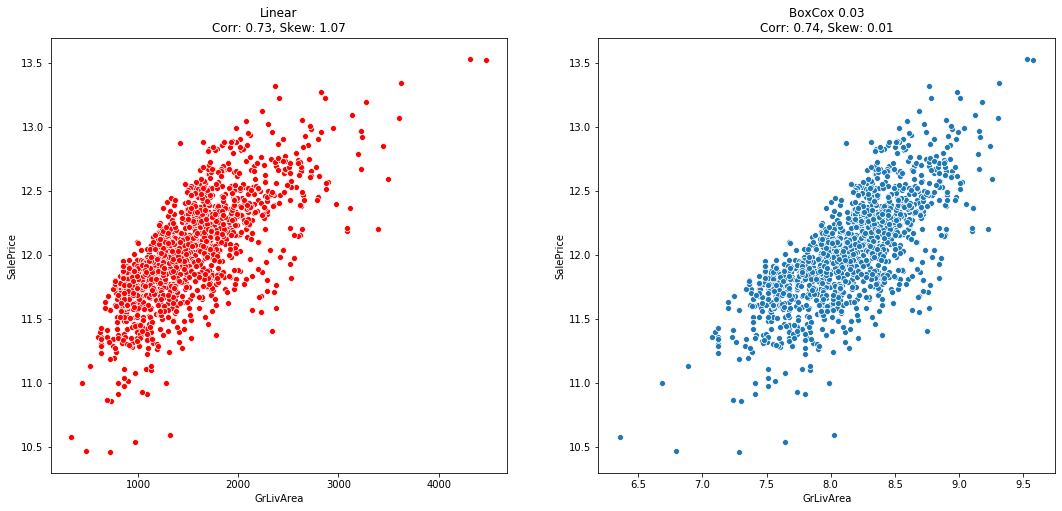

In [115]:
make_continuous_plot('GrLivArea')

In [116]:
df['GrLivArea'] = boxcox1p(df['GrLivArea'],get_optimal_lambda('GrLivArea'))

### GarageArea

> Area of the garage.

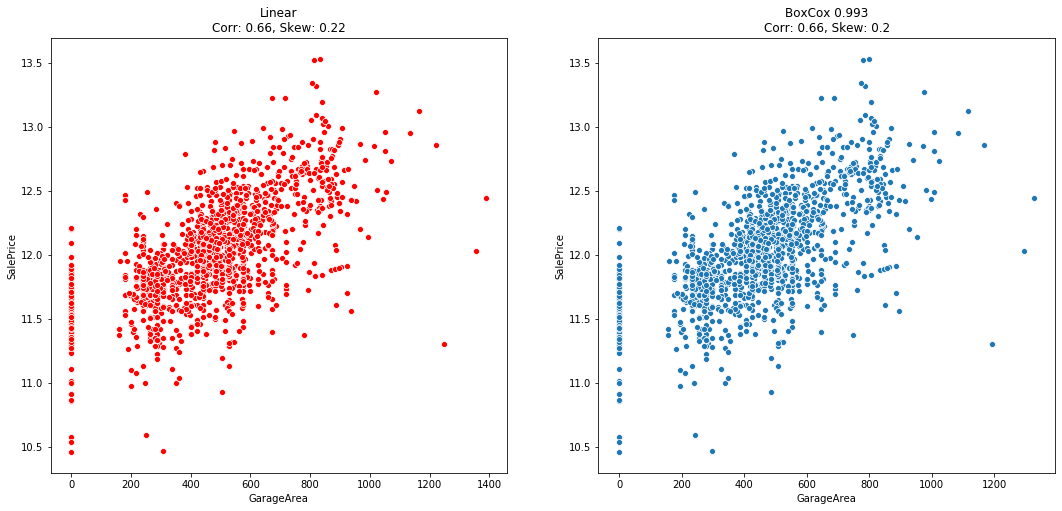

In [117]:
make_continuous_plot('GarageArea')

In [118]:
# As using the box-cox transformation will further skew he data, we will leave the data as is

### WoodDeckSF

> Wood deck area in square feet.

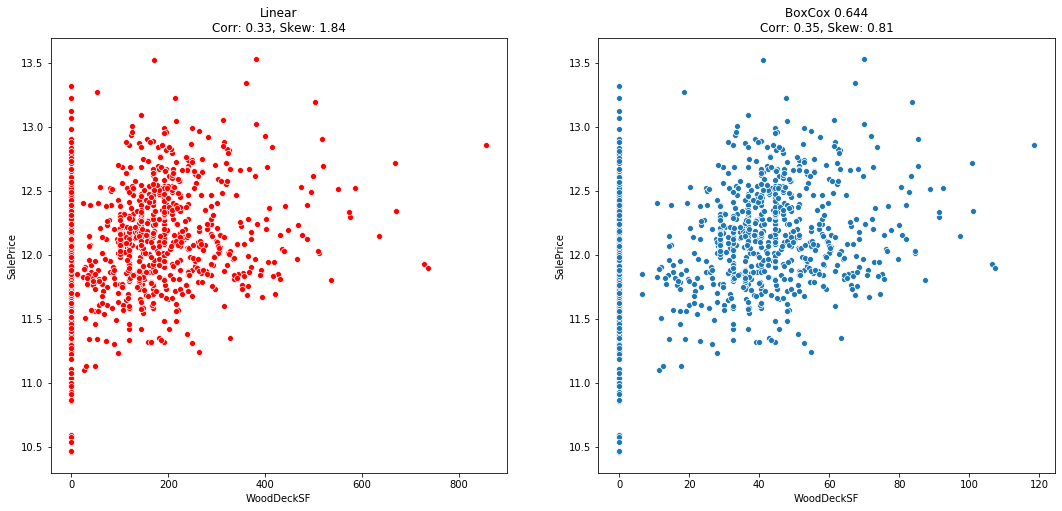

In [119]:
make_continuous_plot('WoodDeckSF')

In [120]:
df['WoodDeckSF'] = boxcox1p(df['WoodDeckSF'],get_optimal_lambda('WoodDeckSF'))


### TotalPorchSF

> Creating a new feature TotalPorchSF which is the total square footage of the porch

>('OpenPorchSF' + '3SsnPorch' +'EnclosedPorch' + 'ScreenPorch')

In [134]:
df['TotalPorchSF'] = (df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'])

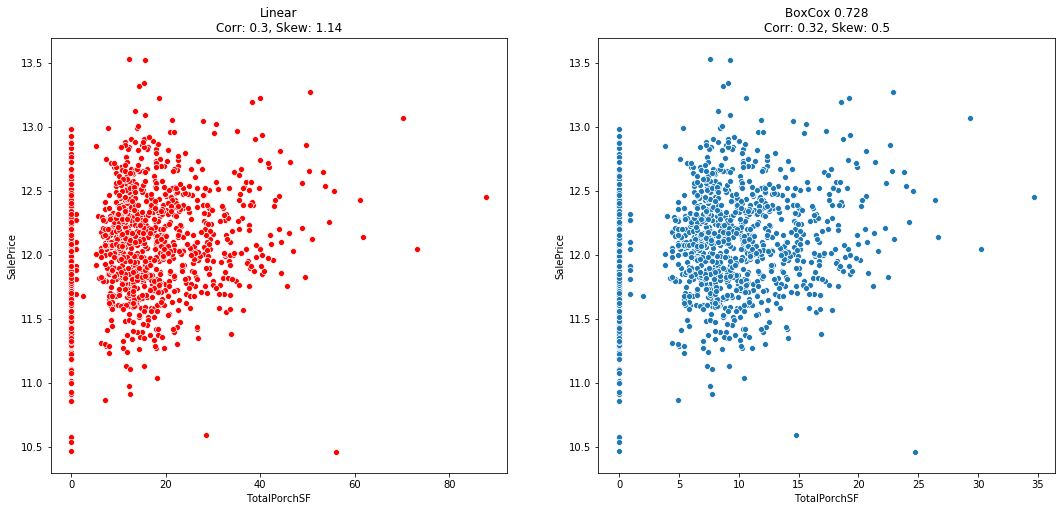

In [135]:
make_continuous_plot('TotalPorchSF')

In [136]:
df['TotalPorchSF'] = boxcox1p(df['TotalPorchSF'],get_optimal_lambda('TotalPorchSF'))

### OpenPorchSF

> Open porch area in square feet

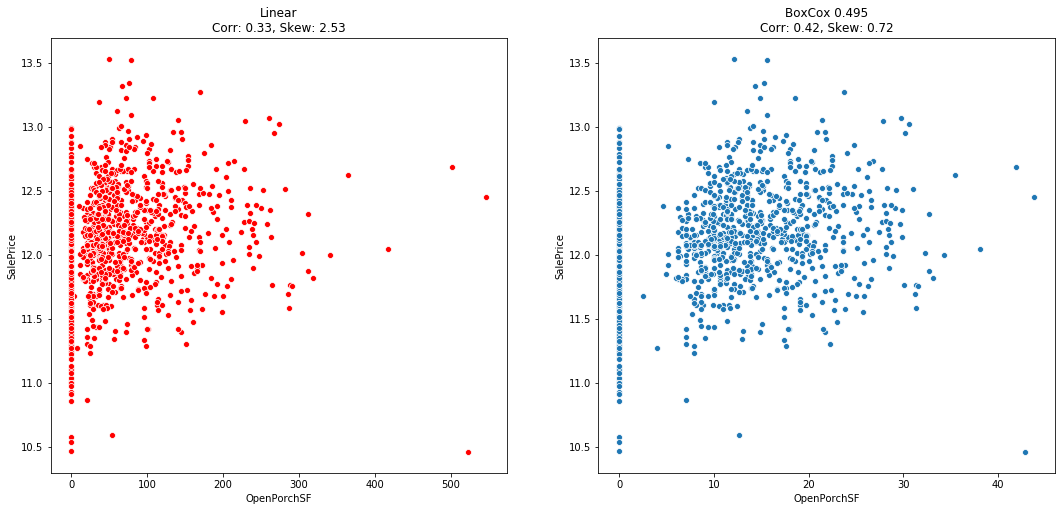

In [125]:
make_continuous_plot('OpenPorchSF')

In [126]:
df['OpenPorchSF'] = boxcox1p(df['OpenPorchSF'],get_optimal_lambda('OpenPorchSF'))


### EnclosedPorch

> Enclosed porch area in square feet

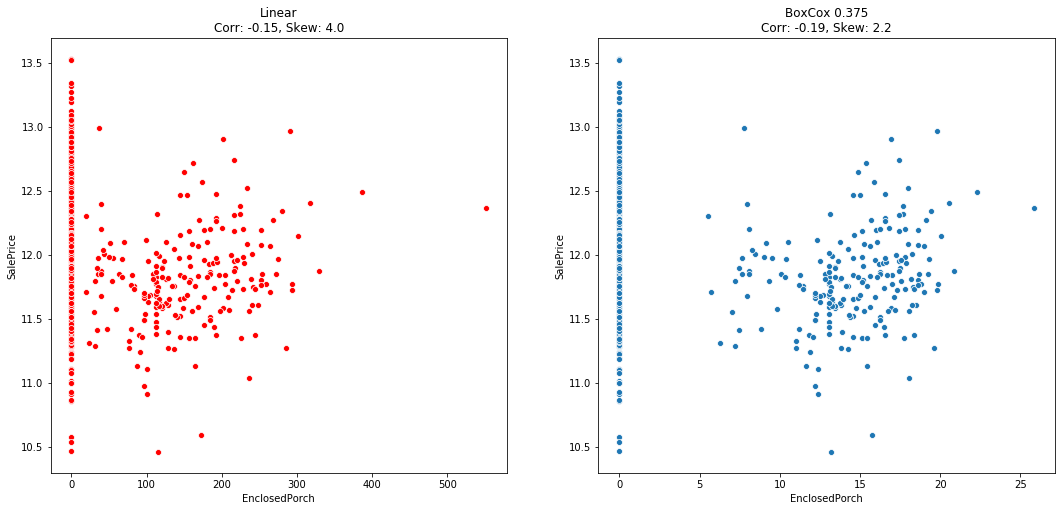

In [127]:
make_continuous_plot('EnclosedPorch')

In [128]:
df['EnclosedPorch'] = boxcox1p(df['EnclosedPorch'],get_optimal_lambda('EnclosedPorch'))


### 3SsnPorch

> Three season porch area in square feet

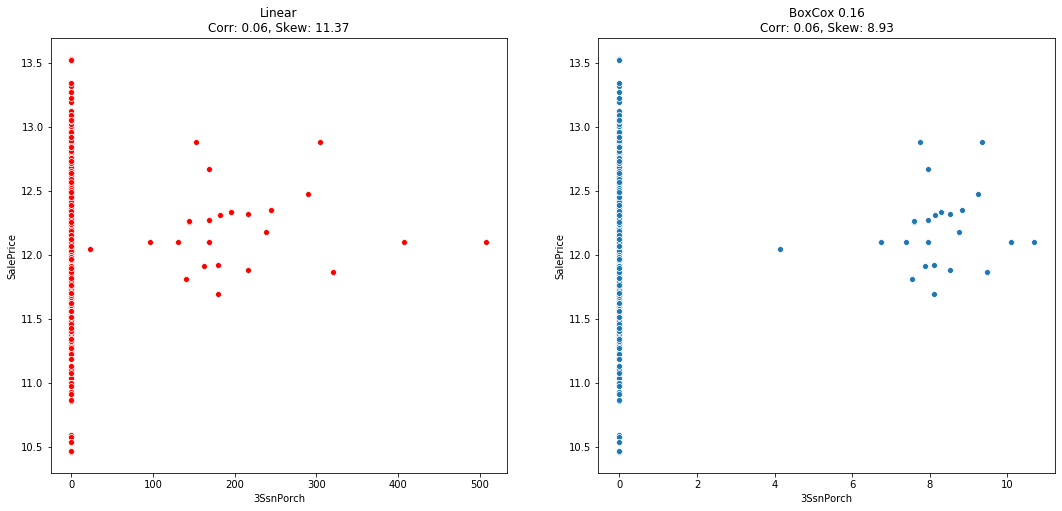

In [129]:
make_continuous_plot('3SsnPorch')

In [130]:
#Since there is little to no correlation, we shall categorize this data
df['3SsnPorch'] = df['3SsnPorch'].apply(lambda x: 1 if x > 0 else 0)

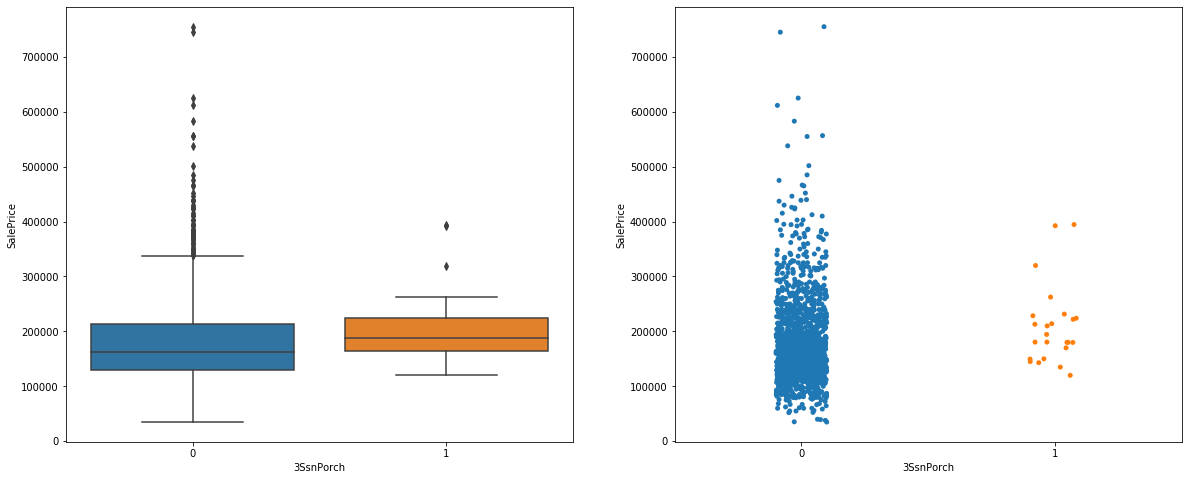

In [131]:
make_discrete_plot('3SsnPorch',0,0)

### ScreenPorch

> Screen porch area in square feet

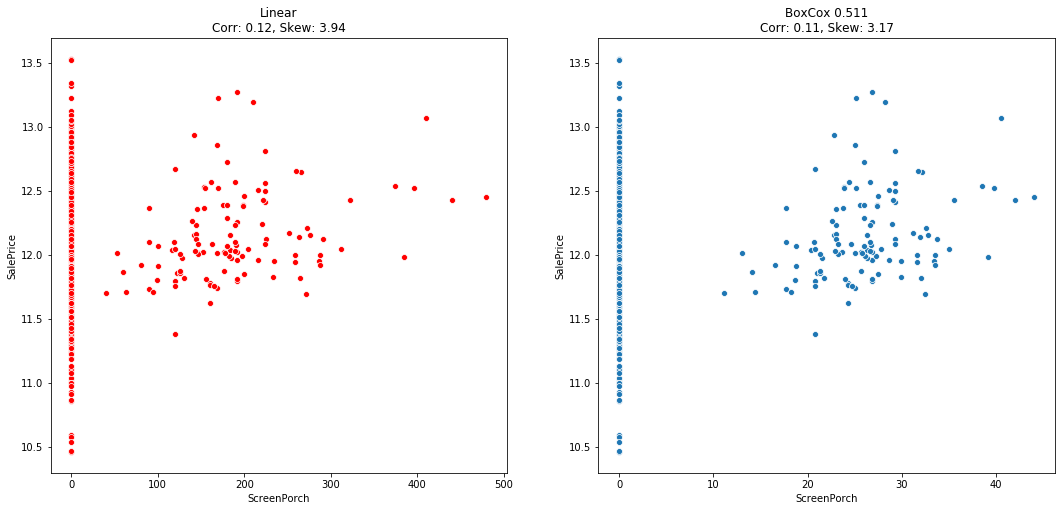

In [132]:
make_continuous_plot('ScreenPorch')

In [133]:
df['ScreenPorch'] = boxcox1p(df['ScreenPorch'],get_optimal_lambda('ScreenPorch'))


### PoolArea

> Pool area in square feet.

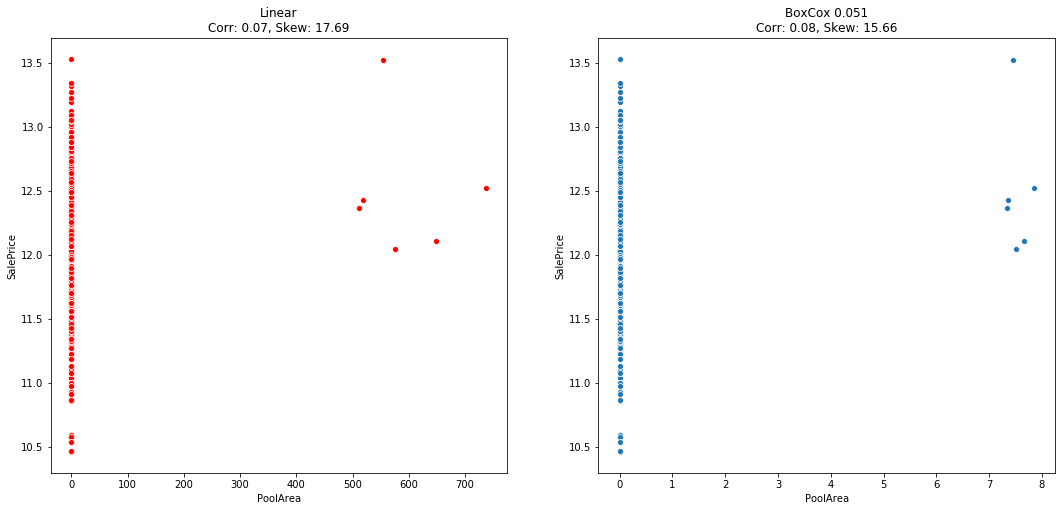

In [138]:
make_continuous_plot('PoolArea')

In [139]:
# since there is little to no correlation, we shall categorize this feature
df['PoolArea'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

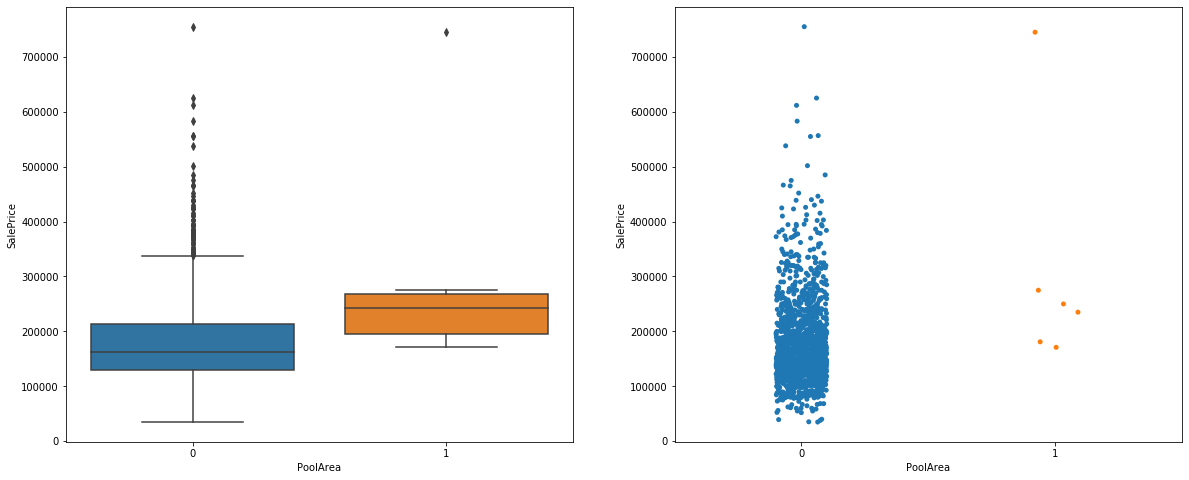

In [140]:
make_discrete_plot('PoolArea',0,0)

### MiscVal

> $Value of miscellaneous feature.

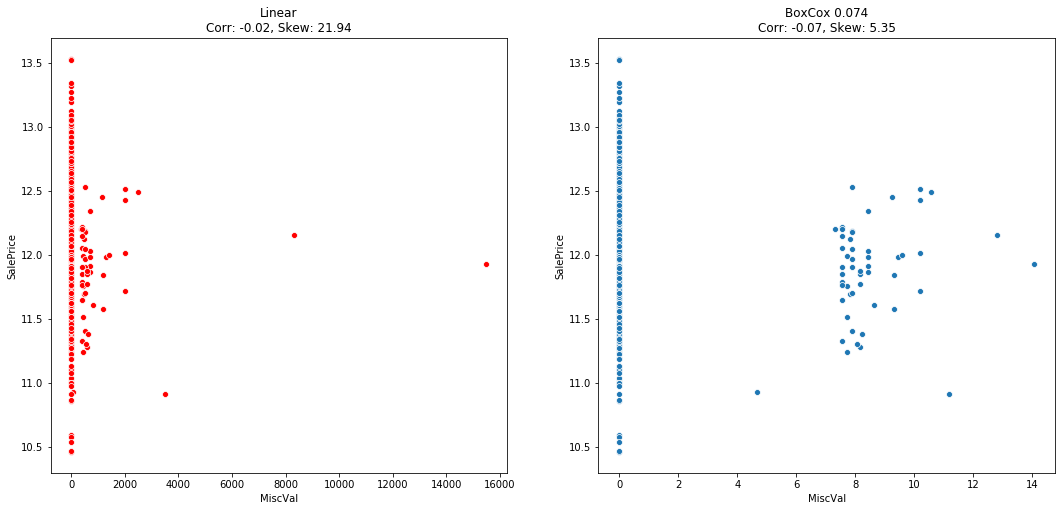

In [141]:
make_continuous_plot('MiscVal')

In [142]:
# since there is little to no correlation, we shall categorize this feature
df['MiscVal'] = df['MiscVal'].apply(lambda x: 1 if x > 0 else 0)

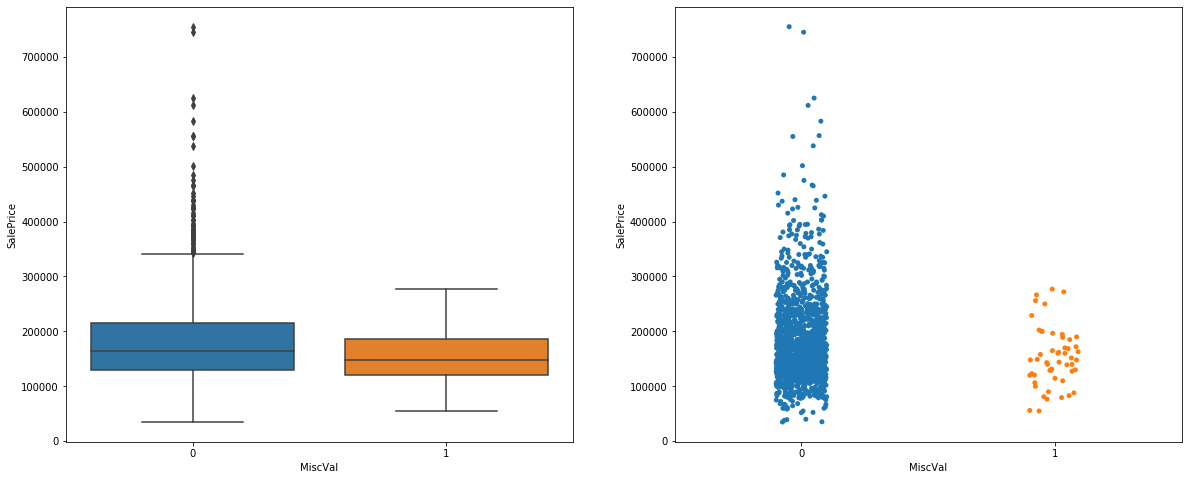

In [143]:
make_discrete_plot('MiscVal',0,0)

## Ordinal Variables

> Since ordinal variables has a hierarchy of quality we shall convert the string to numbers starting from 0 which represents the worst quality or NA and increases as the quality increases. After seeing the data and correlation using boxplots, the data might be left unchanged, altered, or the whole column is drop completely

In [144]:
print(cat_ordinal)

['LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence']


In [146]:
# list of unique data in each feature and its corresponding quality ranking

cat_ordinal_dict = {"PoolQC": {"NA": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},
         "Fence": {"NA": 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4},
         "FireplaceQu": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
         "GarageCond": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
         "GarageQual": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
         "GarageFinish": {"NA": 0, "Unf": 1, "RFn": 2, "Fin": 3},
         "BsmtExposure": {"NA": 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4},
         "BsmtCond": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
         "BsmtQual": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
         "BsmtFinType2": {"NA": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6},
         "BsmtFinType1": {"NA": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6},
         "Electrical": {"Mix": 0, "FuseP": 1, "FuseF": 2, "FuseA": 3, "SBrkr": 4},
         "Functional": {"Sal": 0, "Sev": 1, "Maj2": 2, "Maj1": 3, "Mod": 4, "Min2": 5, "Min1": 6, "Typ": 7},
         "KitchenQual": {"Po": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},
         "Utilities": {"ELO": 0, "NoSeWa": 1, "NoSewr": 2, "AllPub": 3},
         "LotShape": {"IR3": 0, "IR2": 1, "IR1": 2, "Reg": 3},
         "LandSlope": {"Sev": 0, "Mod": 1, "Gtl": 2},
         "ExterQual": {"Po": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},
         "ExterCond": {"Po": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},
         "HeatingQC": {"Po": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},
         "CentralAir": {"N": 0, "Y": 1},
         "FireplaceQu": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
         "PavedDrive": {"N": 0, "P": 1, "Y": 2}}

df.replace(cat_ordinal_dict, inplace=True)

In [152]:
df['BsmtCond'] = df['BsmtCond'].astype('int64')

In [153]:
df[cat_ordinal].dtypes

LotShape        int64
Utilities       int64
LandSlope       int64
OverallQual     int64
OverallCond     int64
ExterQual       int64
ExterCond       int64
BsmtQual        int64
BsmtCond        int64
BsmtExposure    int64
BsmtFinType1    int64
BsmtFinType2    int64
HeatingQC       int64
CentralAir      int64
Electrical      int64
KitchenQual     int64
Functional      int64
FireplaceQu     int64
GarageFinish    int64
GarageQual      int64
GarageCond      int64
PavedDrive      int64
PoolQC          int64
Fence           int64
dtype: object

### LotShape


> General shape of property.

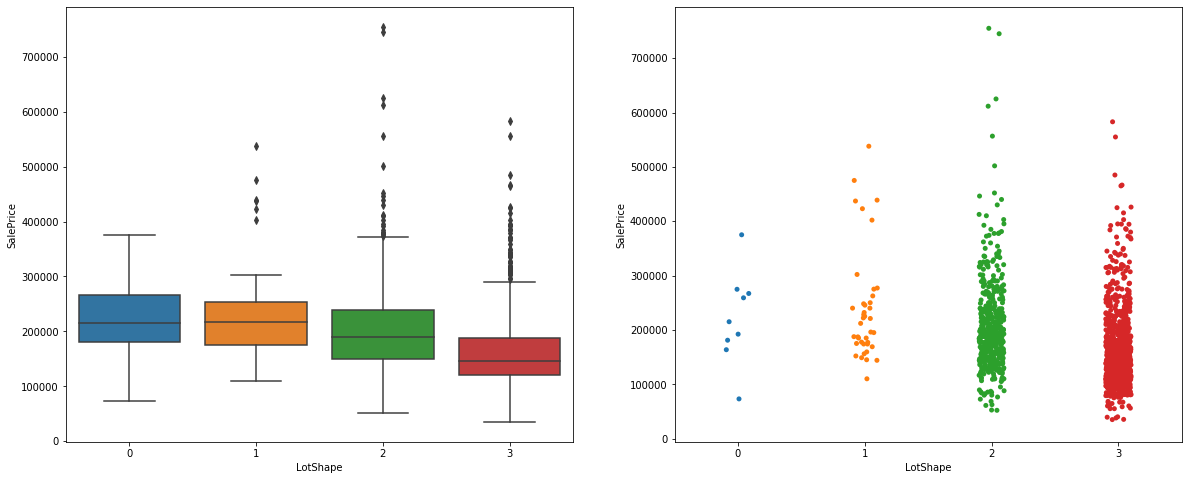

In [154]:
make_discrete_plot('LotShape',0,0)

In [155]:
# few values of 0, replacing them with 1
df['LotShape'] = df['LotShape'].apply(lambda x: 1 if x == 0 else x)

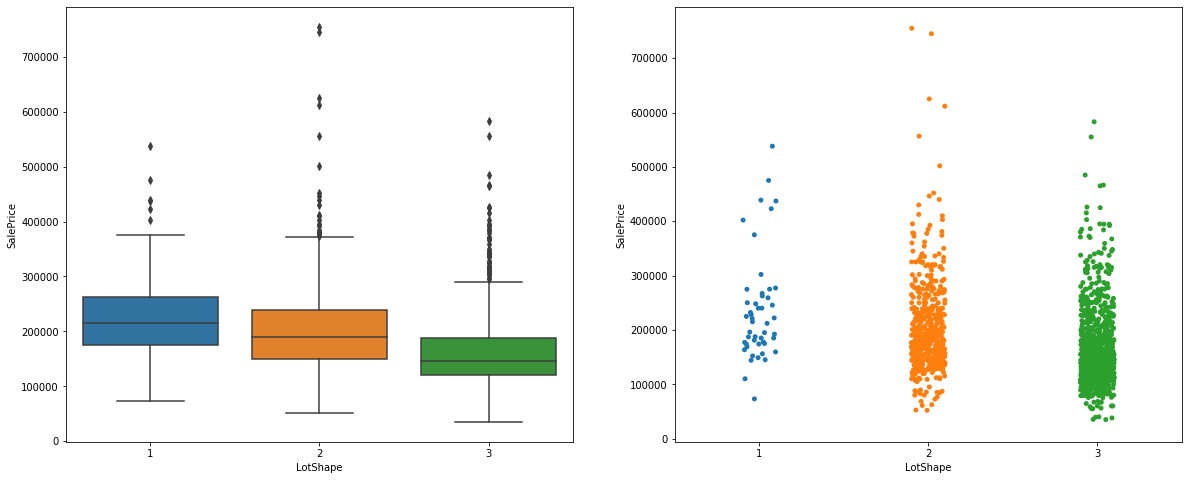

In [156]:
make_discrete_plot('LotShape',0,0)

### Utilities

> Type of utilities available.

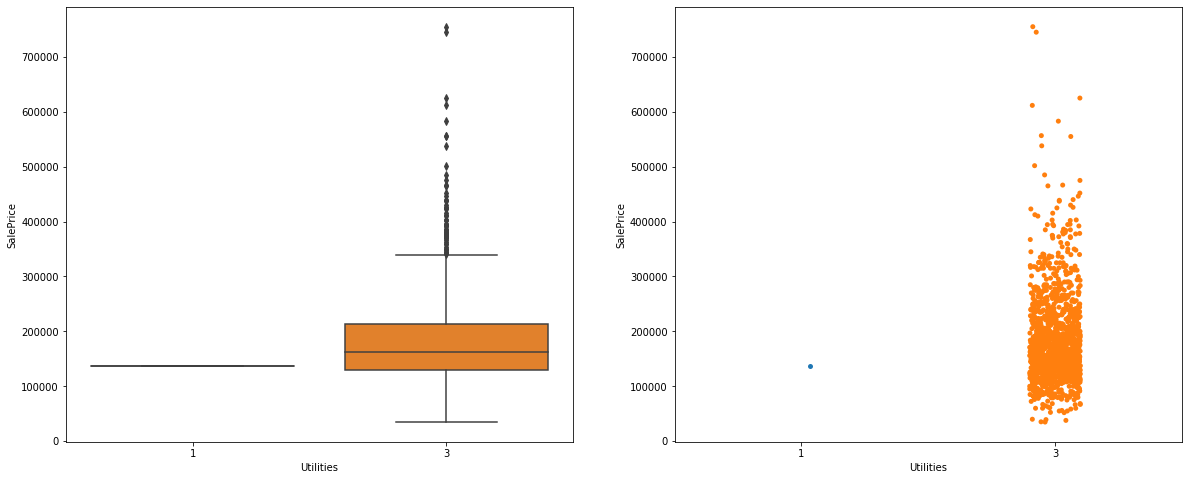

In [157]:
make_discrete_plot('Utilities',0,0)

In [158]:
# since there is only 2 categories and only 1 data in one of them, the column shall be dropped
df = df.drop('Utilities',axis=1)

### LandSlope


> Slope of property.

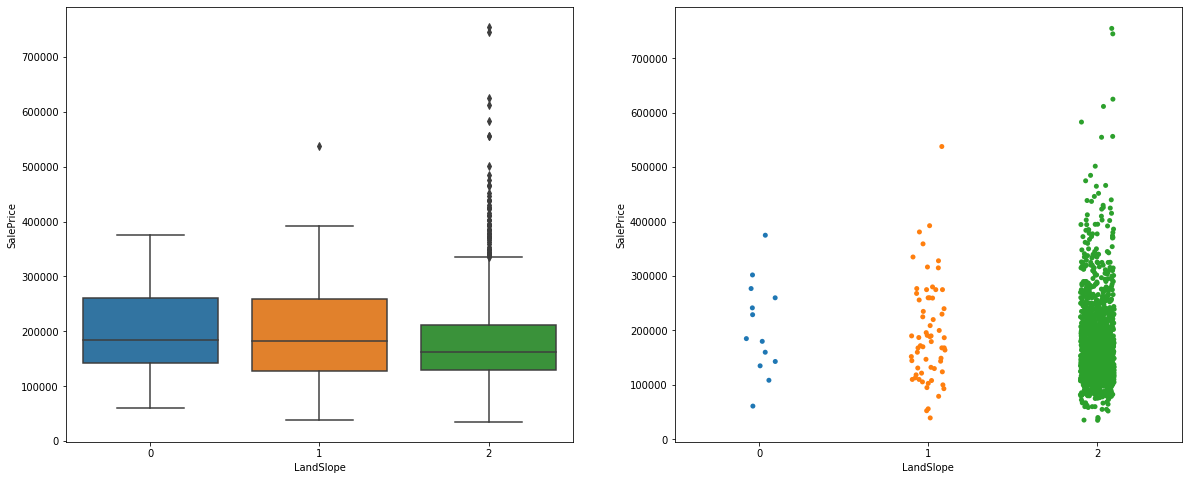

In [159]:
make_discrete_plot('LandSlope',0,0)

### OverallQual


> Rates the overall material and finish of the house.

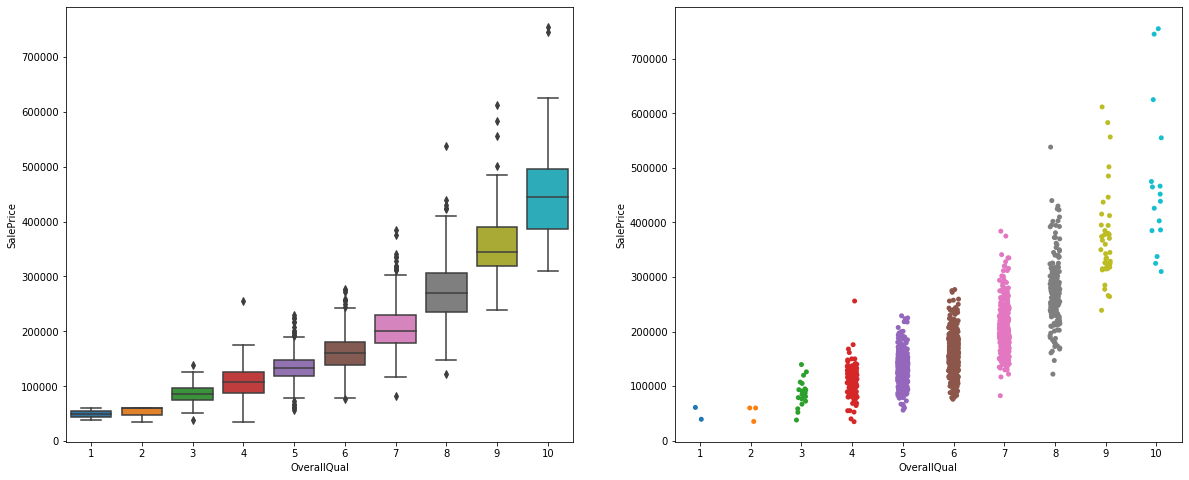

In [160]:
make_discrete_plot('OverallQual',0,0)

In [161]:
# only a few values that is < 2, replacing them with 3
df['OverallQual'] = df['OverallQual'].apply(lambda x: 3 if x<3 else x)

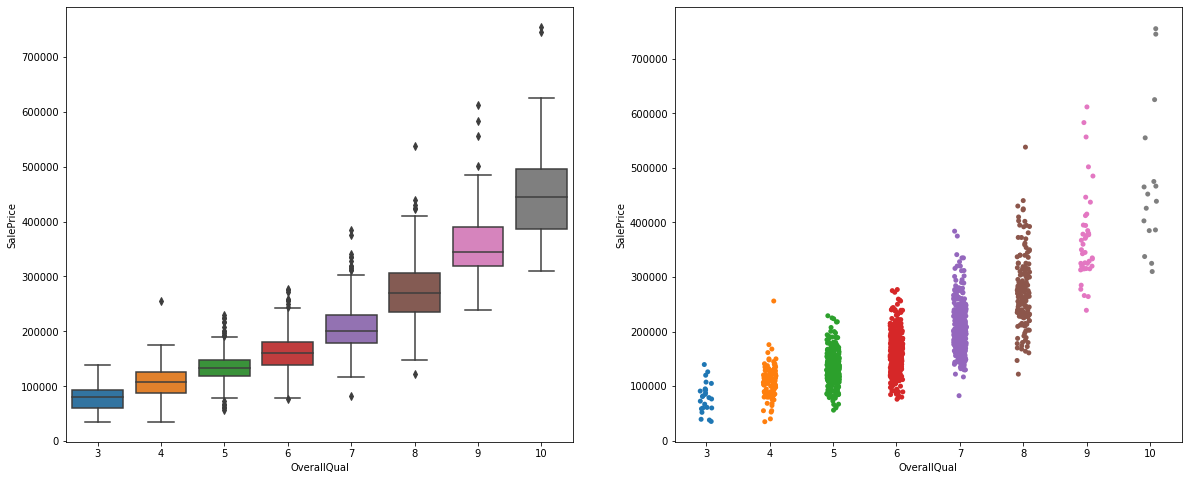

In [162]:
make_discrete_plot('OverallQual',0,0)

### OverallCond


> Rates the overall condition of the house.

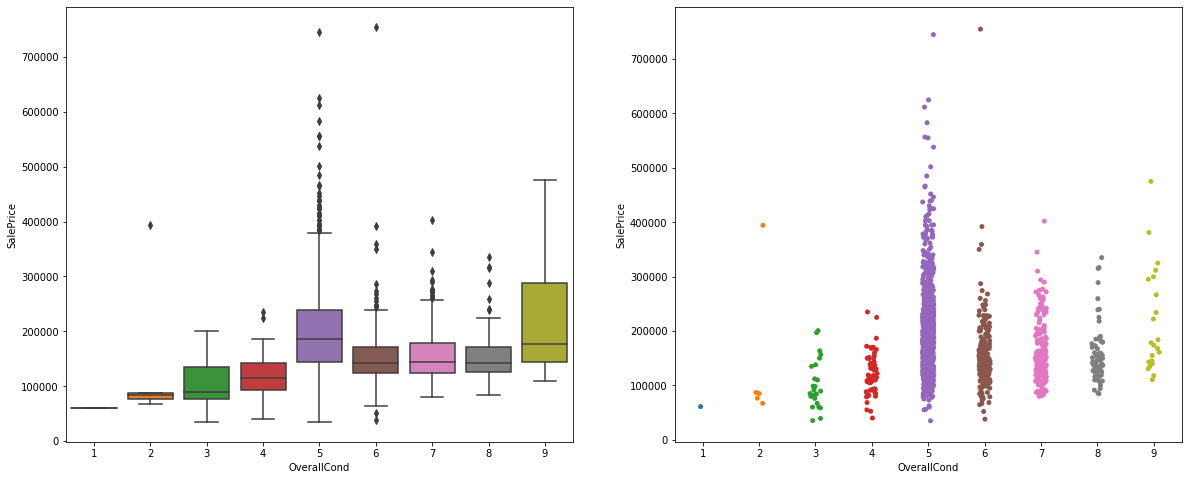

In [163]:
make_discrete_plot('OverallCond',0,0)

In [164]:
# few values that is < 3, replacing them with 3
df['OverallCond'] = df['OverallCond'].apply(lambda x: 3 if x < 3 else x)

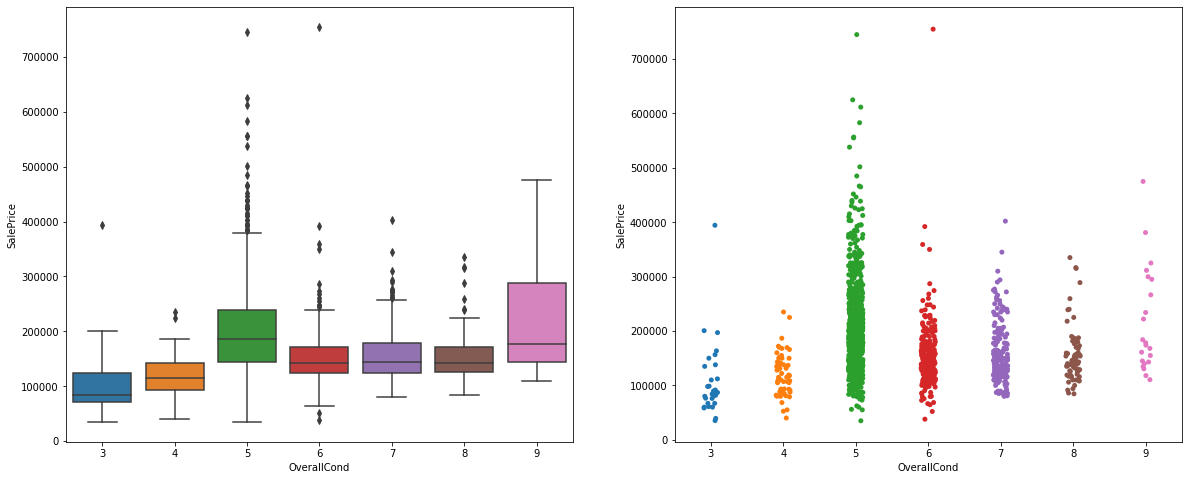

In [165]:
make_discrete_plot('OverallCond',0,0)

### ExterQual


> Evaluates the quality of the material on the exterior.

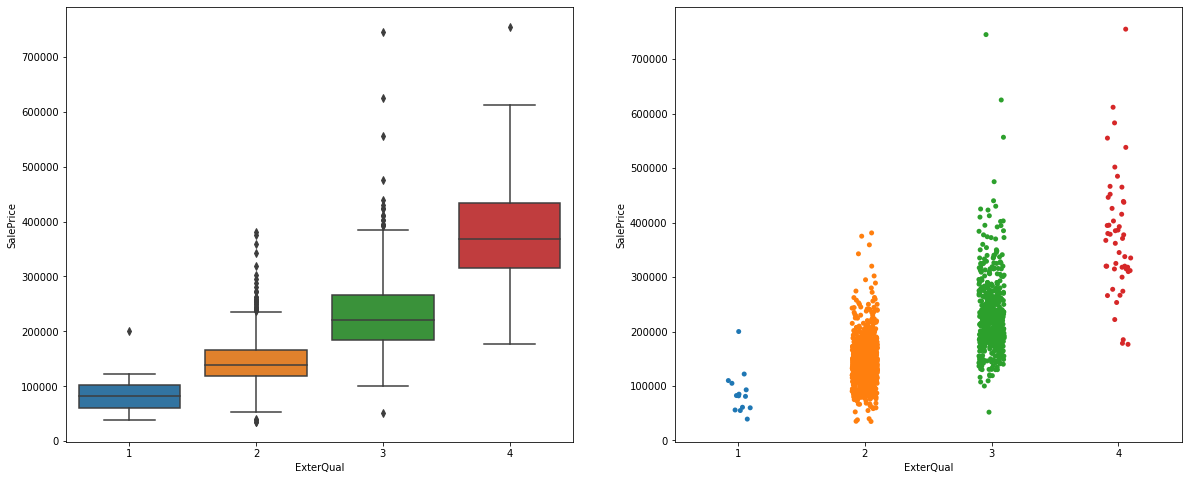

In [166]:
make_discrete_plot('ExterQual',0,0)

### ExterCond


> Evaluates the present condition of the material on the exterior.

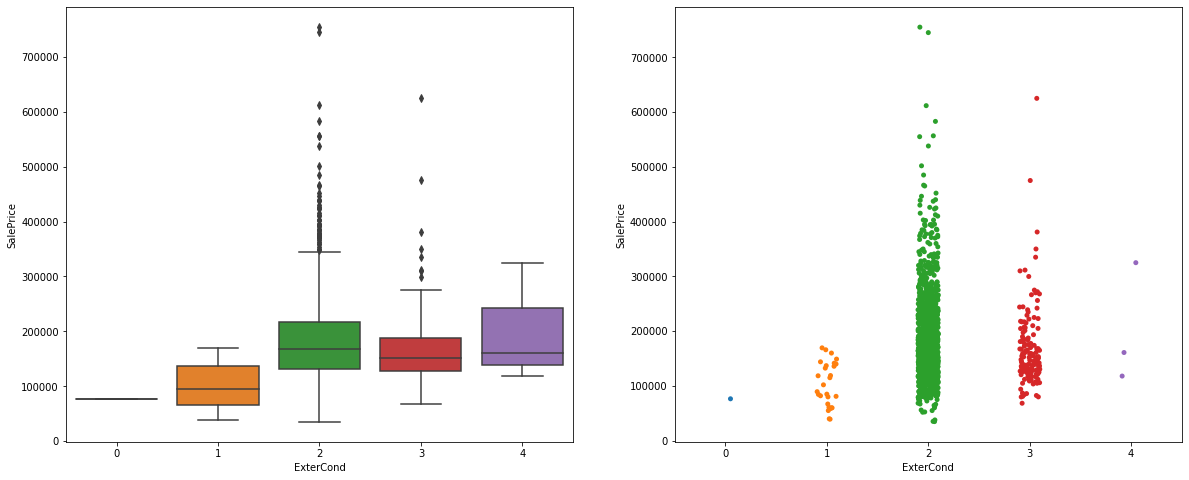

In [167]:
make_discrete_plot('ExterCond',0,0)

In [170]:
# few values that is 0 and 4, replacing them with 1 and 3
df.ExterCond = df.ExterCond.apply(lambda x: 1 if x == 0 else x)
df.ExterCond = df.ExterCond.apply(lambda x: 3 if x == 4 else x)

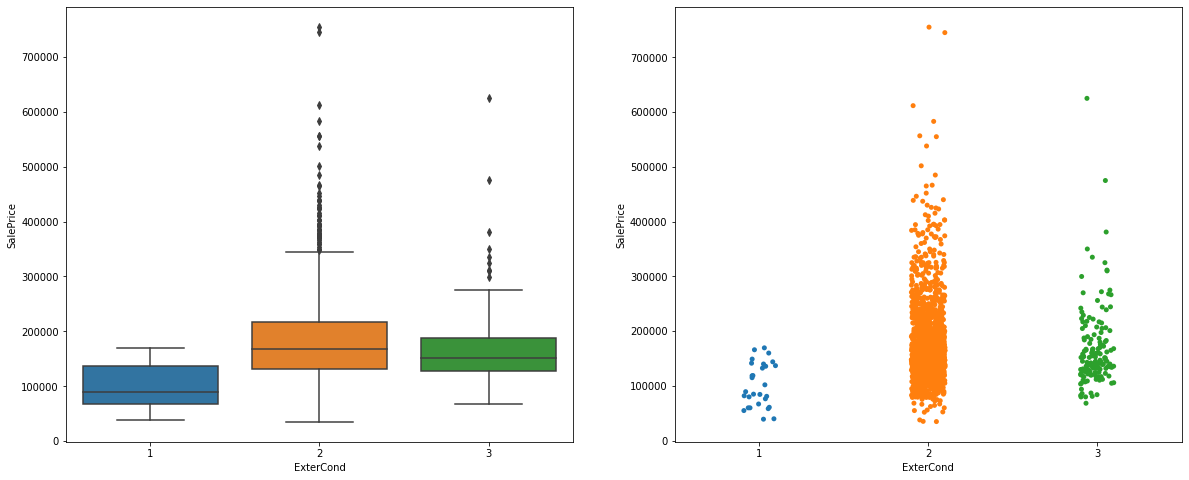

In [171]:
make_discrete_plot('ExterCond',0,0)

### BsmtQual


> Evaluates the height of the basement.

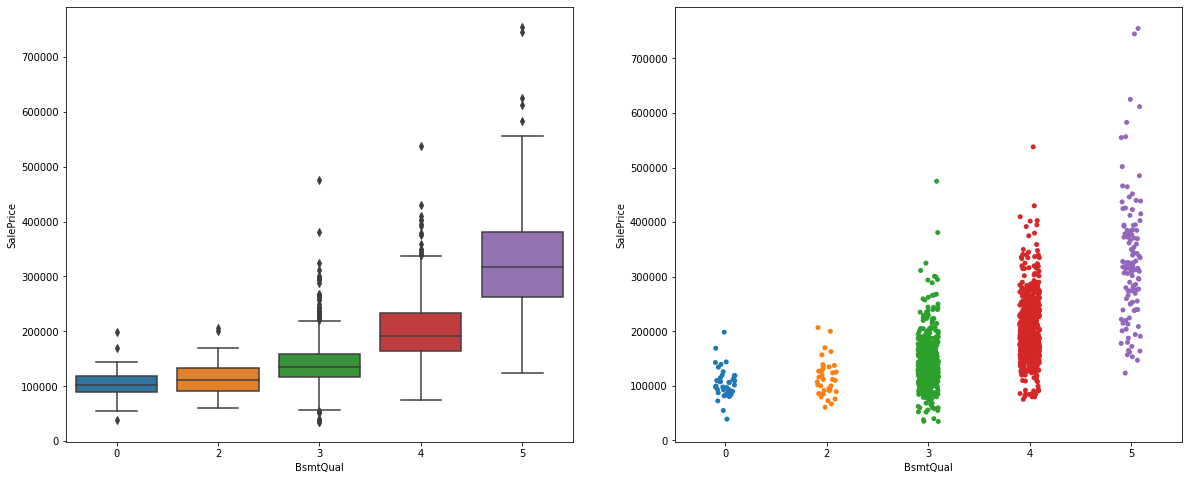

In [172]:
make_discrete_plot('BsmtQual',0,0)

### BsmtCond


> Evaluates the general condition of the basement.

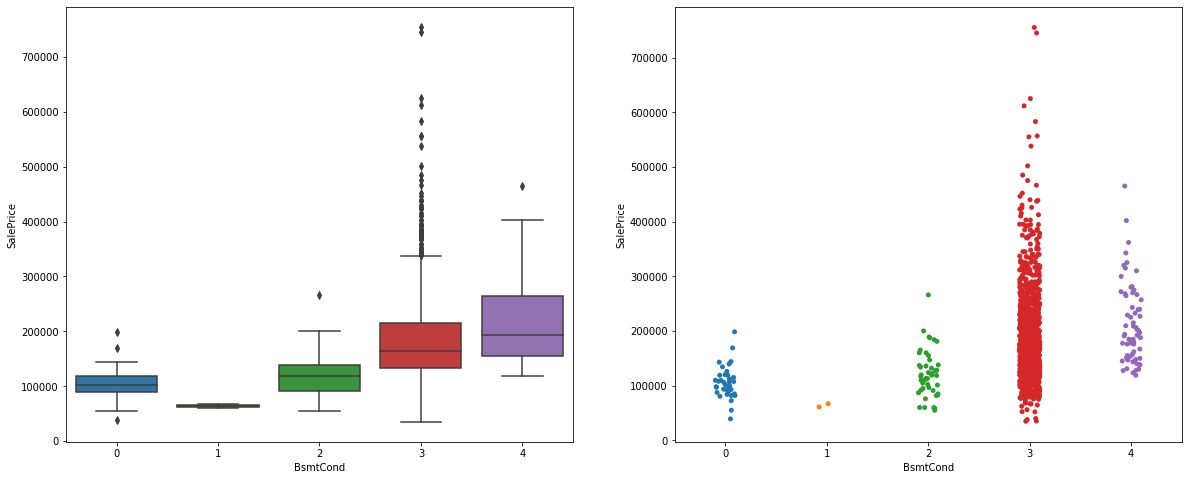

In [173]:
make_discrete_plot('BsmtCond',0,0)

In [174]:
# few values of 1, replacing them with 0
df['BsmtCond'] = df['BsmtCond'].apply(lambda x: 0 if x == 1 else x)

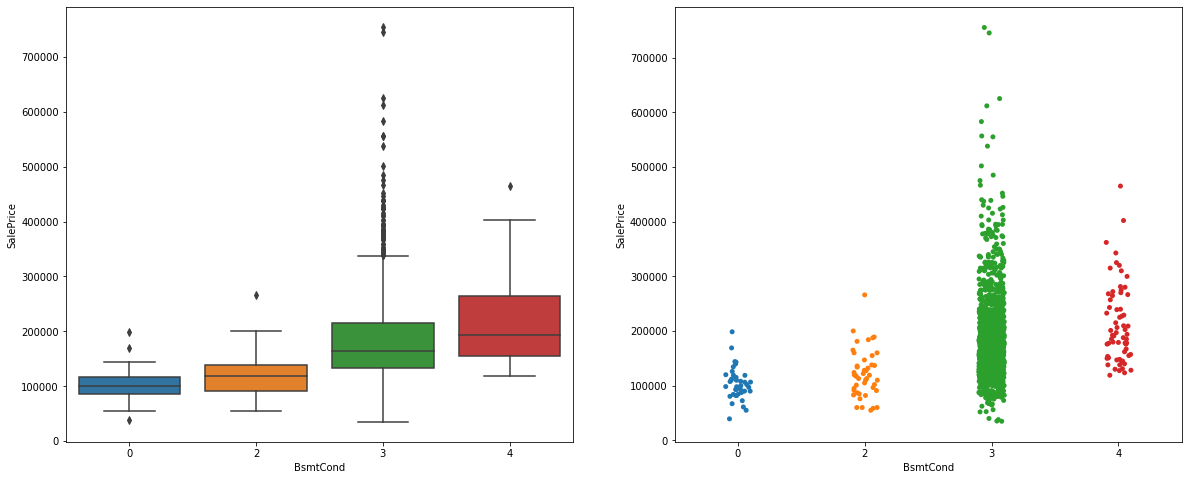

In [175]:
make_discrete_plot('BsmtCond',0,0)

### BsmtExposure


> Refers to walkout or garden level walls.

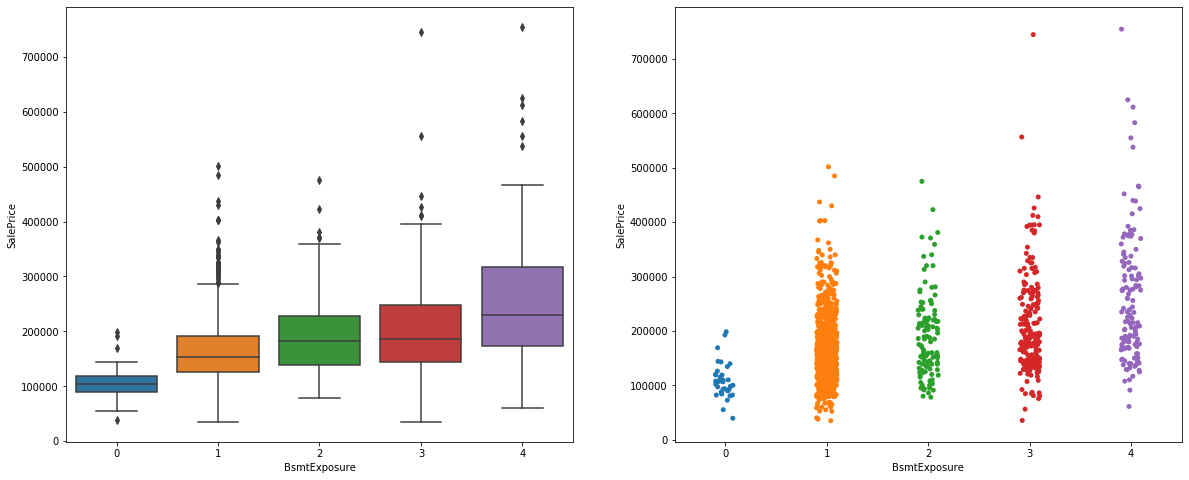

In [176]:
make_discrete_plot('BsmtExposure',0,0)

### BsmtFinType1


> Rating of basement finished area.

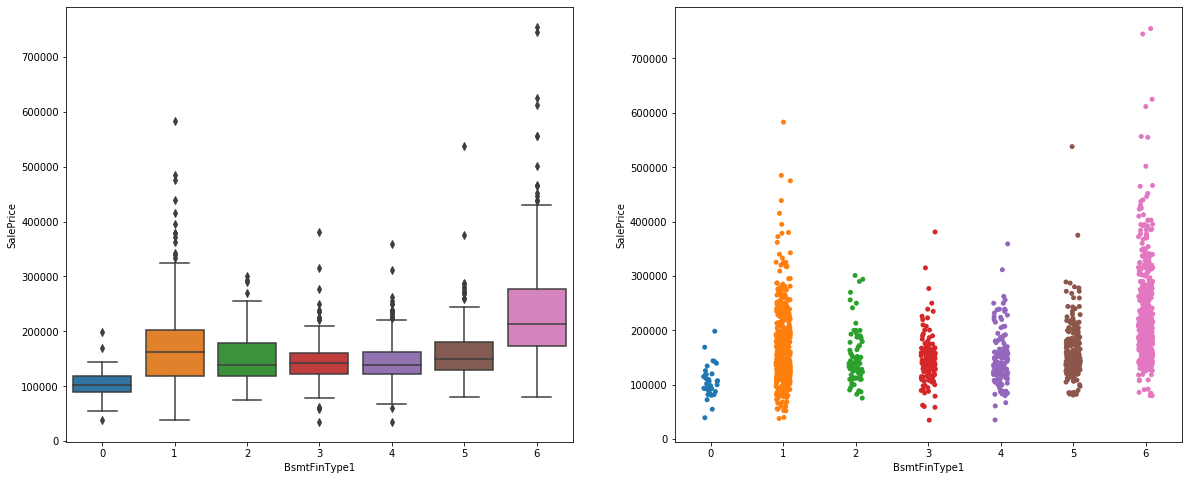

In [177]:
make_discrete_plot('BsmtFinType1',0,0)

In [178]:
# since there is no paticular pattern in this feature, it shall be converted back to string data
df['BsmtFinType1'] = df['BsmtFinType1'].astype(str)

### BsmtFinType2


> Quality of second finished area (if present).

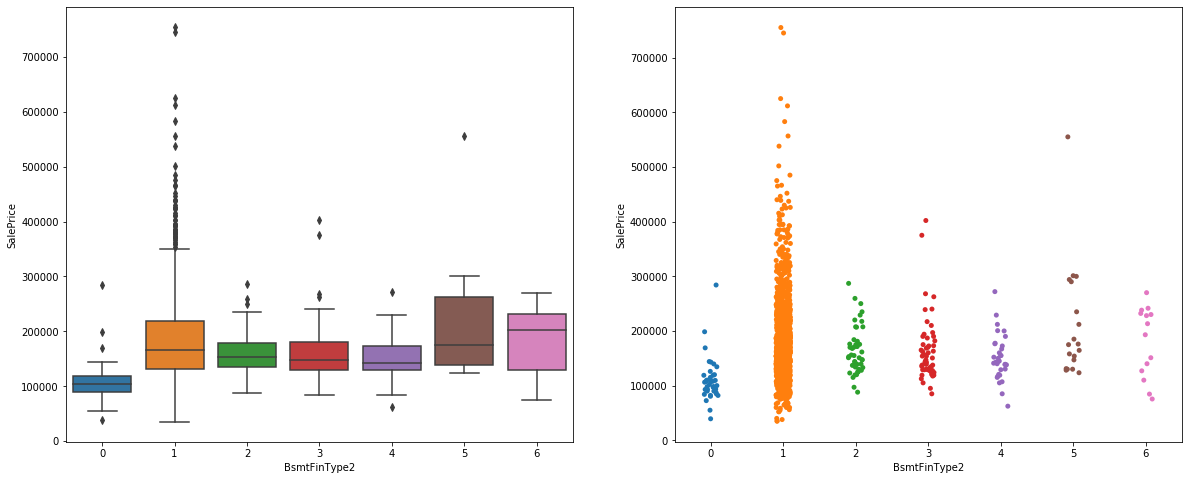

In [179]:
make_discrete_plot('BsmtFinType2',0,0)

In [180]:
# since there is no paticular pattern in this feature, it shall be converted back to string data
df['BsmtFinType2'] = df['BsmtFinType2'].astype(str)

### HeatingQC


> Heating quality and condition.

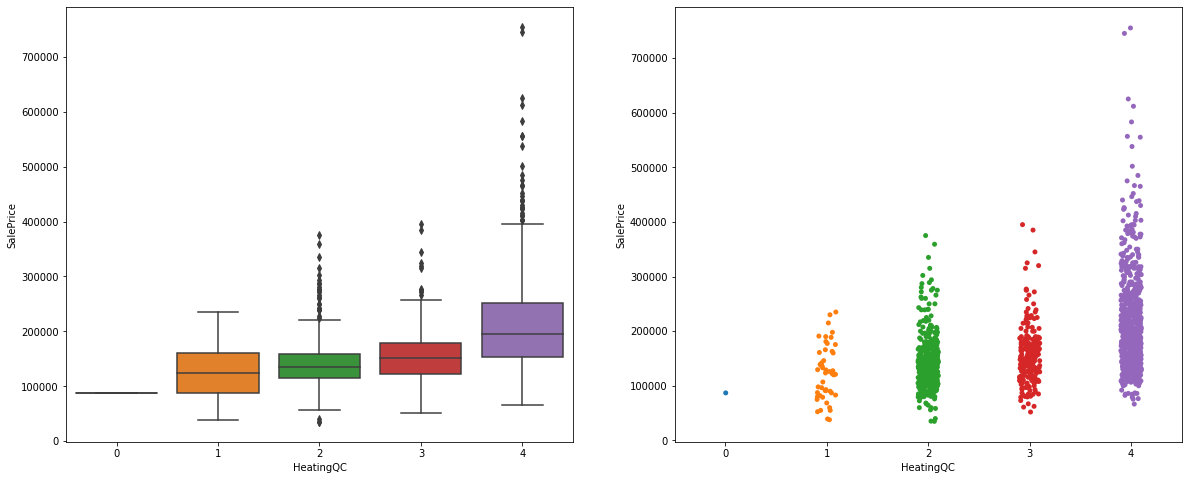

In [181]:
make_discrete_plot('HeatingQC',0,0)

In [182]:
# only 1 value of 0, replacing it with 1
df['HeatingQC'] = df['HeatingQC'].apply(lambda x: 1 if x == 0 else x)

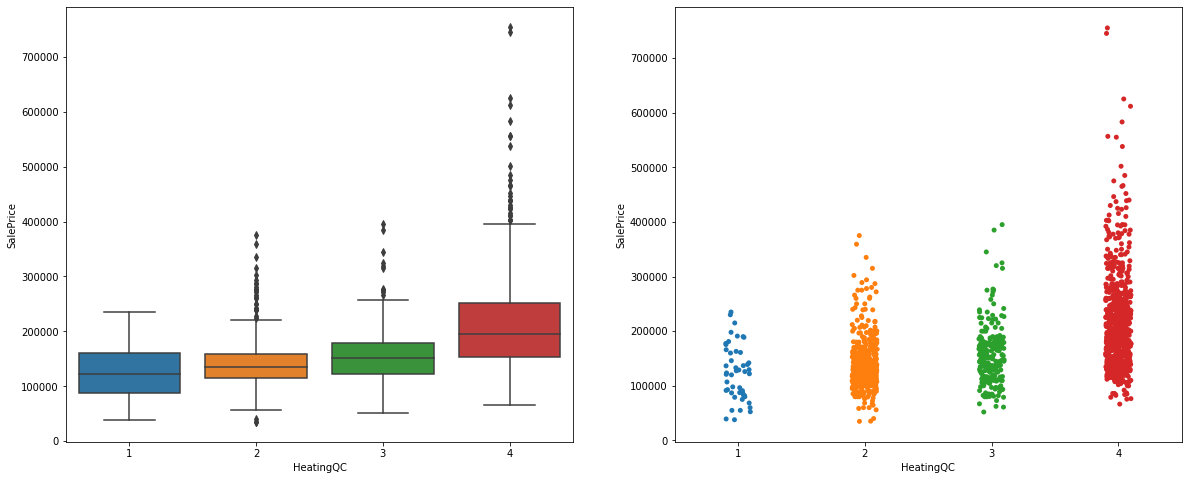

In [183]:
make_discrete_plot('HeatingQC',0,0)

### CentralAir


> If Central air conditioning is present.

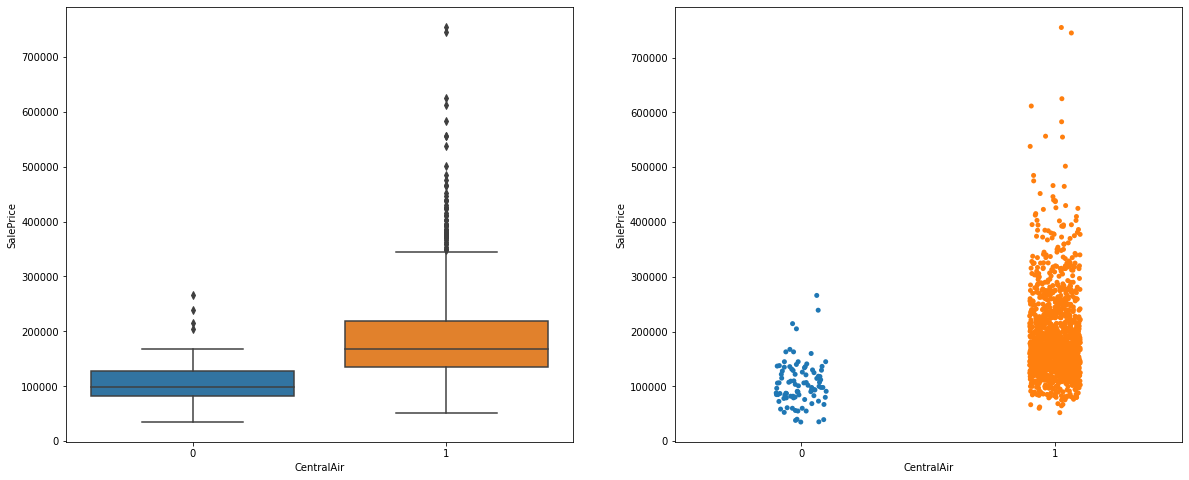

In [184]:
make_discrete_plot('CentralAir',0,0)

### Electrical


> Electrical system.

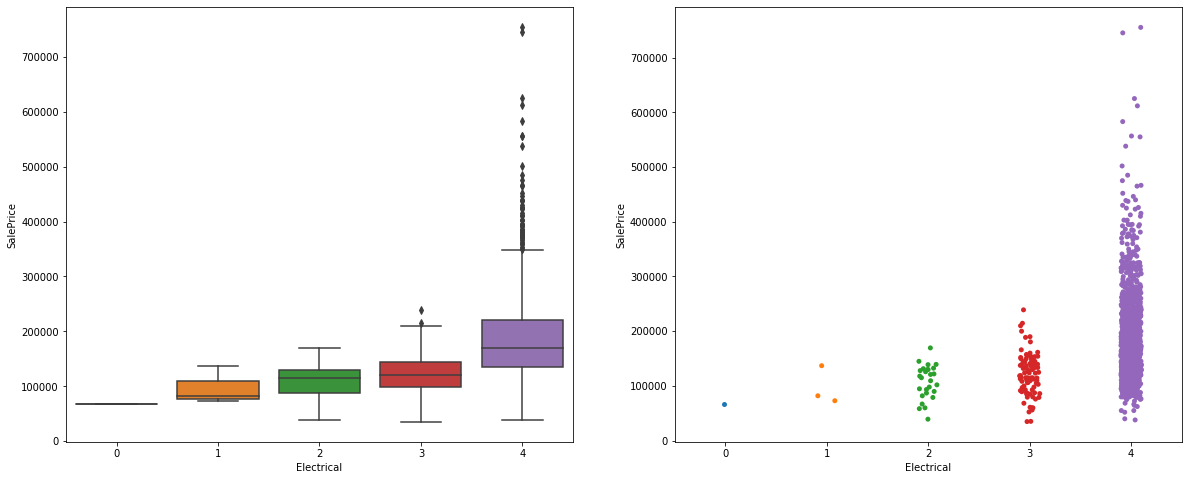

In [185]:
make_discrete_plot('Electrical',0,0)

In [186]:
# Few values of 0 and 1, replacing them with 2
df['Electrical'] = df['Electrical'].apply(lambda x: 2 if x < 2 else x)

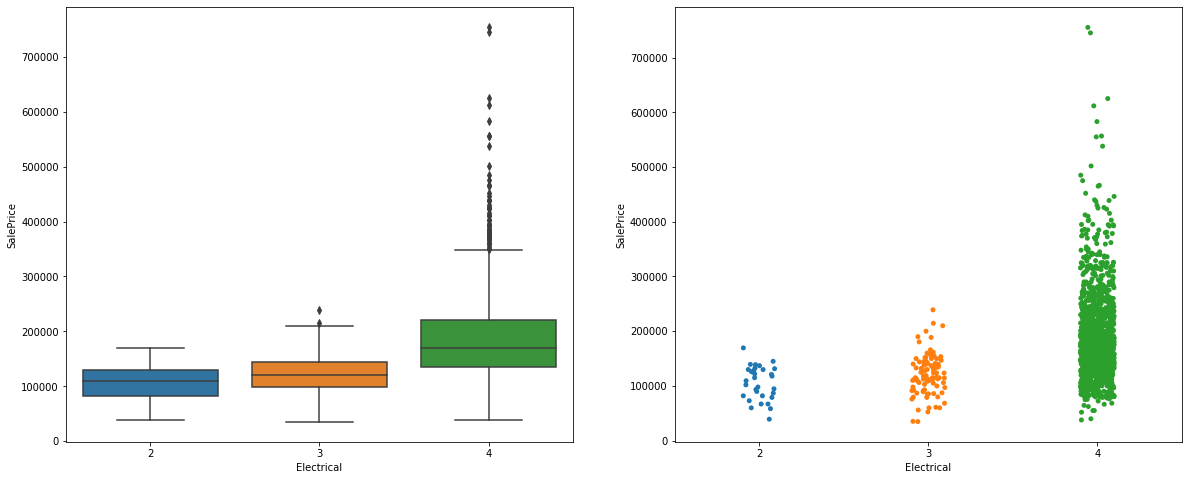

In [187]:
make_discrete_plot('Electrical',0,0)

### KitchenQual


> Kitchen quality.

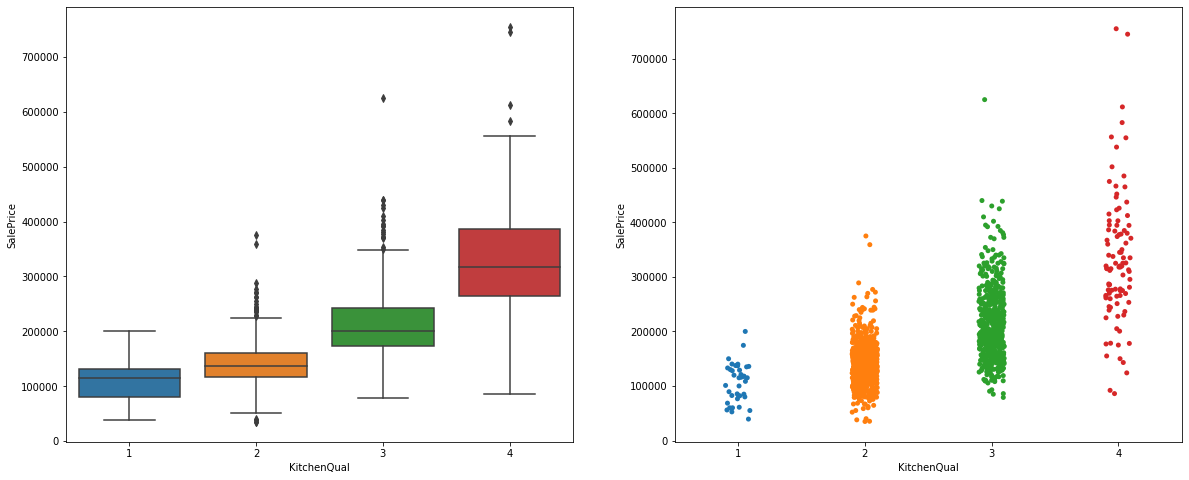

In [188]:
make_discrete_plot('KitchenQual',0,0)

### Functional


> Home functionality (Assume typical unless deductions are warranted).

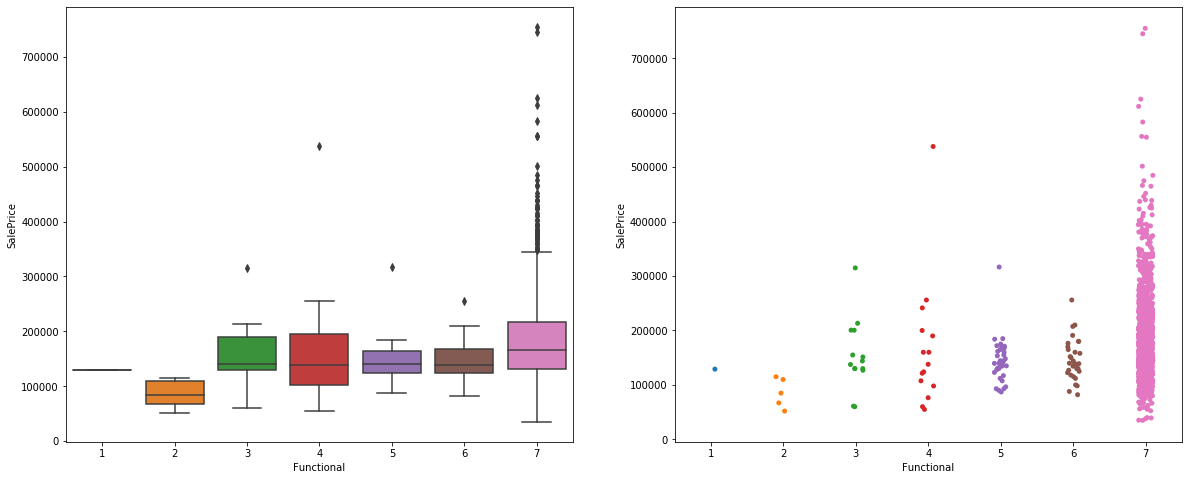

In [189]:
make_discrete_plot('Functional',0,0)

In [190]:
# few values that are less than 3, replacing them with 3
df.Functional = df.Functional.apply(lambda x: 3 if x < 3 else x)

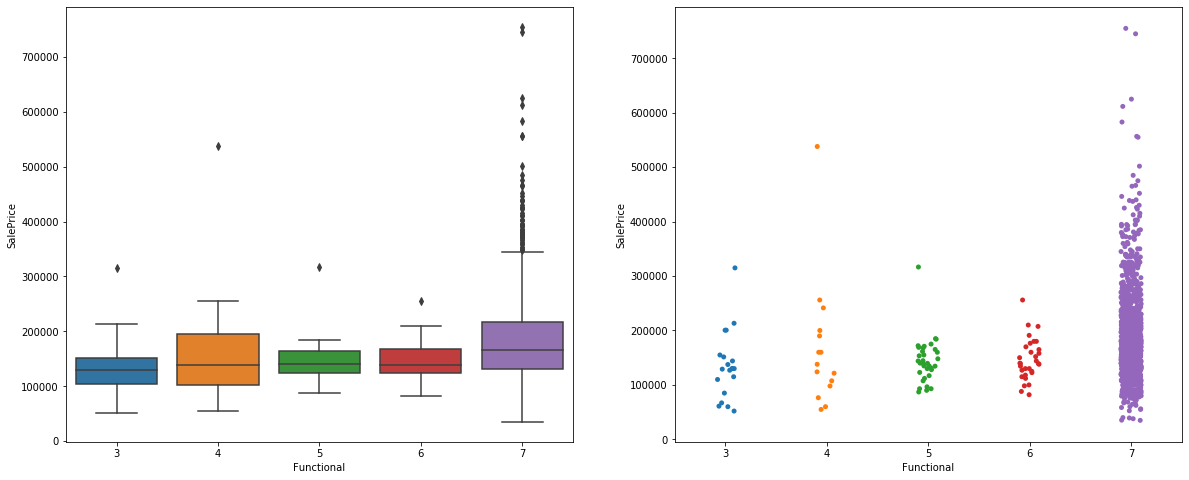

In [191]:
make_discrete_plot('Functional',0,0)

In [192]:
# since there is no paticular pattern in this feature, it shall be converted back to string data
df.Functional = df.Functional.astype(str)

### FireplaceQu


> Fireplace quality.

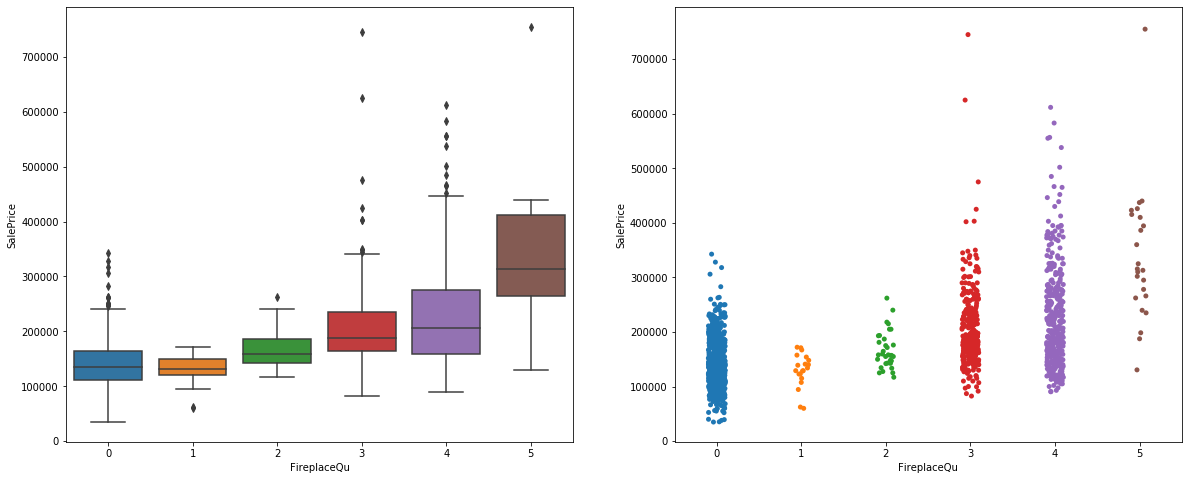

In [193]:
make_discrete_plot('FireplaceQu',0,0)

### GarageFinish


> Interior finish of the garage.

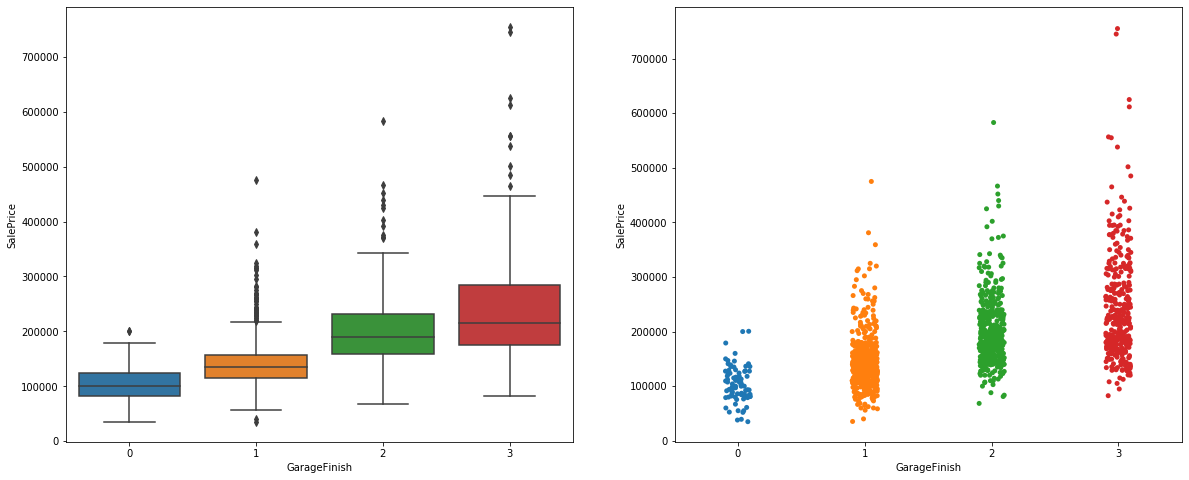

In [194]:
make_discrete_plot('GarageFinish',0,0)

### GarageQual


> Garage Quality.

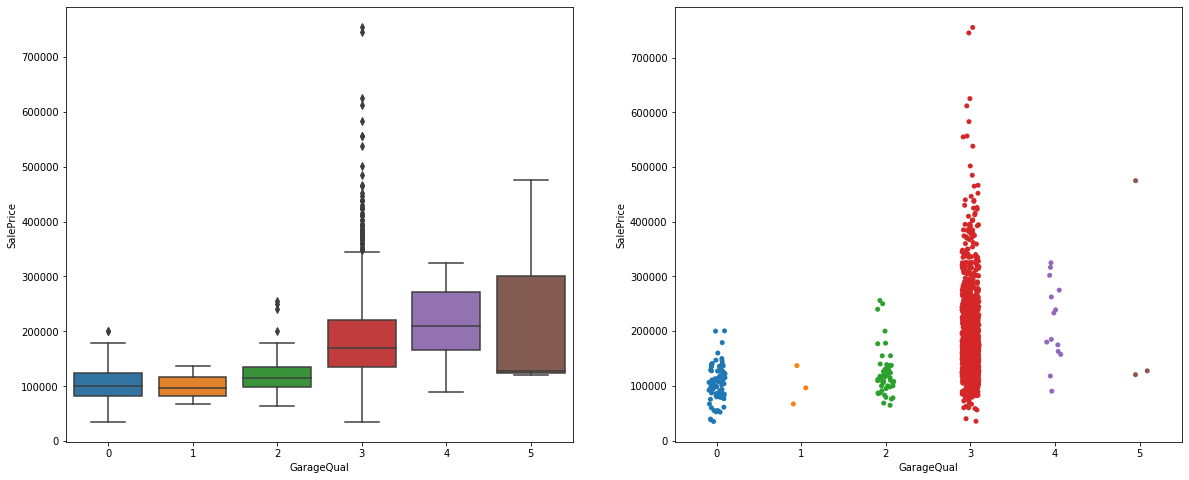

In [195]:
make_discrete_plot('GarageQual',0,0)

In [196]:
# Few values that are equal to 1 and 5, replacing them with 0 and 4 respectively 
df['GarageQual'] = df['GarageQual'].apply(lambda x: 0 if x == 1 else x)
df['GarageQual'] = df['GarageQual'].apply(lambda x: 4 if x == 5 else x)

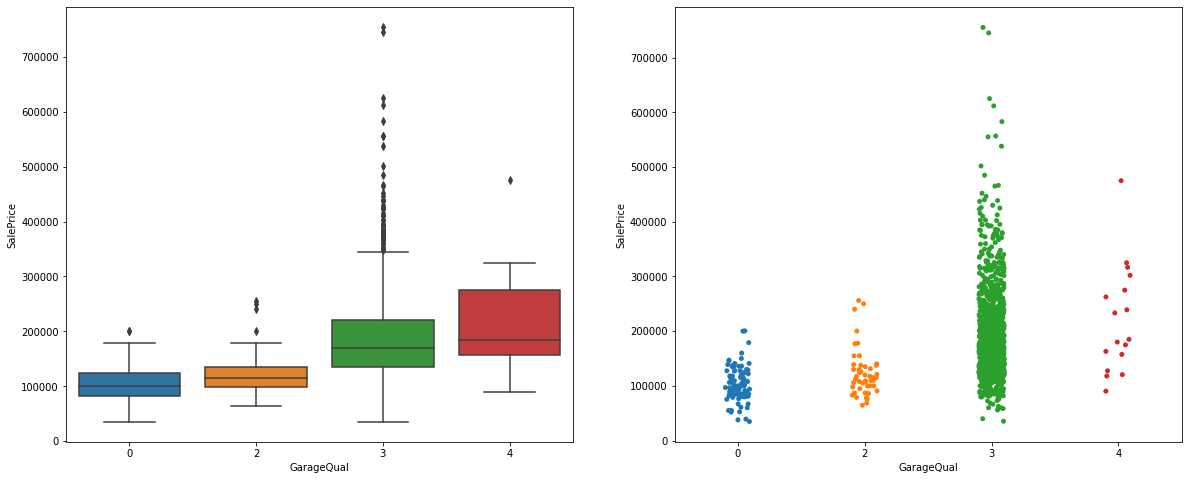

In [197]:
make_discrete_plot('GarageQual',0,0)

### GarageCond


> Garage condition.

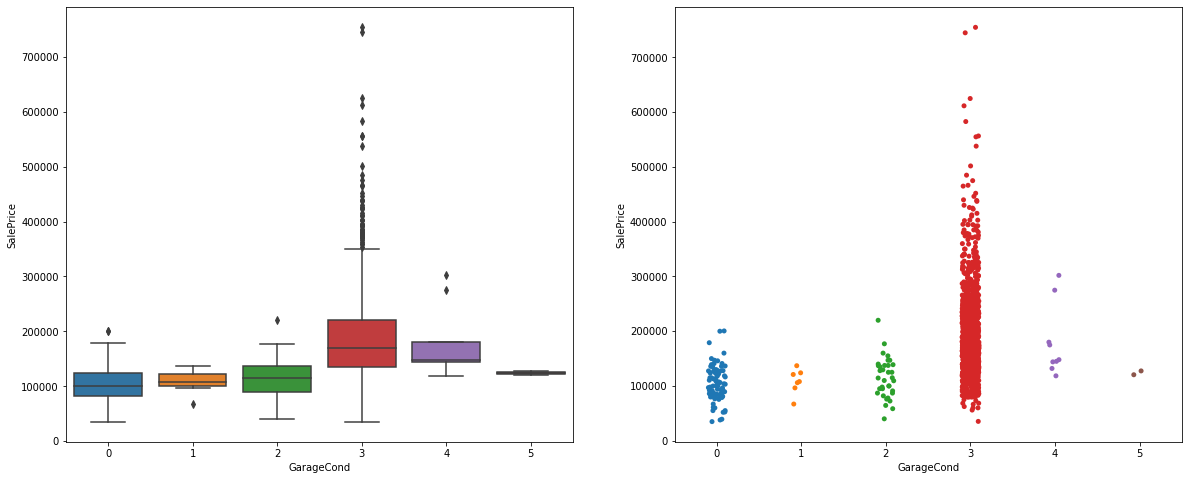

In [198]:
make_discrete_plot('GarageCond',0,0)

In [199]:
# Few values that are equal to 1 and greater than 4, replacing them with 0 and 3
df['GarageCond'] = df['GarageCond'].apply(lambda x: 0 if x == 1 else x)
df['GarageCond'] = df['GarageCond'].apply(lambda x: 3 if x > 3 else x)

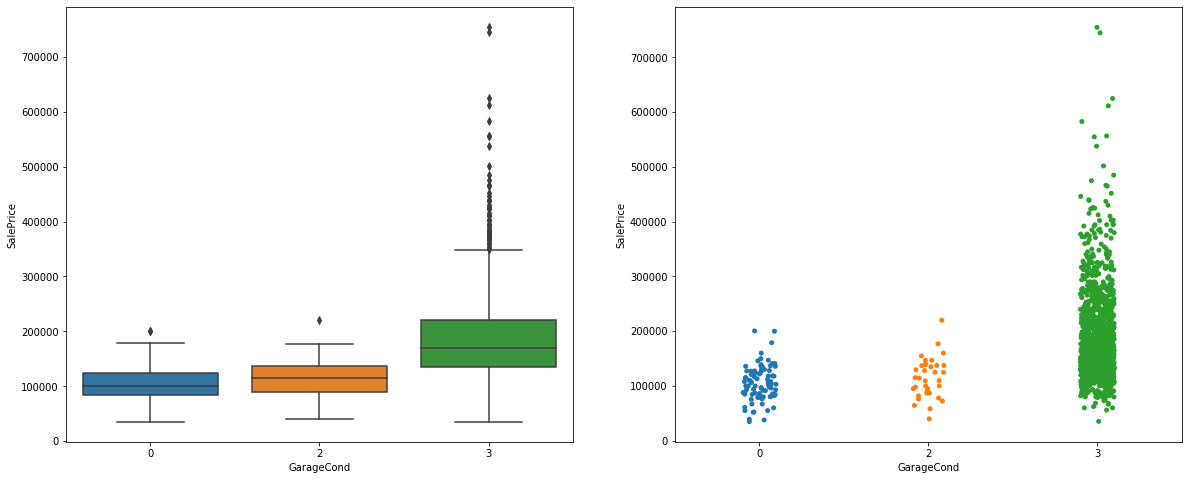

In [200]:
make_discrete_plot('GarageCond',0,0)

In [201]:
# since there is no paticular pattern in this feature, it shall be converted back to string data
df['GarageCond'] = df['GarageCond'].astype(str)

### PavedDrive


> Type of Paved driveway.

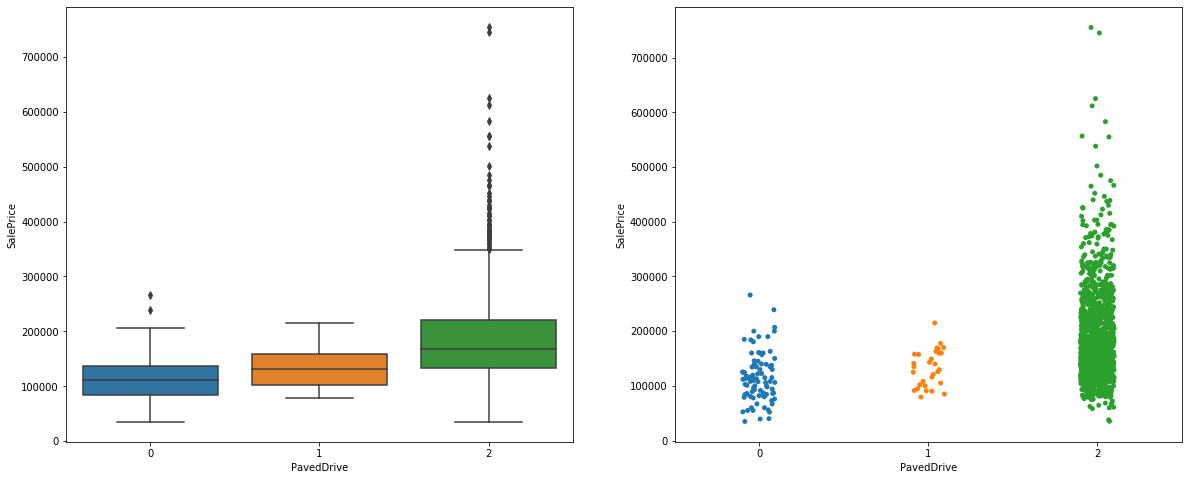

In [202]:
make_discrete_plot('PavedDrive',0,0)

### PoolQC


> Pool quality.

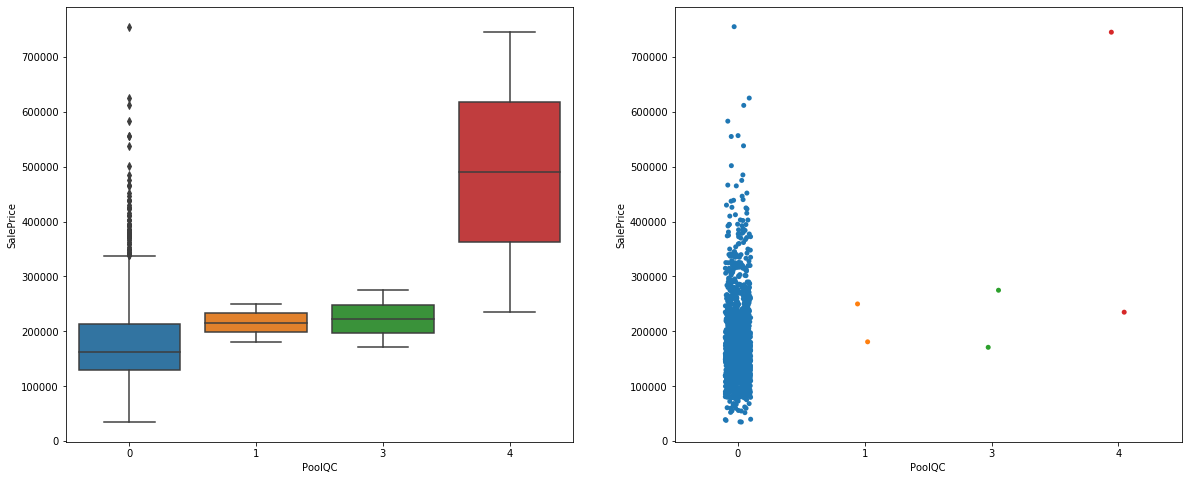

In [203]:
make_discrete_plot('PoolQC',0,0)

In [204]:
''' Although there are 4 categories, more than 99% of them are in 1 category, therefore this feature is not reliable and shall 
    be dropped '''
df = df.drop(columns='PoolQC')

### Fence

> Fence quality.

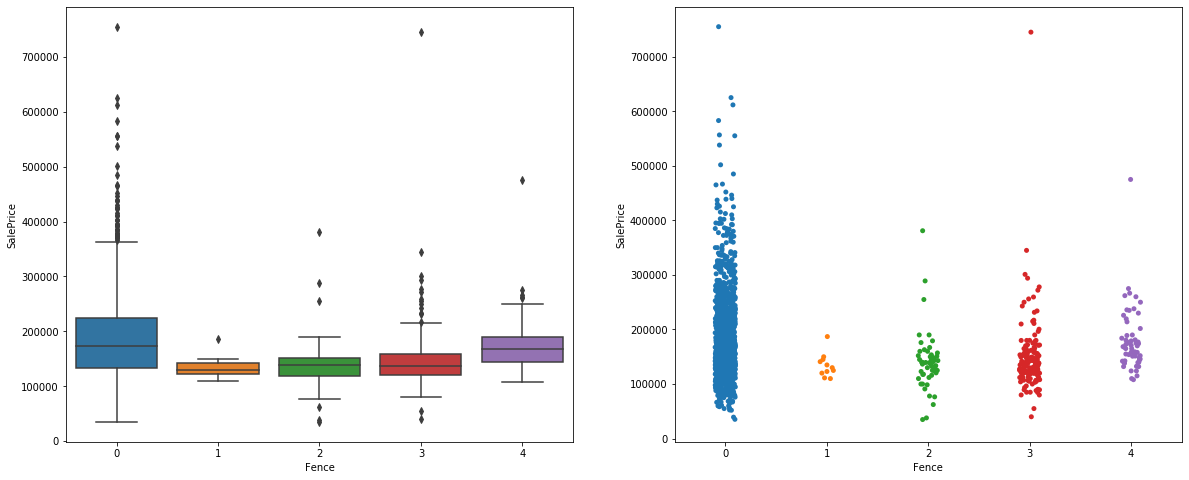

In [205]:
make_discrete_plot('Fence',0,0)

In [206]:
# few values that are equal to 1, replacing them with 0
df['Fence'] = df['Fence'].apply(lambda x: 0 if x == 1 else x)

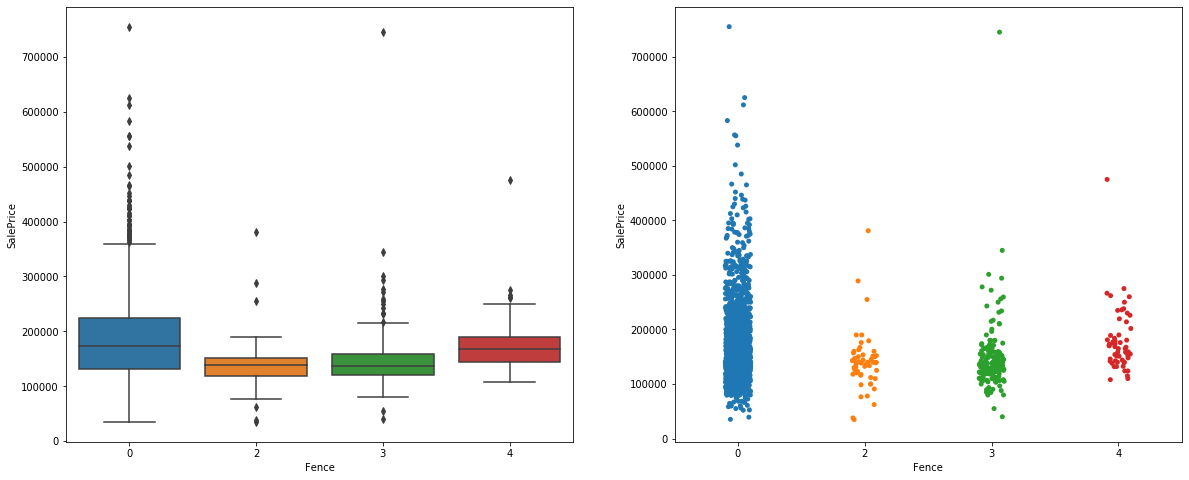

In [207]:
make_discrete_plot('Fence',0,0)

In [208]:
# since there is no paticular pattern in this feature, it shall be converted back to string data
df['Fence'] = df['Fence'].astype(str)

## Nominal Variables

> We will analyze each ordinal feature with boxplots. After seeing the data and correlation using boxplots, the data might be left unchanged, altered, or the whole column is drop completely

In [209]:
print(cat_nominal)

['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition']


### MSSubClass


> The building class.

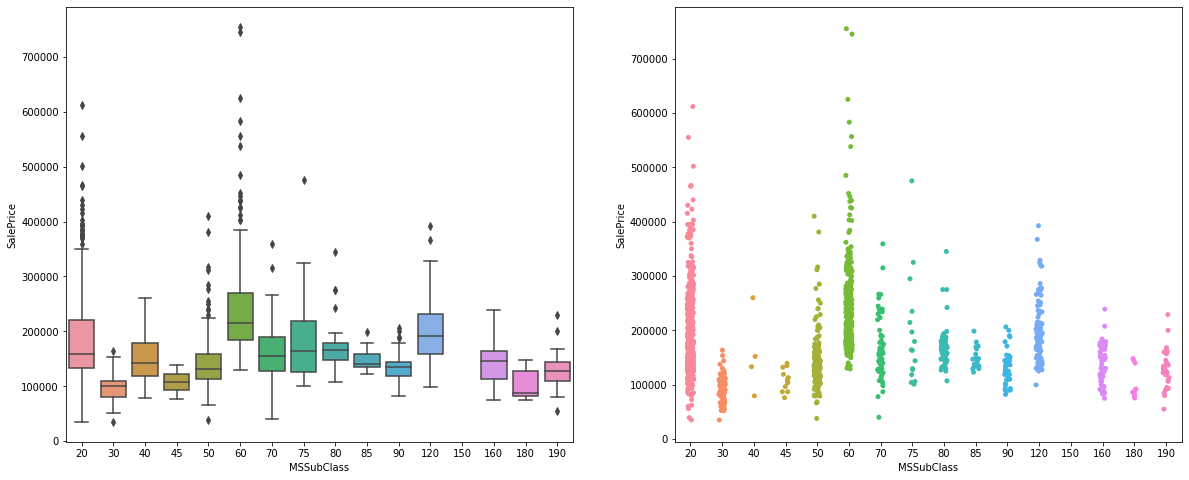

In [210]:
make_discrete_plot('MSSubClass',0,0)

In [211]:
# This should be a categorical data but is represented by numbers, so converting it back to string
df['MSSubClass'] = df['MSSubClass'].astype(str)

### MSZoning


> The general zoning classification.

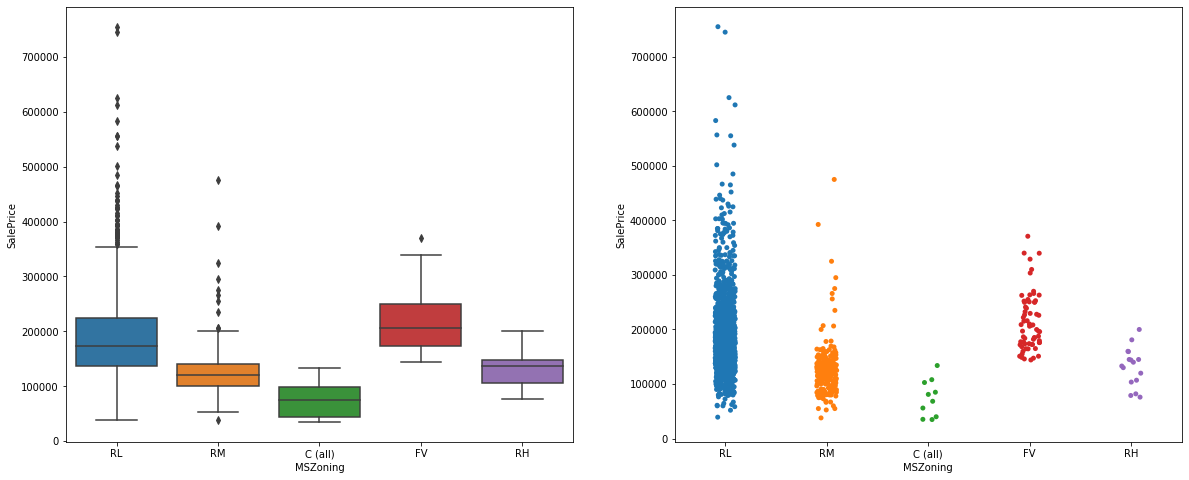

In [212]:
make_discrete_plot('MSZoning',0,0)

### Street


> Type of road access.

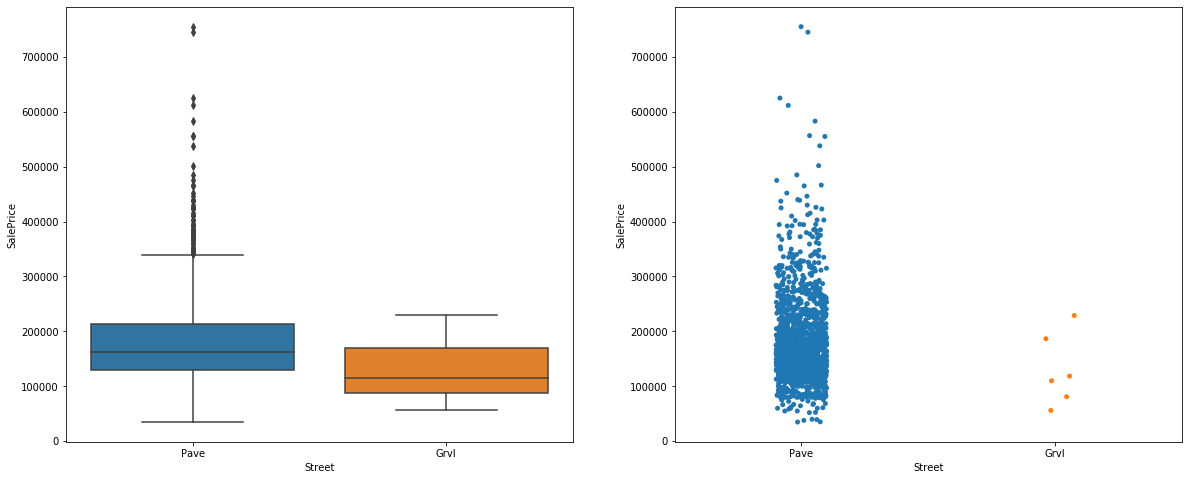

In [213]:
make_discrete_plot('Street',0,0)

In [214]:
# Only 1 categoy represent >99% of the data, therefore the feaature is unreliable and dropped completely
df = df.drop(columns='Street')

### Alley


> Type of alley access.

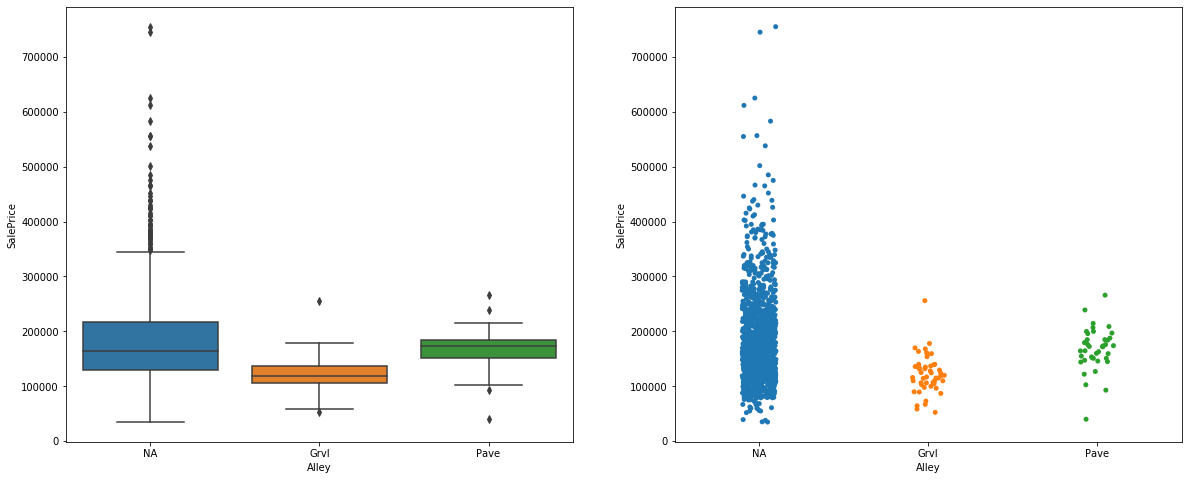

In [215]:
make_discrete_plot('Alley',0,0)

### LandContour


> Flatness of the property.

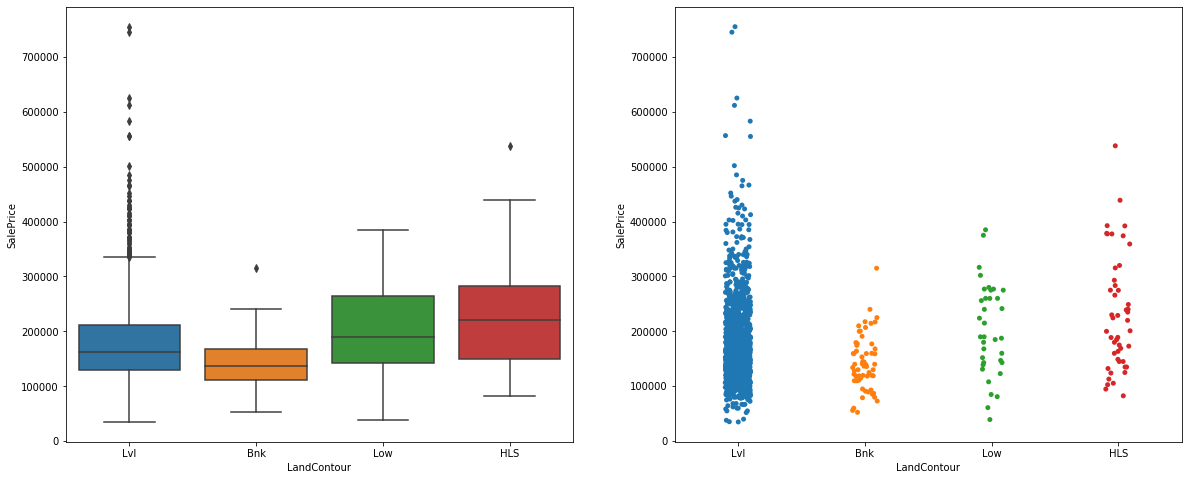

In [216]:
make_discrete_plot('LandContour',0,0)

### LotConfig


> Lot configuration.

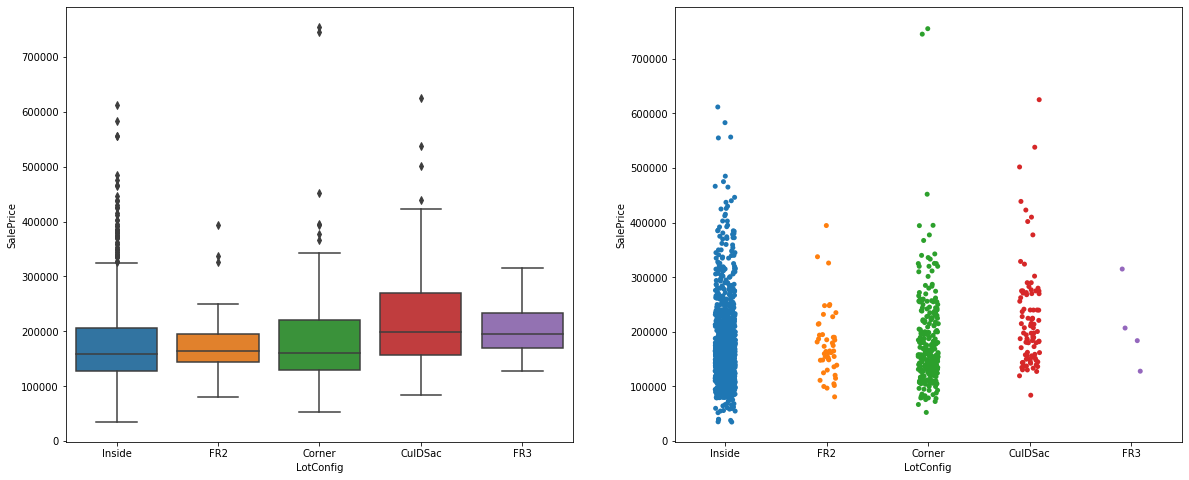

In [217]:
make_discrete_plot('LotConfig',0,0)

In [218]:
# few values that is labeled as FR3, replacing them with a label that is most similar which is FR2
df['LotConfig'] = df['LotConfig'].apply(lambda x: 'FR2' if x == 'FR3' else x)

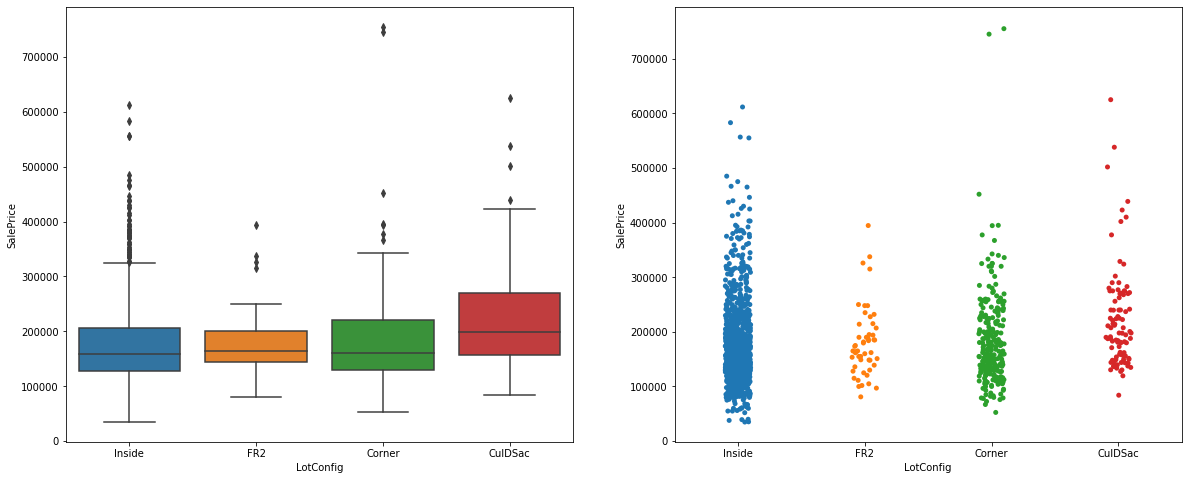

In [219]:
make_discrete_plot('LotConfig',0,0)

### Neighborhood


> Physical locations within Ames city limits.

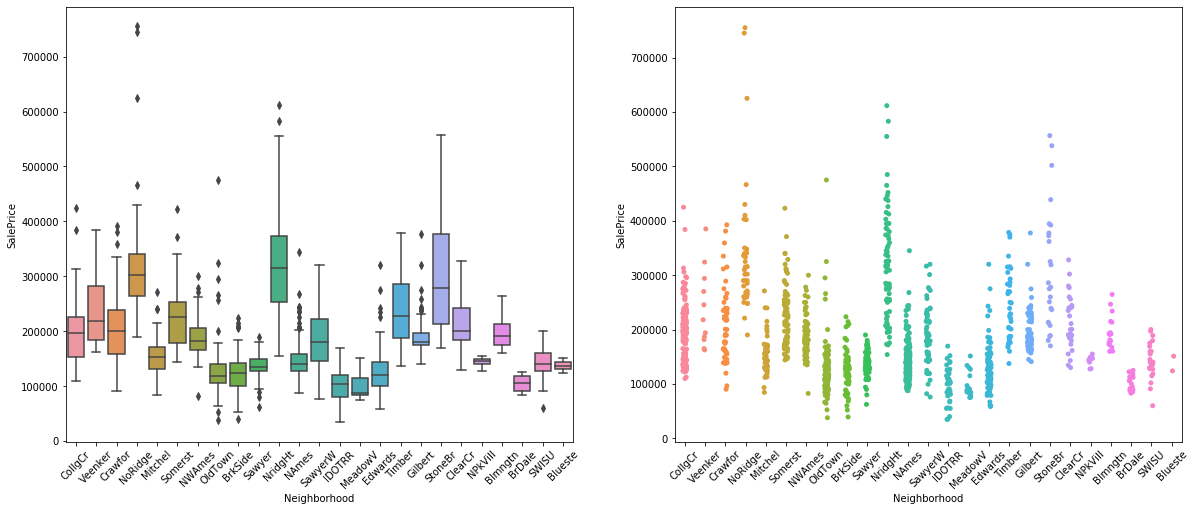

In [220]:
make_discrete_plot('Neighborhood',45,45)

> Although there are only 2 points in "Blueste", we dont know which is the closest neighbour to it, therefore the data will be unchanged

### Condition1


> Proximity to main road or railroad.

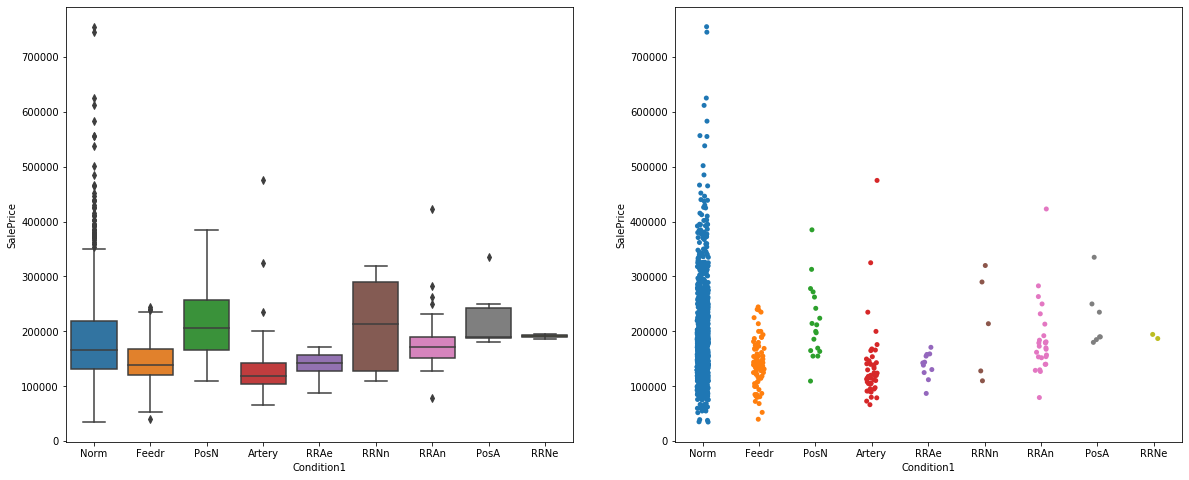

In [221]:
make_discrete_plot('Condition1',0,0)

In [222]:
# From this we can cluster (RRNn with RRAn) and (RRAe with RRNe) 
df['Condition1'] = df['Condition1'].apply(lambda x: 'RRn' if (x == 'RRNn' or x == 'RRAn') else x)
df['Condition1'] = df['Condition1'].apply(lambda x: 'RRe' if (x == 'RRNe' or x == 'RRAe') else x)

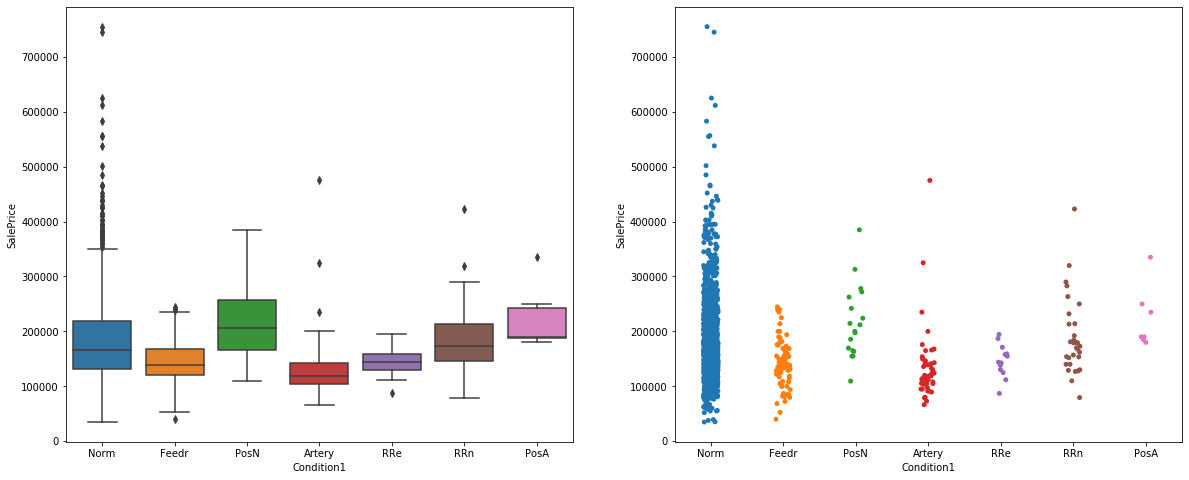

In [223]:
make_discrete_plot('Condition1',0,0)

### Condition2


> Proximity to main road or railroad (if a second is present).

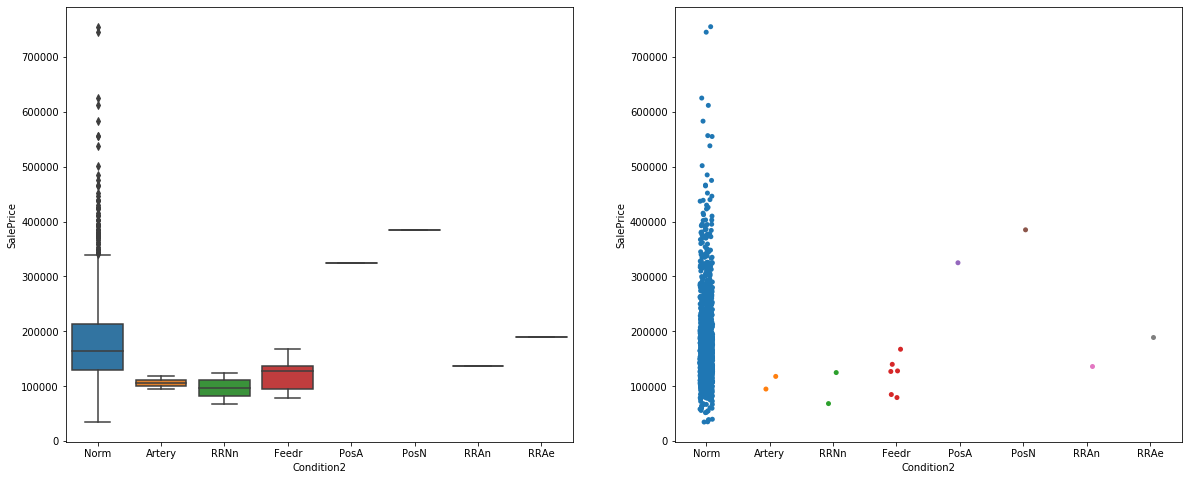

In [224]:
make_discrete_plot('Condition2',0,0)

In [225]:
# Since most of the data is in 1 category, this feature is unreliable and shall be dropped
df = df.drop(columns='Condition2')

### BldgType


> Type of dwelling.

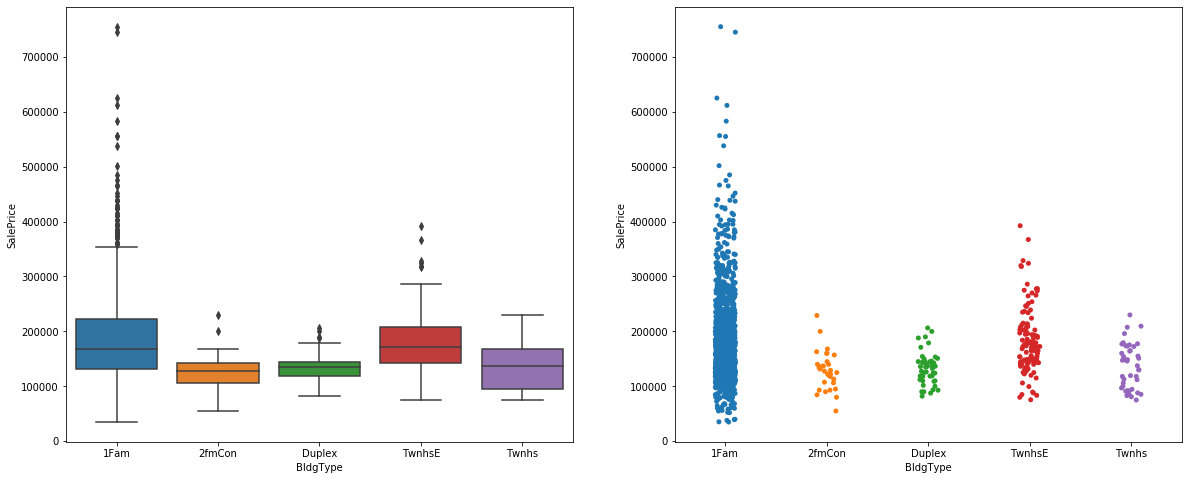

In [226]:
make_discrete_plot('BldgType',0,0)

### HouseStyle


> Style of dwelling.

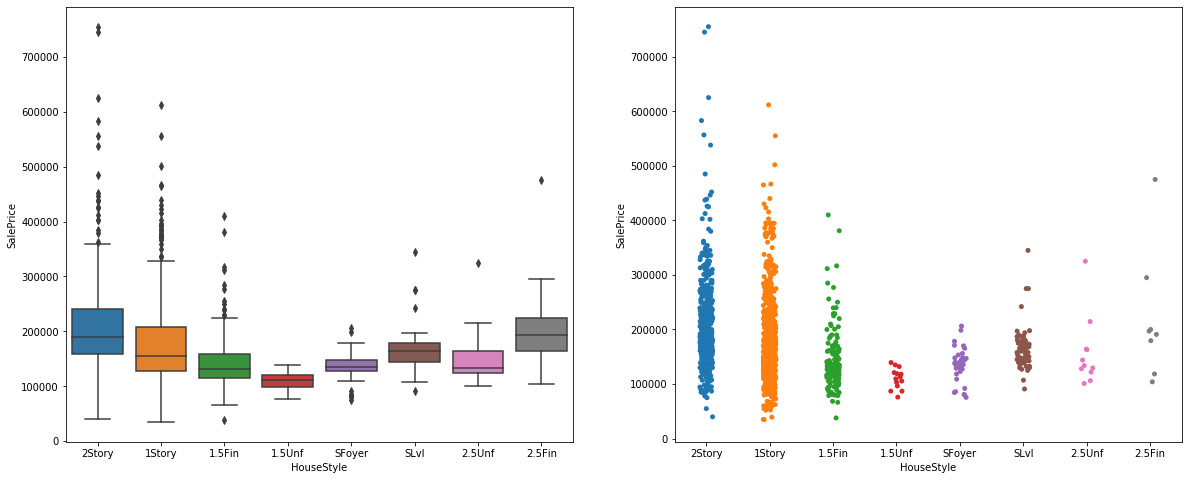

In [227]:
make_discrete_plot('HouseStyle',0,0)

### RoofStyle


> Type of roof.

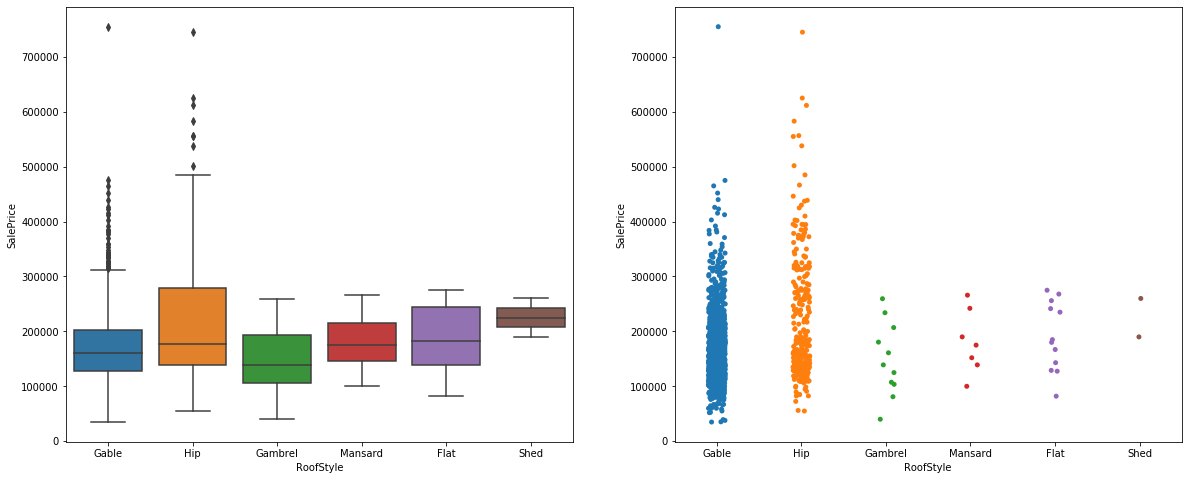

In [228]:
make_discrete_plot('RoofStyle',0,0)

In [242]:
# Since only a small portion of data is in ['Gambrel','Mansard','Flat','Shed'], they shall be combined into one
df['RoofStyle'] = df['RoofStyle'].apply(lambda x: 'Other' if ['Gambrel','Mansard','Flat','Shed'] else x)

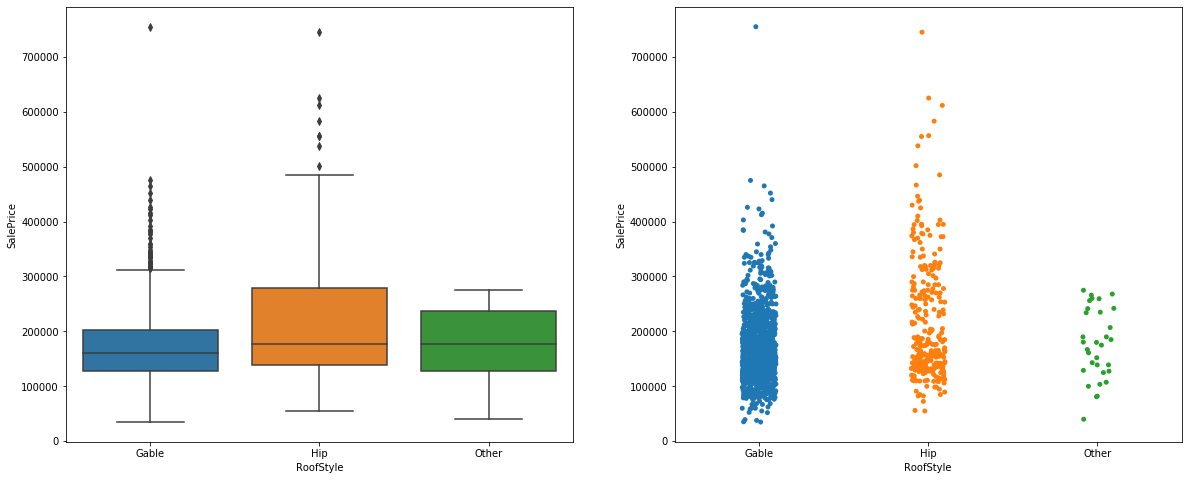

In [230]:
make_discrete_plot('RoofStyle',0,0)

### RoofMatl


> Roof material.

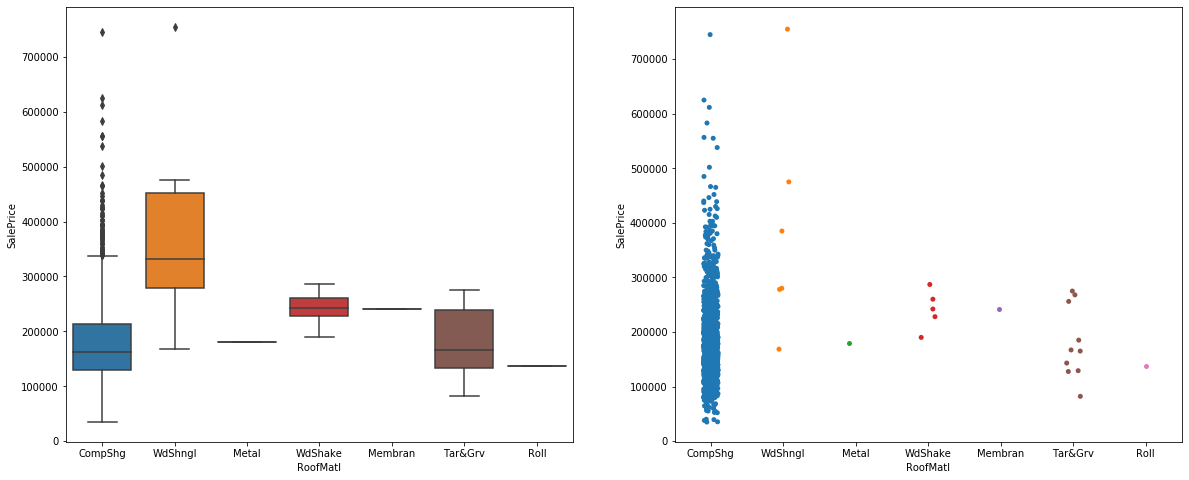

In [231]:
make_discrete_plot('RoofMatl',0,0)

In [232]:
# most of the data are in one category, therefore the column is unreliable and dropped completely
df = df.drop(columns='RoofMatl')

### Exterior1st


> Exterior covering on house.

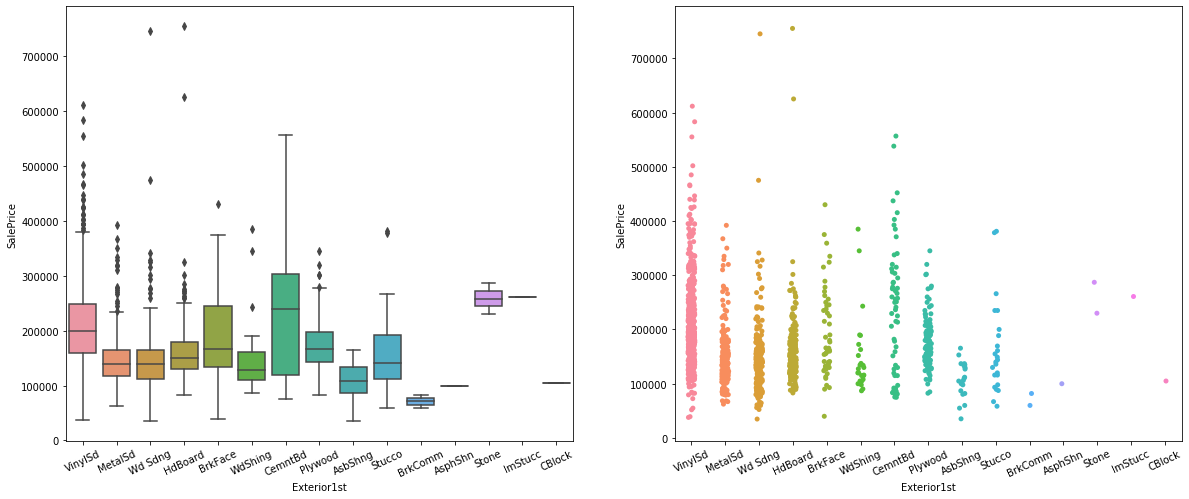

In [233]:
make_discrete_plot('Exterior1st',25,25)

In [241]:
# only a few data exist in ['BrkComm','AsphShn','Stone','ImStucc','CBlock'], so they shall be combined into one
df['Exterior1st'] = df['Exterior1st'].apply(lambda x: 'Other' if x in ['BrkComm','AsphShn','Stone','ImStucc','CBlock'] else x)

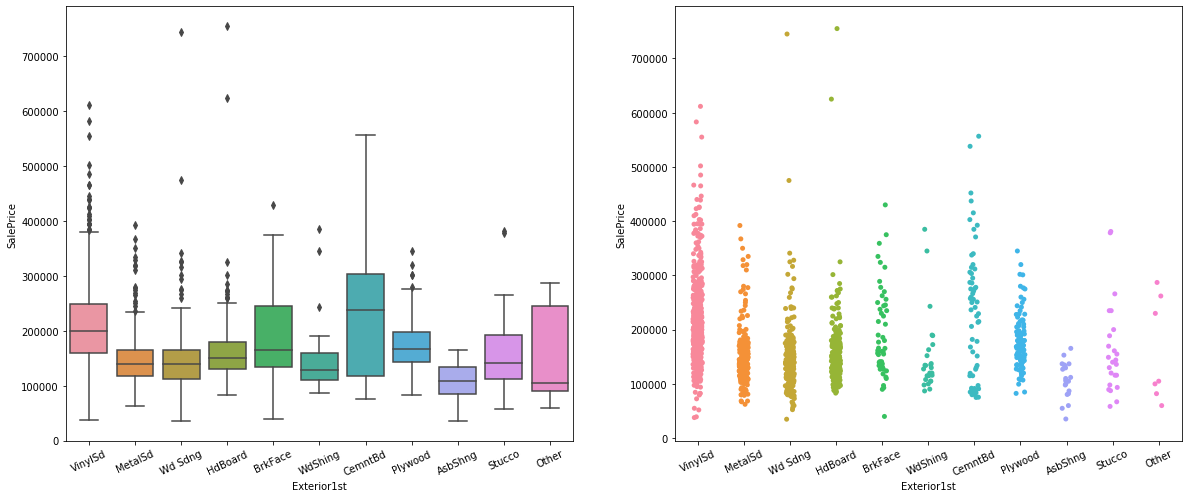

In [235]:
make_discrete_plot('Exterior1st',25,25)

### Exterior2nd


> Exterior covering on house (if more than one material).

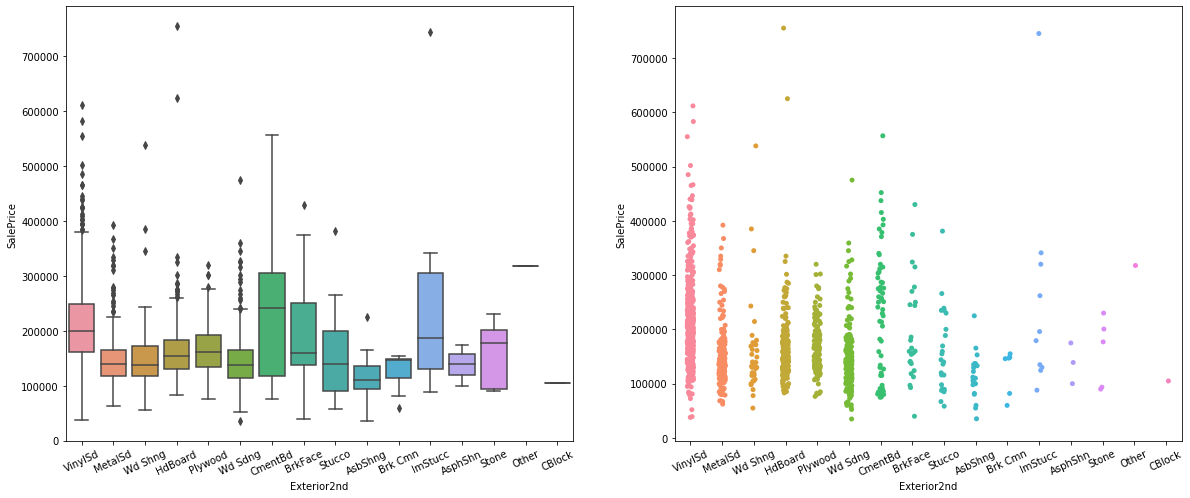

In [236]:
make_discrete_plot('Exterior2nd',25,25)

In [239]:
# only a few data exist in ['Brk Cmn','imStucc','Stone','ImStucc','AsphShn','Stone','AsphShn','CBlock'], therefore they shall be combined with other
df['Exterior2nd'] = df['Exterior2nd'].apply(lambda x: 'Other' if x in ['Brk Cmn','imStucc','Stone','ImStucc','AsphShn','Stone','AsphShn','CBlock'] else x)

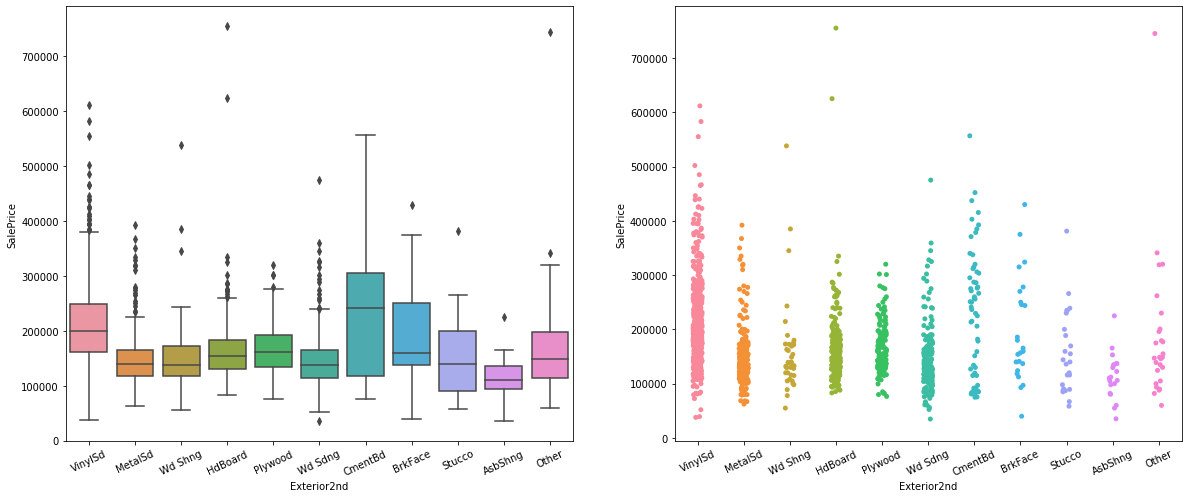

In [244]:
make_discrete_plot('Exterior2nd',25,25)

### MasVnrType


> Masonry veneer type.

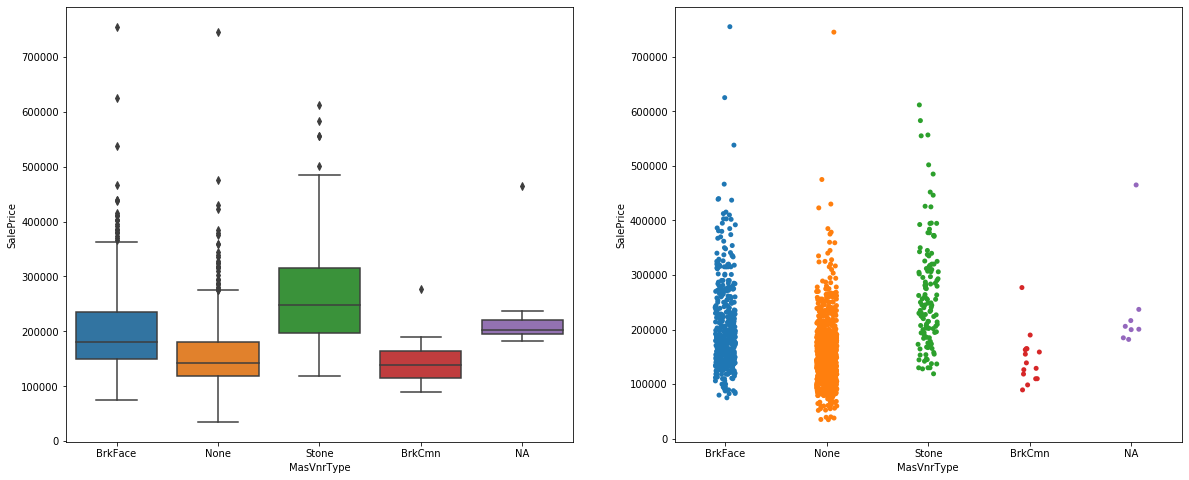

In [245]:
make_discrete_plot('MasVnrType',0,0)

### Foundation


> Type of foundation.

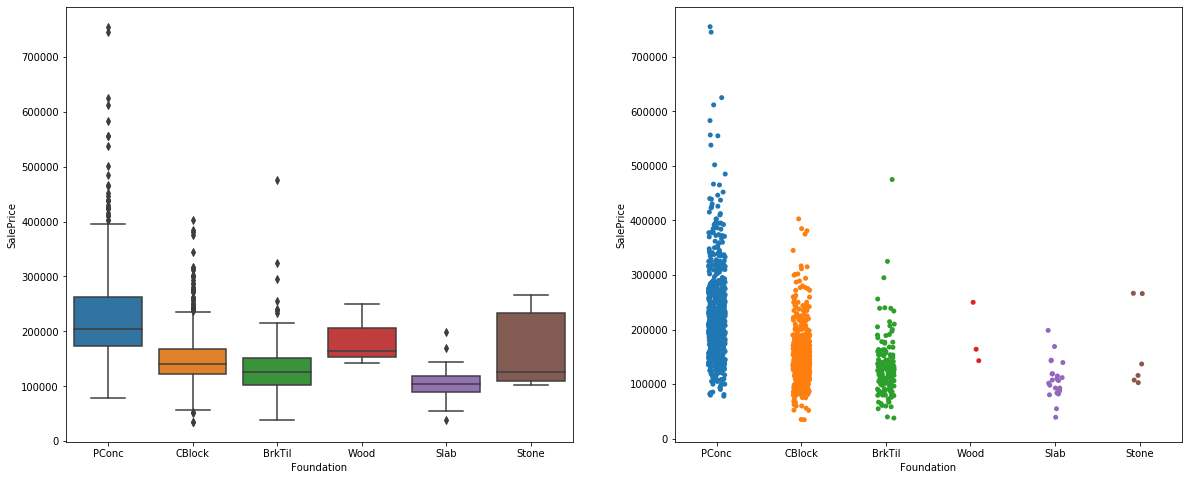

In [246]:
make_discrete_plot('Foundation',0,0)

In [247]:
# only a few data in wood and stone, then they shall put together as "Other"
df['Foundation'] = df['Foundation'].apply(lambda x: 'Other' if (x == 'Wood' or x == 'Stone') else x)

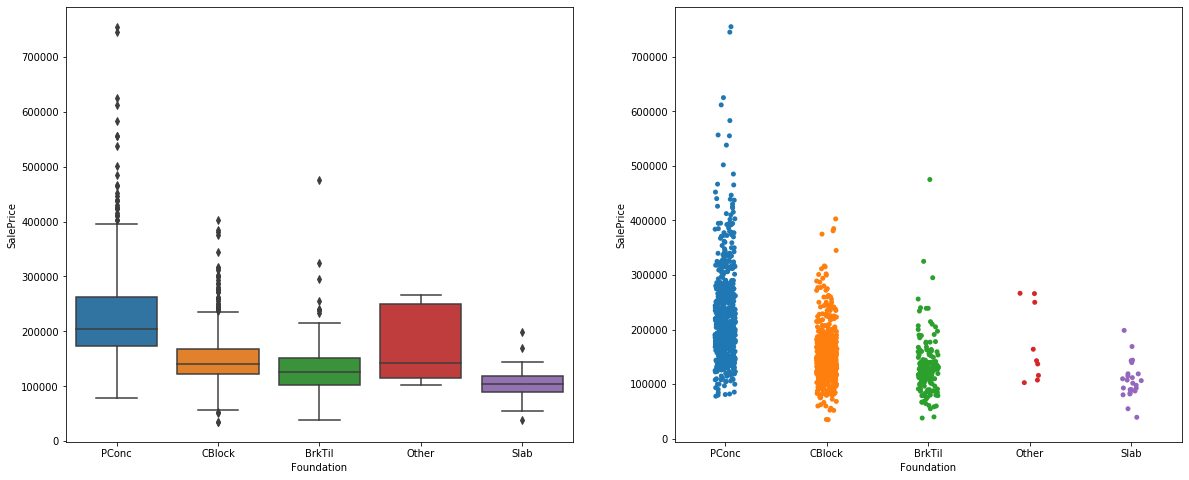

In [248]:
make_discrete_plot('Foundation',0,0)

### Heating


> Type of heating.

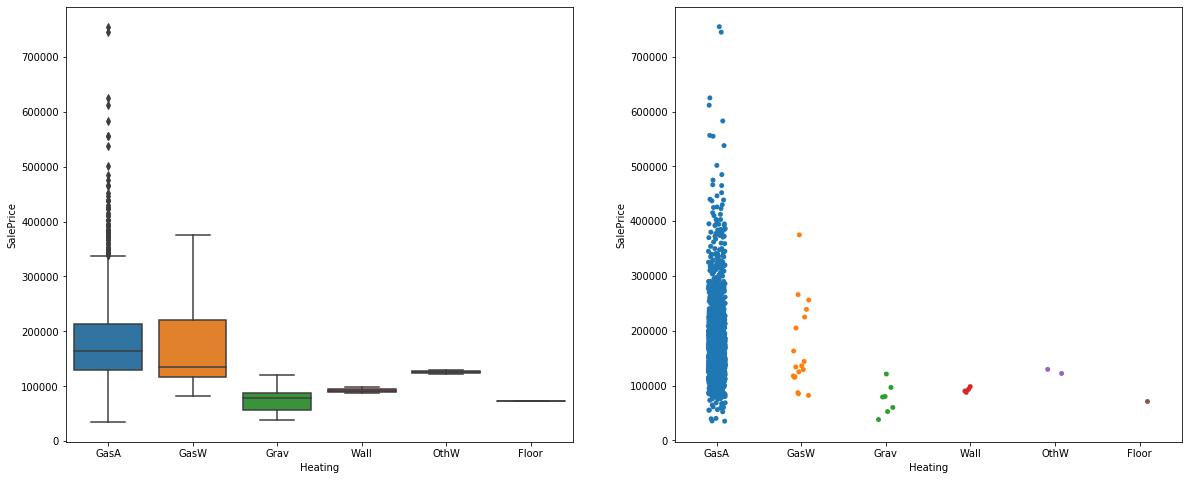

In [249]:
make_discrete_plot('Heating',0,0)

In [250]:
df['Heating'].value_counts()

GasA     2871
GasW       27
Grav        9
Wall        6
OthW        2
Floor       1
Name: Heating, dtype: int64

In [251]:
# most of the data are in one category, therefore the column is unreliable and dropped completely
df = df.drop(columns='Heating')

### GarageType


> Garage type.

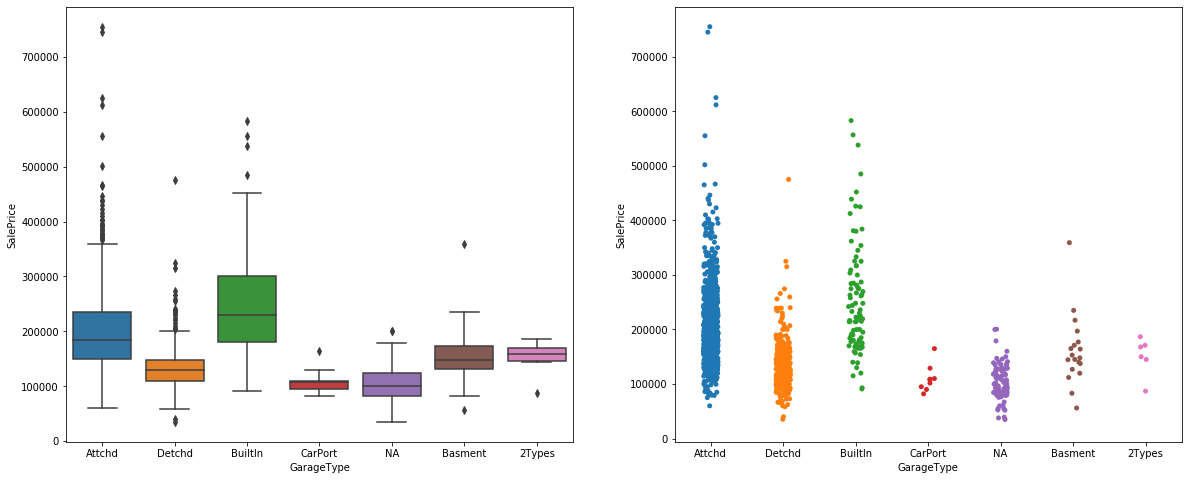

In [253]:
make_discrete_plot('GarageType',0,0)

In [259]:
# only a few data in CarPort and 2Types, then they shall put together as "Other"
df['GarageType'] = df['GarageType'].apply(lambda x: 'Other' if (x == 'CarPort' or x == '2Types') else x)

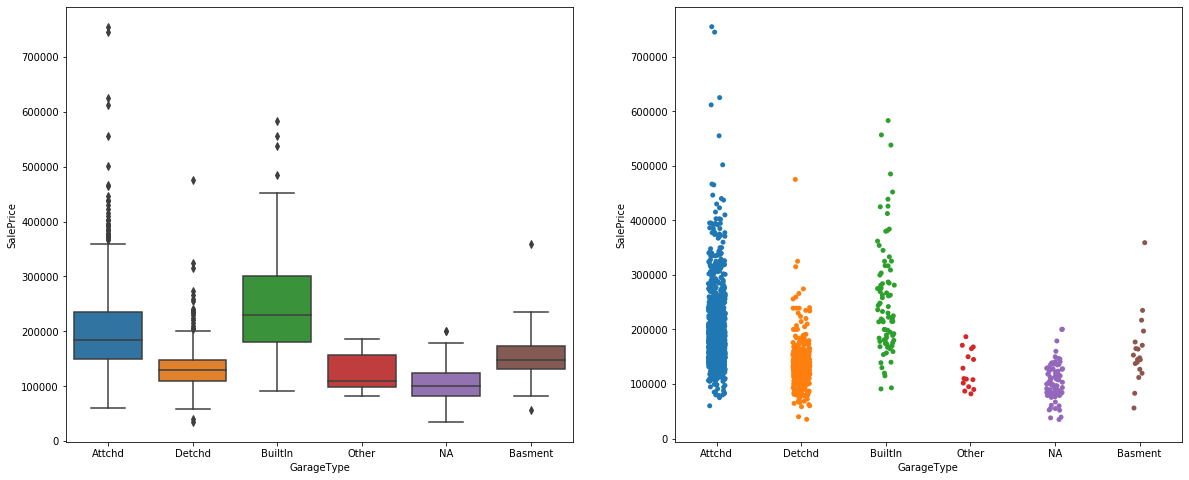

In [260]:
make_discrete_plot('GarageType',0,0)

### MiscFeature


> Miscellaneous feature not covered in other categories.

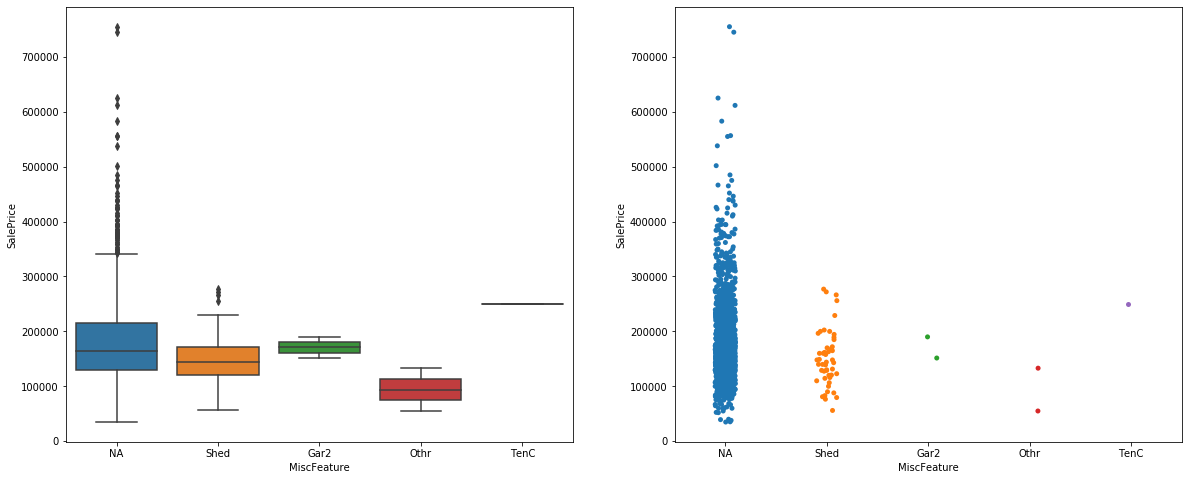

In [261]:
make_discrete_plot('MiscFeature',0,0)

In [262]:
# only a few values in all category excep NA, the feature is redefined as having MiscFeature or Not
df['MiscFeature'] = df['MiscFeature'].apply(lambda x: 0 if x == 'NA' else 1)

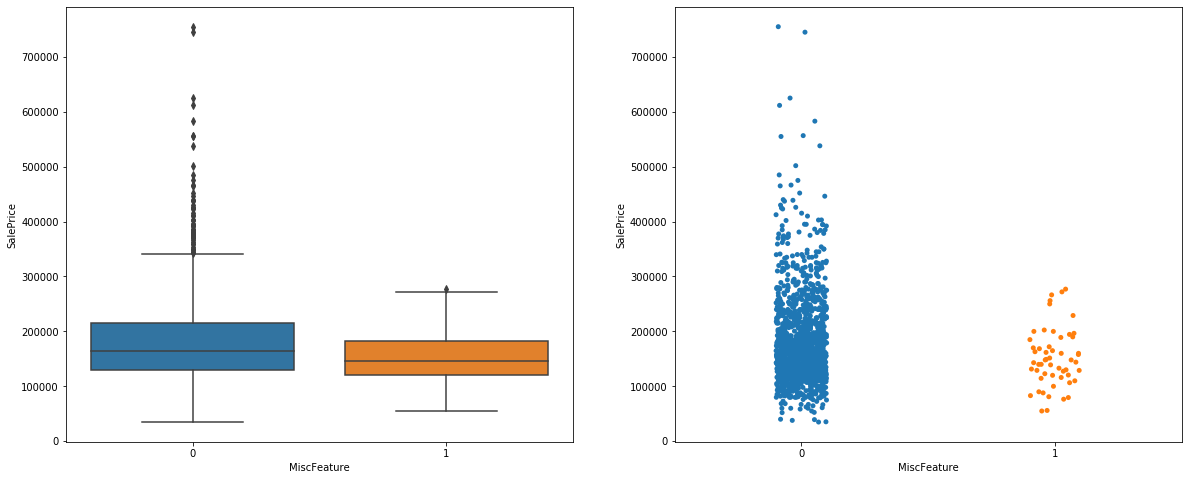

In [263]:
make_discrete_plot('MiscFeature',0,0)

### SaleType


> Type of sale.

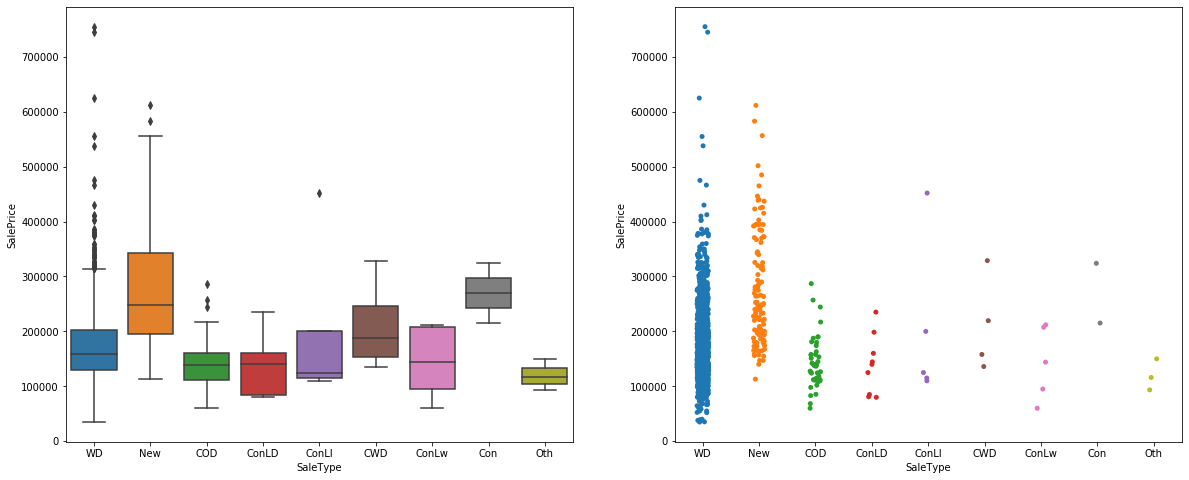

In [264]:
make_discrete_plot('SaleType',0,0)

In [265]:
# only a few values in all category except WD, New and COD, the rest of the feature is combined into one "Other"
df.SaleType = df.SaleType.apply(lambda x: x if x in ['WD','New','COD'] else 'Other')

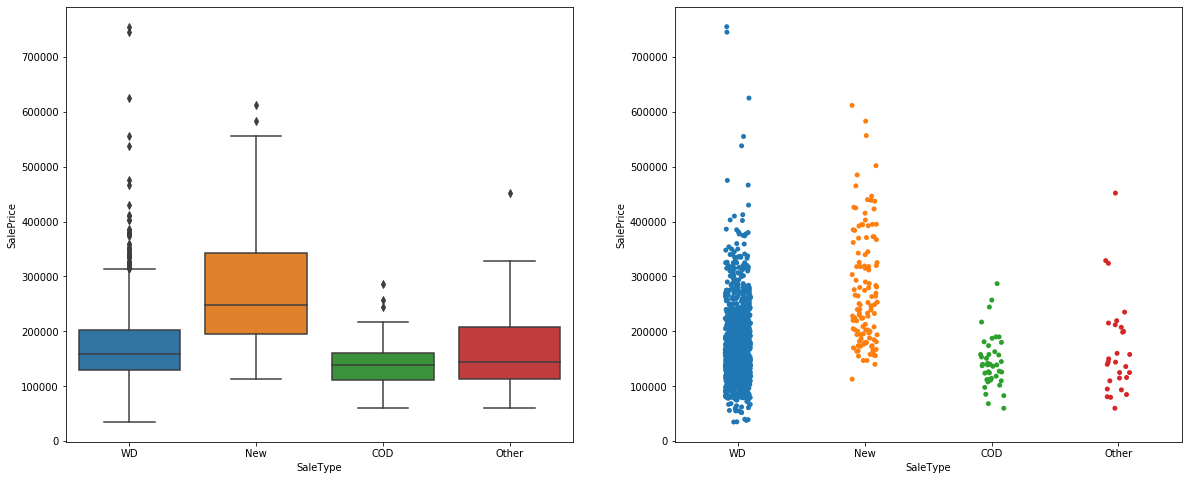

In [266]:
make_discrete_plot('SaleType',0,0)

### SaleCondition

> Condition of Sale.

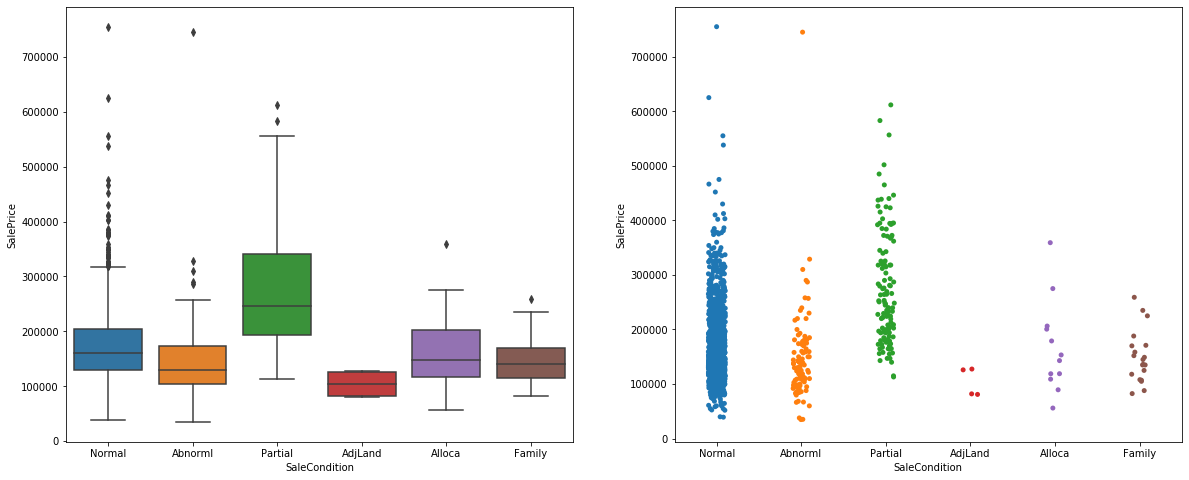

In [267]:
make_discrete_plot('SaleCondition',0,0)

In [270]:
# only a few values in [AdjLand, Alloca, Family], they will be combined into one label("Other")
df.SaleCondition = df.SaleCondition.apply(lambda x: 'Other' if x in ['AdjLand', 'Alloca', 'Family'] else x)

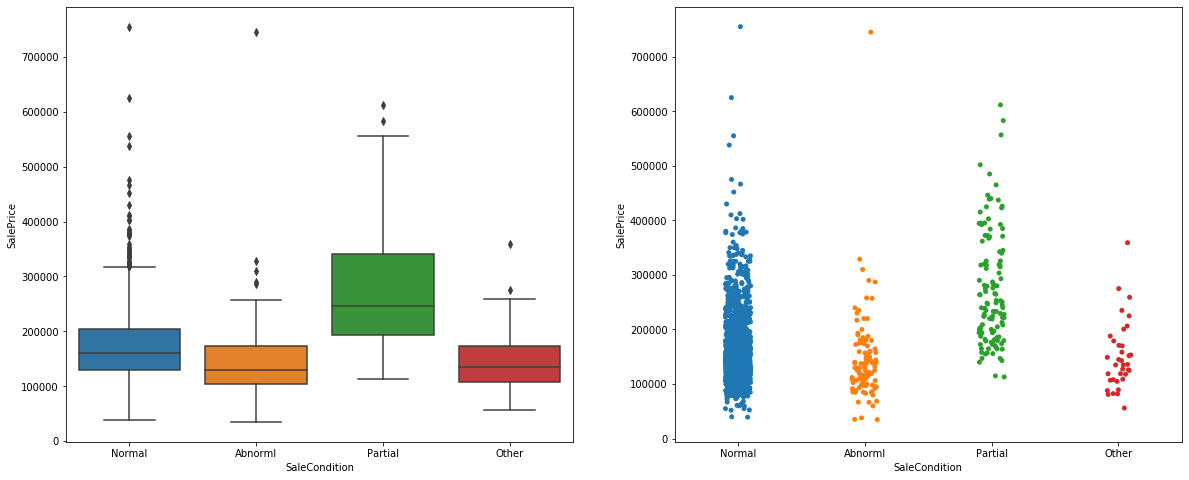

In [271]:
make_discrete_plot('SaleCondition',0,0)

# 5) Machine Learning Models

> In this section we are going to prepare our data, split them into train and test data and fit them into the following machine learning models
* Decision Tree Regressor
* Random Forest Regressor
* XGBoost
* AdaBoost (Decision Tree & Random Forest)

In [318]:
df = df.reset_index(drop=True)
df.shape

(2916, 79)

In [329]:
# splitting data 
X = df.drop(columns=['Id','SalePrice'])
Y = df['SalePrice']

X = pd.get_dummies(X) # getting dummies

## Normalizing skewed features

In [330]:
skewed_features = list(abs(stats.skew(X)) > 0.5)
counter = 0
lambdas = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]
for i in X.columns:
    if skewness[counter] == True:
        idx = np.argmin([abs(stats.skew(boxcox1p(X[i], 0.1))),
                         abs(stats.skew(boxcox1p(X[i], 0.15))),
                         abs(stats.skew(boxcox1p(X[i], 0.2))),
                         abs(stats.skew(boxcox1p(X[i], 0.25))),
                         abs(stats.skew(boxcox1p(X[i], 0.3))),
                         abs(stats.skew(boxcox1p(X[i], 0.35))),
                         abs(stats.skew(boxcox1p(X[i], 0.4))),
                         abs(stats.skew(boxcox1p(X[i], 0.45))),
                         abs(stats.skew(boxcox1p(X[i], boxcox_normmax(X[i]+0.1)))),
                         abs(stats.skew(np.log1p(X[i]))),
                         abs(stats.skew(X[i]))])
        if idx < 8:
            X[i] = boxcox1p(X[i], lambdas[idx])
        if idx == 8:
            X[i] = boxcox1p(X[i], boxcox_normmax(X[i]+0.1))      
        if idx == 9:
            X[i] = np.log1p(X[i])
    counter = counter + 1

## Scaling Data

In [331]:
scaler = RobustScaler()
X[:] = scaler.fit_transform(X)

In [335]:
# train and test
X_train = X.iloc[:len(train)]
y_train = Y.iloc[:len(train)]
X_test = X.iloc[len(X_train):]
test_ID = df['Id'].iloc[len(X_train):]
train_ID = df['Id'].iloc[:len(X_train)]

## Normalizing for target 

In [336]:
y_train = np.log1p(y_train)

## Decision Trees

In [376]:
dtree = DecisionTreeRegressor()

In [377]:
dtree_params = {'min_samples_split': list(range(5,20)),
    'min_samples_leaf':  list(range(1,10)),
    'max_features':  list(range(1,len(X.columns),4))+['auto','sqrt','log2'],
    }

In [378]:
dtree_randomgrid = RandomizedSearchCV(estimator=dtree,
                                param_distributions = dtree_params,
                                n_iter=1000,
                                scoring='neg_mean_squared_error',
                                cv=5,
                                n_jobs=-1
                                )


In [379]:
dtree_randomgrid.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=DecisionTreeRegressor(criterion='mse',
                                                   max_depth=None,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   presort=False,
                                                   random_state=None,
                                                   splitter='best'),
                   iid='warn', n_iter=1000, n_j...
                   param_distri

In [380]:
dtree_randomgrid.best_score_

-0.029716704598903156

In [381]:
dtree_randomgrid.best_params_

{'min_samples_split': 18, 'min_samples_leaf': 9, 'max_features': 201}

In [382]:
dtree_bestparams_overall = dtree_randomgrid.best_params_

## Random Forest Regessor

In [383]:
rfr = RandomForestRegressor()

In [384]:
rfr_param = {
    'n_estimators': list(range(1,150)),
    'criterion': ['mse'],
    'min_samples_split': list(range(2,10)),
    'min_samples_leaf':  list(range(1,20)),
    'min_weight_fraction_leaf': np.linspace(0.1,0.5,5),
    'max_features':  list(range(1,len(X.columns),4))+['auto','sqrt','log2']}




In [385]:
rfr_randomggrid = RandomizedSearchCV(estimator=rfr,
                                param_distributions = rfr_param,
                                n_iter=100,
                                scoring='neg_mean_squared_error',
                                cv=5,
                                n_jobs=-1
                                )


In [386]:
rfr_randomggrid.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [387]:
rfr_randomggrid.best_score_

-0.03237578825997814

In [388]:
rfr_bestparam_overall = rfr_randomggrid.best_params_

## XGBoost

In [356]:
xgb = XGBRegressor()

In [360]:
xgb_param1 = {
    'n_estimators': list(range(1,5000,10)),
    'learning_rate': np.linspace(0.01,0.5,50),
    'max_depth': list(range(1,10)),
    'min_child_weight': list(range(0,5)),
    'subsamaple': np.linspace(0.1,1,10),
    'colsample_bytree': np.linspace(0.1,1,10),
}

In [364]:
xgb_randomgrid = RandomizedSearchCV(estimator=xgb,
                                param_distributions = xgb_param1,
                                n_iter=50,
                                scoring='neg_mean_squared_error',
                                cv=5,
                                n_jobs=-1
                                )

In [365]:
xgb_randomgrid.fit(X_train,y_train)

[19:34:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_st...
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8,
                                                      9],
                                        'min_child_we

In [366]:
xgb_randomgrid.best_score_

-0.013366296026225983

In [367]:
xgb_randomgrid.best_params_

{'subsamaple': 0.5,
 'n_estimators': 2271,
 'min_child_weight': 2,
 'max_depth': 8,
 'learning_rate': 0.01,
 'colsample_bytree': 0.30000000000000004}

In [368]:
xgb_bestparam_overall = xgb_randomgrid.best_params_

# AdaBoost

## AdaBoost - Decision Tree Regressor

In [389]:
dtree_adab = DecisionTreeRegressor(**dtree_bestparams_overall)


In [390]:
ada_dtree = AdaBoostRegressor(base_estimator=dtree_adab)

In [391]:
ada_dtree_paramgrid = {'n_estimators': list(range(1,100,2)),
              'learning_rate': np.linspace(0.01,0.1,10),
              'loss' : ['linear','square','exponential']             
}


In [392]:
ada_dtree_gridsearch = RandomizedSearchCV(estimator=ada_dtree, 
                                    param_distributions=ada_dtree_paramgrid, 
                                    scoring='neg_mean_squared_error',
                                    cv=5,
                                    n_iter=25,
                                    n_jobs=-1)

In [393]:
ada_dtree_gridsearch.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                                                    max_depth=None,
                                                                                    max_features=201,
                                                                                    max_leaf_nodes=None,
                                                                                    min_impurity_decrease=0.0,
                                                                                    min_impurity_split=None,
                                                                                    min_samples_leaf=9,
                                                                                    min_samples_split=18,
                                                                                    min_weight_fraction_

In [394]:
ada_dtree_gridsearch.best_score_

-0.018773812035608874

In [395]:
ada_dtree_gridsearch.best_params_

{'n_estimators': 59, 'loss': 'square', 'learning_rate': 0.1}

In [396]:
ada_dtree_bestparams_overall = ada_dtree_gridsearch.best_params_

## AdaBoost - Random Forest Regressor

In [397]:
rfr_adab = RandomForestRegressor(**rfr_bestparam_overall)

In [398]:
ada_rfr = AdaBoostRegressor(base_estimator=rfr_adab)

In [399]:
ada_rfr_paramgrid = {'n_estimators': list(range(1,100,2)),
              'learning_rate': np.linspace(0.01,0.1,10),
              'loss' : ['linear','square','exponential']             
}


In [402]:
ada_rfr_gridsearch = RandomizedSearchCV(estimator=ada_rfr, 
                                    param_distributions=ada_rfr_paramgrid, 
                                    scoring='neg_mean_squared_error',
                                    cv=25,
                                    n_iter=25,
                                    n_jobs=-1)

In [403]:
ada_rfr_gridsearch.fit(X_train,y_train)

RandomizedSearchCV(cv=2, error_score='raise-deprecating',
                   estimator=AdaBoostRegressor(base_estimator=RandomForestRegressor(bootstrap=True,
                                                                                    criterion='mse',
                                                                                    max_depth=None,
                                                                                    max_features=109,
                                                                                    max_leaf_nodes=None,
                                                                                    min_impurity_decrease=0.0,
                                                                                    min_impurity_split=None,
                                                                                    min_samples_leaf=11,
                                                                                    min_samples_split=8,
    

In [404]:
ada_rfr_gridsearch.best_score_

-0.021995678996674498

In [405]:
ada_rfr_gridsearch.best_params_

{'n_estimators': 87, 'loss': 'square', 'learning_rate': 0.09000000000000001}

In [406]:
ada_rfr_bestparams_overall = ada_rfr_gridsearch.best_params_

# 6) Model Evaluation and Selection 

> To evaluate the model we would be using KFold to train and predict the value of the models and calculating metric scores of each model

## KFold Validation on all tested models 

In [407]:
K = 5
kf = KFold(n_splits = K, shuffle = True)
kfold_list = list(kf.split(X_train, y_train))

In [408]:
# Creating function to calculate train data error, validation data error and metric calculation
def calc_train_error(X_train, y_train, model):
    prediction = model.predict(X_train)
    mean_abs_error = mean_absolute_error(y_train,prediction)
    mean_sqr_error = mean_squared_error(y_train,prediction)
    mean_sqr_log_error = mean_squared_log_error(y_train,prediction)
    median_abs_error = median_absolute_error(y_train,prediction)
    r2 = r2_score(y_train,prediction)
    rmse = np.sqrt(mean_sqr_error)

    return{
        'Root Mean Squared Error': rmse,
        'Mean Absolute Error':mean_abs_error,
        'Mean Squared Error': mean_sqr_error,
        'Mean Squared Log Error': mean_sqr_log_error,
        'Median Absolute Error': median_abs_error,
        'R2 score': r2
    }

def calc_validation_error(X_test, y_test, model):
    prediction = model.predict(X_test)
    mean_abs_error = mean_absolute_error(y_test,prediction)
    mean_sqr_error = mean_squared_error(y_test,prediction)
    mean_sqr_log_error = mean_squared_log_error(y_test,prediction)
    median_abs_error = median_absolute_error(y_test,prediction)
    r2 = r2_score(y_test,prediction)
    rmse = np.sqrt(mean_sqr_error)

    return{
        'Root Mean Squared Error': rmse,
        'Mean Absolute Error':mean_abs_error,
        'Mean Squared Error': mean_sqr_error,
        'Mean Squared Log Error': mean_sqr_log_error,
        'Median Absolute Error': median_abs_error,
        'R2 score': r2
    }

def calc_metrics(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error
    

In [423]:
eval_dtree = DecisionTreeRegressor(**dtree_bestparams_overall)

eval_rfr = RandomForestRegressor(**rfr_bestparam_overall)

eval_xgb = XGBRegressor(**xgb_bestparam_overall)

eval_ada_dtree = AdaBoostRegressor(eval_dtree,**ada_dtree_bestparams_overall)

eval_ada_rfr = AdaBoostRegressor(eval_rfr,**ada_rfr_bestparams_overall)


model_list = [eval_dtree,eval_rfr,eval_xgb,eval_ada_dtree,eval_ada_rfr]
model_name = ['Dtree','RFR','XGB','AdaBoost & dtree','AdaBoost & RFR']

In [424]:
metrics = {}

for model,model_name_name in zip(model_list,model_name):
    train_errors = []
    validation_errors = []
    for train_index, val_index, in kfold_list:

        # split X
        X_train_train, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_train, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        # instantiate model
        model = model

        # calculate errors
        train_error, val_error = calc_metrics(X_train_train, y_train_train, X_val, y_val, model)

        # append to appropirate list
        train_errors.append(train_error)
        validation_errors.append(val_error)
    metrics[model_name_name] = {'train_errors':train_errors,'validation_errors':validation_errors}

[20:04:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:05:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:05:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:05:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:05:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [425]:
columns = pd.MultiIndex.from_product([['Root Mean Squared Error','Mean Absolute Error', 'Mean Squared Error', 'Mean Squared Log Error','Median Absolute Error','R2 score'], ['Dtree','RFR','XGB','AdaBoost & dtree','AdaBoost & RFR']],
                                     names=['Metric', 'Model'])

metric_df = pd.DataFrame(data=0,columns=columns,index=['{} Iteration'.format(i) for i in range(1,K+1)]+['Average'])
for i in list(metric_df.columns.get_level_values(0).drop_duplicates()):
    for k in range(5):
        temp = []
        for j in ['Dtree','RFR','XGB','AdaBoost & dtree','AdaBoost & RFR']:

            temp.append(metrics[j]['validation_errors'][k][i])

        metric_df.loc['{} Iteration'.format(k+1),i] = temp
metric_avg = []
for i in list(metric_df.columns.get_level_values(0).drop_duplicates()):
    for j in ['Dtree','RFR','XGB','AdaBoost & dtree','AdaBoost & RFR']:
        metric_avg.append(metric_df[i][j].mean())
metric_df.loc['Average'] = metric_avg

In [426]:
metric_df

Metric      Root Mean Squared Error                                       \
Model                         Dtree       RFR       XGB AdaBoost & dtree   
1 Iteration                0.183609  0.197923  0.116846         0.144691   
2 Iteration                0.168977  0.164817  0.114289         0.129755   
3 Iteration                0.183366  0.187387  0.130848         0.152341   
4 Iteration                0.177119  0.169821  0.116806         0.142878   
5 Iteration                0.170286  0.182080  0.114712         0.138897   
Average                    0.147226  0.150338  0.098917         0.118094   

Metric                     Mean Absolute Error                      \
Model       AdaBoost & RFR               Dtree       RFR       XGB   
1 Iteration       0.165181            0.135734  0.138427  0.081419   
2 Iteration       0.146774            0.130201  0.118361  0.080826   
3 Iteration       0.152924            0.129267  0.125734  0.083374   
4 Iteration       0.156731            0.131578  0.118229  0.080412   
5 Iteration       0.156913            0.125877  0.124616  0.083930   
Average           0.129754            0.108776  0.104228  0.068327   

Metric                                       ... Median Absolute Error  \
Model       AdaBoost & dtree AdaBoost & RFR  ...                 Dtree   
1 Iteration         0.101763       0.126951  ...              0.102946   
2 Iteration         0.095206       0.115298  ...              0.102418   
3 Iteration         0.098693       0.106247  ...              0.095998   
4 Iteration         0.097362       0.116070  ...              0.102772   
5 Iteration         0.097661       0.123170  ...              0.100858   
Average             0.081781       0.097956  ...              0.084165   

Metric                                                           R2 score  \
Model             RFR       XGB AdaBoost & dtree AdaBoost & RFR     Dtree   
1 Iteration  0.092542  0.060778         0.076954       0.100176  0.811997   
2 Iteration  0.090179  0.056562         0.078231       0.088813  0.806276   
3 Iteration  0.087296  0.062169         0.064393       0.078558  0.789097   
4 Iteration  0.079616  0.057052         0.063914       0.087799  0.789006   
5 Iteration  0.091043  0.062659         0.069513       0.102729  0.818871   
Average      0.073446  0.049870         0.058834       0.076346  0.669208   

Metric                                                           
Model             RFR       XGB AdaBoost & dtree AdaBoost & RFR  
1 Iteration  0.781541  0.923862         0.883250       0.847841  
2 Iteration  0.815698  0.911379         0.885771       0.853841  
3 Iteration  0.779745  0.892605         0.854426       0.853311  
4 Iteration  0.806035  0.908236         0.862700       0.834785  
5 Iteration  0.792911  0.917804         0.879491       0.846201  
Average      0.662655  0.758981         0.727606       0.705996  

[6 rows x 30 columns]

In [427]:
metric_df_transpose = metric_df.transpose()

In [428]:
metric_df_transpose

1 Iteration  2 Iteration  \
Metric                  Model                                        
Root Mean Squared Error Dtree                0.183609     0.168977   
                        RFR                  0.197923     0.164817   
                        XGB                  0.116846     0.114289   
                        AdaBoost & dtree     0.144691     0.129755   
                        AdaBoost & RFR       0.165181     0.146774   
Mean Absolute Error     Dtree                0.135734     0.130201   
                        RFR                  0.138427     0.118361   
                        XGB                  0.081419     0.080826   
                        AdaBoost & dtree     0.101763     0.095206   
                        AdaBoost & RFR       0.126951     0.115298   
Mean Squared Error      Dtree                0.033712     0.028553   
                        RFR                  0.039174     0.027164   
                        XGB                  0.013653     0.013062   
                        AdaBoost & dtree     0.020935     0.016836   
                        AdaBoost & RFR       0.027285     0.021542   
Mean Squared Log Error  Dtree                0.000200     0.000170   
                        RFR                  0.000228     0.000158   
                        XGB                  0.000082     0.000076   
                        AdaBoost & dtree     0.000126     0.000100   
                        AdaBoost & RFR       0.000163     0.000128   
Median Absolute Error   Dtree                0.102946     0.102418   
                        RFR                  0.092542     0.090179   
                        XGB                  0.060778     0.056562   
                        AdaBoost & dtree     0.076954     0.078231   
                        AdaBoost & RFR       0.100176     0.088813   
R2 score                Dtree                0.811997     0.806276   
                        RFR                  0.781541     0.815698   
                        XGB                  0.923862     0.911379   
                        AdaBoost & dtree     0.883250     0.885771   
                        AdaBoost & RFR       0.847841     0.853841   

                                          3 Iteration  4 Iteration  \
Metric                  Model                                        
Root Mean Squared Error Dtree                0.183366     0.177119   
                        RFR                  0.187387     0.169821   
                        XGB                  0.130848     0.116806   
                        AdaBoost & dtree     0.152341     0.142878   
                        AdaBoost & RFR       0.152924     0.156731   
Mean Absolute Error     Dtree                0.129267     0.131578   
                        RFR                  0.125734     0.118229   
                        XGB                  0.083374     0.080412   
                        AdaBoost & dtree     0.098693     0.097362   
                        AdaBoost & RFR       0.106247     0.116070   
Mean Squared Error      Dtree                0.033623     0.031371   
                        RFR                  0.035114     0.028839   
                        XGB                  0.017121     0.013644   
                        AdaBoost & dtree     0.023208     0.020414   
                        AdaBoost & RFR       0.023386     0.024565   
Mean Squared Log Error  Dtree                0.000208     0.000190   
                        RFR                  0.000219     0.000175   
                        XGB                  0.000108     0.000084   
                        AdaBoost & dtree     0.000145     0.000125   
                        AdaBoost & RFR       0.000145     0.000150   
Median Absolute Error   Dtree                0.095998     0.102772   
                        RFR                  0.087296     0.079616   
                        XGB                  0.062169     0.057052   
                        AdaBoost & dtree     0.0643

In [ ]:
fig = plt.figure(figsize=(20,8))
gs = GridSpec(2,3)
sns.boxplot(y=df['SalePrice'], x=df[feature], ax=fig.add_subplot(gs[0,0]))
plt.xticks(rotation = rotation1)
sns.stripplot(y=df['SalePrice'], x=df[feature], ax=fig.add_subplot(gs[0,1]))
plt.xticks(rotation = rotation2)
fig.show()

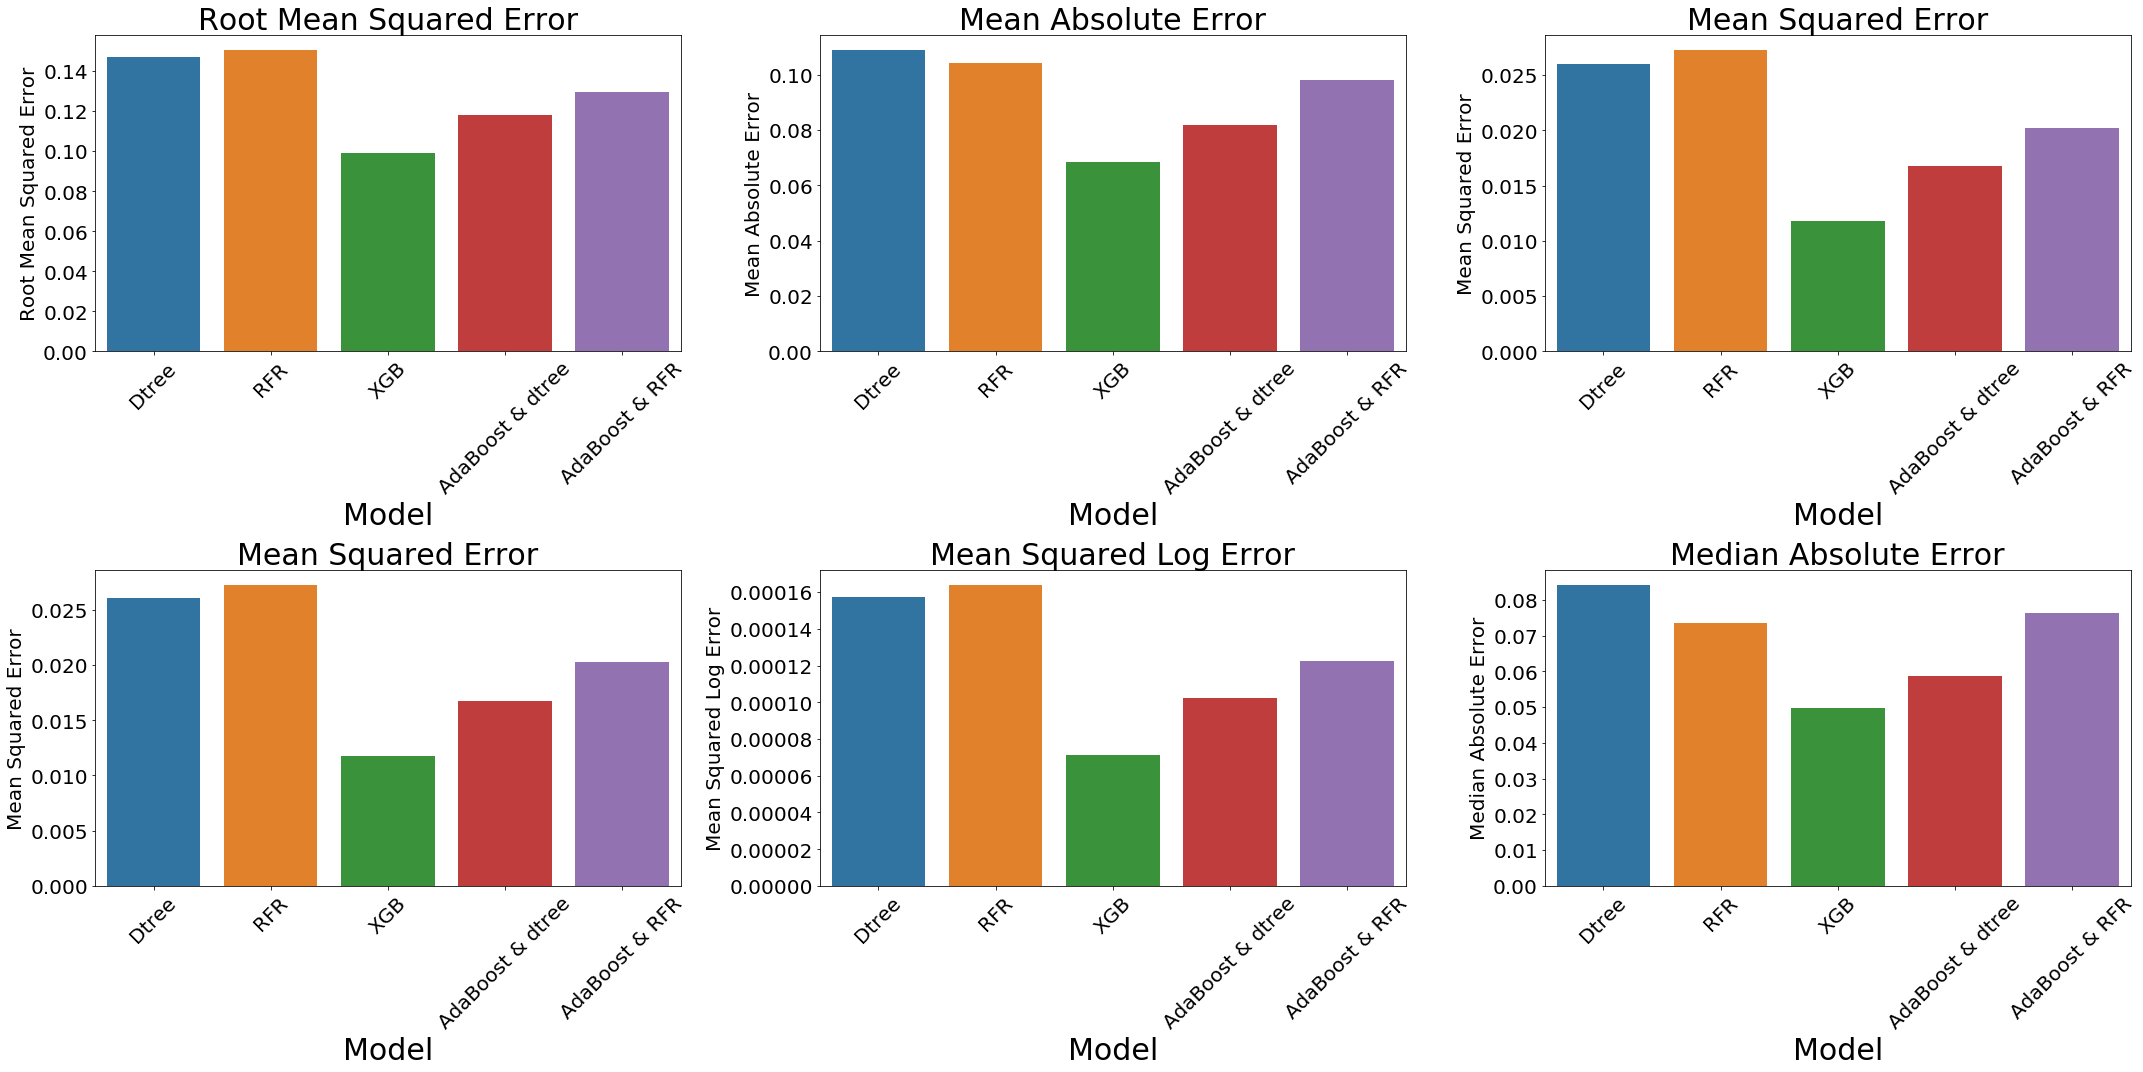

In [496]:
fig = plt.figure(figsize=(30,15))
gs = GridSpec(2,3)

eval_metric_parameters = list(columns.get_level_values(0).unique())
eval_model_names = list(columns.get_level_values(1).unique())

for i in range(2):
    for j in range(3):
        current_metric_parameter = eval_metric_parameters[i*2+j]
        current_data = metric_df_transpose.loc[current_metric_parameter].reset_index()
        sns.barplot(data=current_data,x='Model',y='Average',ax=fig.add_subplot(gs[i,j]))
        plt.title(current_metric_parameter,size=30)
        plt.xticks(size=20,rotation=45)
        plt.yticks(size=20)
        plt.xlabel("Model",size=30)
        plt.ylabel(current_metric_parameter,size=20)

plt.tight_layout()

> Evaluating the graph bars, it is obvious that XGBoost is the most optimal for this particular dataset, therefore XGBoost will be used as the final model for the test data

# 7) Submission

> Using the XGBoost, it will predict the SalePrices of the X_test data

In [447]:
xgb = XGBRegressor(subsamaple= 0.5,
                   n_estimators= 2271,
                   min_child_weight= 2,
                   max_depth= 8,
                   learning_rate= 0.01,
                   colsample_bytree= 0.3)

In [448]:
xgb.fit(X_train,y_train)
y_pred = np.expm1(xgb.predict(X_test))

[20:51:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [449]:
submission = pd.DataFrame(test_ID.values, columns = ["Id"])
submission['SalePrice'] = list(y_pred)
submission.to_csv('final_submission.csv',index=False)

> RMSE score of 0.12664